In [1]:
import random
import matplotlib.pyplot as plt
import os
import numpy as np
import math
import json
from PIL import Image
import matplotlib.image as mpimg


from collections import defaultdict

print(os.getcwd())

os.chdir(r'C:\Users\jari\ICMI_data')
print(os.getcwd())

RData = {}



C:\Users\Jari
C:\Users\jari\ICMI_data


In [2]:
# some routines for later use
# statistical testing and such

def diff_check(a,b,func=np.median):  # the permutation test of mean/median difference
    a_l = len(a)  # length of list a
    b_l = len(b)
    o_diff = func(a) - func(b) # original difference
    c = a[:]
    c.extend(b) # all data in one list

    r_res = [] # collecting the values
    for j in range(10000): # do the test rounds
        a1 = [] # collect samples here
        c_s = c[:] # the rest of samples stay here
        for i in range(a_l):
            r1 = random.randint(0,len(c_s)-1) # pick
            a1.append(c_s.pop(r1)) # move the sample
        r_res.append(func(a1) - func(c_s)) # sample difference
    c_count = 0
#    print(o_diff)
    for i in range(len(r_res)): # count the cases
        if abs(o_diff) <= abs(r_res[i]):
            c_count = c_count + 1
    
    return(c_count / ((float) (len(r_res)))) # proportion of cases

def order_check(a,b):   # the permutation test of order difference
    # the parameters should be two lists of corresponding values
    o = [np.sign(i-j) for i,j in zip(a,b)]
    o_diff = sum(o) # original difference

    r_res = [] # collecting the values
    for j in range(10000): # do the test rounds
        r_res.append(sum([oa if random.random() < 0.5 else -oa for oa in o])) # sample difference
    c_count = 0
#    print(o_diff)
    for i in range(len(r_res)): # count the cases
        if abs(o_diff) <= abs(r_res[i]):
            c_count = c_count + 1
    
    return(c_count / ((float) (len(r_res)))) # proportion of cases


import pandas as pd
import itertools

tlis = [1,2,2,2,4,5,6,5,4,3,2,4]

def spread50(lis):
    s = pd.DataFrame(lis)
    t = s.describe()
    return(t.loc['75%',0]-t.loc['25%',0])

print(spread50(tlis))

def MAD(lis):
    cen = np.median(lis)
    return(np.mean([np.abs(a - cen) for a in lis]))

print(MAD(tlis))

def CI95(lis,func=np.median):
    ests = []
    lislen = len(lis)
    for i in range(10000):
        ests.append(func([lis[np.random.randint(lislen)] for _ in range(lislen)]))
    sests = sorted(ests)
    return([np.percentile(sests, 2.5),np.percentile(sests,97.5)])

print(CI95(tlis))


2.25
1.3333333333333333
[2.0, 4.5]


In [3]:
# read the data

# remember this identifier of the used tracker

DataLabel = 'ICMI'

# All data is saved in here by logfile

RData = {}

# The final results are collected here

MResults = []

MResults.append('Tracker: {}'.format(DataLabel))

# Logfiles are saved in one directory

os.chdir(r'C:\Users\jari\ICMI_data')

# The list of studied logfiles

Fnames = [r'R8logfile_2019-04-24_1336.log',
          r'R9logfile_2019-04-24_1501.log',
          r'R10logfile_2019-04-24_1511.log']

# make the structure for data, if does not exist yet

for fname in Fnames:
    try:
        RData[fname] == 1
    except:
        try:
            RData == 1
        except:
            RData = {}
        RData[fname] = {}

LInvaiid = True
RInvaiid = True
        
def get_targetpoint_xyz(lis):
#    print(lis)
    dd = []
    dd.append(float(lis[3]))
    dd.append(float(lis[4]))
    dd.append(float(lis[5]))
    return(dd)

def get_targetpoint_abr(lis):
    dd = []
    dd.append(float(lis[3]))
    dd.append(float(lis[4]))
    dd.append(float(lis[5]))
    return(dd)

def get_targetpoint_index(lis):
    dd = int(lis[3])
    return(dd)

def get_targettime(lis):
#    print(lis)
    dd = float(lis[1])
    return(dd)

def get_gazepoint(lis):
    dd = []
    dd.append(float(lis[3]))
    dd.append(float(lis[4]))
    dd.append(float(lis[5]))
    return(dd)

def get_gazetime(lis):
    dd = float(lis[1])
    return(dd)

def read_data(filename):
    fil = open(filename)
    Started = False
    Going = False
    TTIme = 0.0
    GTime = 0.0
    dd = {}

    for f in fil:
#        print(f)
        wc = f.split()
        if 'Start_key_pressed' in f:
            Started = True
            try:
                dd['StartTime'] = wc[1]
            except:
                print('Error in line '+f)
        if 'Stop_key_pressed' in f:
            Started = False
            try:
                dd['EndTime'] = wc[1]
            except:
                print('Error in line '+f)
        if 'Timestamp_by_user' in f:
            try:
                dd['Timestamp'] == 1
            except:
                dd['Timestamp'] = []
            dd['Timestamp'].append('TimeStamp: '+wc[1])
        if 'CalibrationStart' in f:
            dd['CalibrationStart'] = True
        if 'CalibrationResult' in f:
            dd['CalibrationResult'] = wc[3]
            
        if not Started:
            continue

        if 'New_position_xyz' in f:
            try:
                dd['TPoints_xyz'] == 1
            except:
                dd['TPoints_xyz'] = []
                dd['TPoints_abr'] = []
                dd['TPoints_index'] = []
                dd['GPoints_xyz'] = []
            TPoints_xyz_temp = get_targetpoint_xyz(wc)
        if 'New_position_abr' in f:
            TPoints_abr_temp = get_targetpoint_abr(wc)
        if 'New_position_index' in f:
            TPoints_index_temp = get_targetpoint_index(wc)
            
        if 'Measure_start' in f:
#            print(wc[0])
            Going = True
            CCount = 0
            dd['GPoints_xyz'].append([])
            dd['TPoints_xyz'].append(TPoints_xyz_temp)
            dd['TPoints_abr'].append(TPoints_abr_temp)
            dd['TPoints_index'].append(TPoints_index_temp)
            TTime = get_targettime(wc)
        if 'Measure_end' in f:
#            print(wc[0])
#            print(len(dd['GPoints_xyz'][-1]))
            Going = False
            
        d_time = 0.50 # time to wait from beginning
        m_time = 1.00 # the maximum collecting time from beginning
        if Going:
            if 'Left_Gaze_UnitVector' in f:
#                print(wc)
                if 'Invalid' in f or 'INVALID' in f:
                    LInvalid = True
                    continue
                else:
                    LInvalid = False
                ETime = GTime
                GTime = get_gazetime(wc)
                CCount += 1
#                print(GTime, GTime-ETime, CCount)
                if TTime + d_time > GTime:   # wait for 0.5 seconds before collecting
                    continue
                if TTime + m_time < GTime:   # collect only to 1.0 seconds from start
                    continue
                dd['GPoints_xyz'][-1].append({})
                dd['GPoints_xyz'][-1][-1]['left_unitv'] = get_gazepoint(wc)
                dd['GPoints_xyz'][-1][-1]['timefromstart'] = GTime-TTime
            if 'Left_Origin' in f and not LInvalid:
                GTime = get_gazetime(wc)
                if TTime + d_time > GTime:   # wait for 0.5 seconds before collecting
                    continue
                if TTime + m_time < GTime:   # collect only to 1.0 seconds from start
                    continue
                dd['GPoints_xyz'][-1][-1]['left_origin'] = get_gazepoint(wc)
            if 'Right_Gaze_UnitVector' in f:
                if 'Invalid' in f or 'INVALID' in f:
                    RInvalid = True
                    continue
                else:
                    RInvalid = False
                GTime = get_gazetime(wc)
                if TTime + d_time > GTime:   # wait for 0.5 seconds before collecting
                    continue
                if TTime + m_time < GTime:   # collect only to 1.0 seconds from start
                    continue
                try:
                    dd['GPoints_xyz'][-1][-1] == 1
                except:
                    dd['GPoints_xyz'][-1].append({})
                    dd['GPoints_xyz'][-1][-1]['timefromstart'] = GTime-TTime
                dd['GPoints_xyz'][-1][-1]['right_unitv'] = get_gazepoint(wc)
            if 'Right_Origin' in f and not RInvalid:
                GTime = get_gazetime(wc)
                if TTime + d_time > GTime:   # wait for 0.5 seconds before collecting
                    continue
                if TTime + m_time < GTime:   # collect only to 1.0 seconds from start
                    continue
                dd['GPoints_xyz'][-1][-1]['right_origin'] = get_gazepoint(wc)
            if 'GazeTargetLeft' in f and not LInvalid:
                GTime = get_gazetime(wc)
                if TTime + d_time > GTime:   # wait for 0.5 seconds before collecting
                    continue
                if TTime + m_time < GTime:   # collect only to 1.0 seconds from start
                    continue
                dd['GPoints_xyz'][-1][-1]['lefttotarget'] = get_gazepoint(wc)
            if 'GazeTargetRight' in f and not RInvalid:
                GTime = get_gazetime(wc)
                if TTime + d_time > GTime:   # wait for 0.5 seconds before collecting
                    continue
                if TTime + m_time < GTime:   # collect only to 1.0 seconds from start
                    continue
                dd['GPoints_xyz'][-1][-1]['righttotarget'] = get_gazepoint(wc)
            
    fil.close()
    return(dd)


for df in Fnames:
    print(df)
    RData[df] = read_data(df)

print(len(RData))
for aa in RData:
    print()
    print('Log file: {:}'.format(aa))
    print('{:} target locations'.format(len(RData[aa]['TPoints_xyz'])))
    


R8logfile_2019-04-24_1336.log
R9logfile_2019-04-24_1501.log
R10logfile_2019-04-24_1511.log
3

Log file: R8logfile_2019-04-24_1336.log
38 target locations

Log file: R9logfile_2019-04-24_1501.log
38 target locations

Log file: R10logfile_2019-04-24_1511.log
38 target locations


{'R8': {'Age': 36, 'Gender': 'Female', 'UseGaze': True, 'UseHMD': True, 'Vision': 'Glasses', 'UseDuring': True, 'General': {'Differences': ['In the second device [DEV2] the display is sharper.', 'Felt, like the ball was moving faster in the second device [DEV2].', 'The second device [DEV2] is heavier/feels heavier.'], 'MoreTired': True, 'Other': ['']}}, 'R9': {'Age': 41, 'Gender': 'Female', 'UseGaze': True, 'UseHMD': True, 'Vision': 'Other', 'WhatOther': 'Surgery', 'UseDuring': False, 'General': {'Differences': [''], 'MoreTired': False, 'Other': ['']}}, 'R10': {'Age': 45, 'Gender': 'Male', 'UseGaze': True, 'UseHMD': True, 'Vision': 'Glasses', 'UseDuring': True, 'General': {'Differences': ['In the second device [DEV2] the display is sharper.', 'In the first device [DEV1] the field-of-view is wider.'], 'MoreTired': False, 'Other': ['']}}}

There were 1 male and 2 female participants
Median age was 40 years (varied from 36 to 45 years)
3 participants had used gaze tracking system before
3

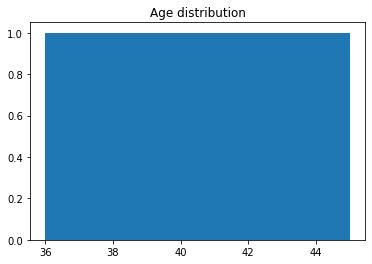

In [4]:
# status data, the answers to qualitative questions
# These may vary a lot between studies and needs editing

# Vision: Normal, Glasses, Contact, Other   (if 'Glasses' then add 'UseDuring') (if 'Other' then add 'WhatOther')
# Gender: Female, Male

StatusData = {}
StatusData['R8'] = {'Age': 36, 'Gender': 'Female', 'UseGaze':True ,'UseHMD':True, 'Vision':'Glasses', 'UseDuring':True}
StatusData['R8']['General'] = {'Differences':['In the second device [DEV2] the display is sharper.',
                                              'Felt, like the ball was moving faster in the second device [DEV2].',
                                              'The second device [DEV2] is heavier/feels heavier.'], 
                               'MoreTired':True, 
                               'Other':['']}
StatusData['R9'] = {'Age': 41, 'Gender': 'Female', 'UseGaze':True ,'UseHMD':True, 'Vision':'Other', 'WhatOther':'Surgery', 'UseDuring':False}
StatusData['R9']['General'] = {'Differences':[''], 
                               'MoreTired':False, 
                               'Other':['']}
StatusData['R10'] = {'Age': 45, 'Gender': 'Male', 'UseGaze':True ,'UseHMD':True, 'Vision':'Glasses', 'UseDuring':True}
StatusData['R10']['General'] = {'Differences':['In the second device [DEV2] the display is sharper.',
                                               'In the first device [DEV1] the field-of-view is wider.'], 
                               'MoreTired':False, 
                               'Other':['']}

print(StatusData)

# some analysis of the data

MSum = sum([1 for pp in StatusData if StatusData[pp]['Gender'] == 'Male'])
FSum = sum([1 for pp in StatusData if StatusData[pp]['Gender'] == 'Female'])
Ages = [StatusData[pp]['Age'] for pp in StatusData if StatusData[pp]['Age'] != 0]
UseGaze = sum([1 for pp in StatusData if StatusData[pp]['UseGaze']])
UseHMD = sum([1 for pp in StatusData if StatusData[pp]['UseHMD']])
NVision = sum([1 for pp in StatusData if StatusData[pp]['Vision'] == 'Normal'])
GVision = sum([1 for pp in StatusData if StatusData[pp]['Vision'] == 'Glasses'])
CVision = sum([1 for pp in StatusData if StatusData[pp]['Vision'] == 'Contact'])
OVision = sum([1 for pp in StatusData if StatusData[pp]['Vision'] == 'Other'])
UseDuring = sum([1 for pp in StatusData if StatusData[pp]['Vision'] == 'Glasses' if StatusData[pp]['UseDuring']])
OtherMethods = [StatusData[pp]['WhatOther'] for pp in StatusData if StatusData[pp]['Vision'] == 'Other']
MoreTired = sum([1 for pp in StatusData if StatusData[pp]['General']['MoreTired']])
DiffComments = [StatusData[pp]['General']['Differences'] for pp in StatusData]
OtherComments = [StatusData[pp]['General']['Other'] for pp in StatusData]

print('\nThere were {:} male and {:} female participants'.format(MSum, FSum))
print('Median age was {:2d} years (varied from {:} to {:} years)'.format(int(np.mean(Ages)), min(Ages), max(Ages)))
print('{:} participants had used gaze tracking system before'.format(UseGaze))
print('{:} participants had used head mounted displays before'.format(UseHMD))
print('\n{:} participants had normal vision and {:} had corrected normal vision'.format(NVision, 
                                                                                      sum([GVision,CVision,OVision])))
print('Of corrected normal vision, {:} used glasses, {:} contact lenses, and {:} other methods'.format(GVision, CVision, OVision))
if GVision > 0:
    print('Of the {:} glasses users {:} used the glasses during the study'.format(GVision, UseDuring))
if OVision > 0:
    print('The other vision correction methods were:')
    for aa in OtherMethods:
        print('       {:}'.format(aa))
print('\n{:} participants eyes were more tired after the study'.format(MoreTired))
print('\nComments to a question of devices differences were:')
for aa in DiffComments:
    for bb in aa:
        if len(bb) > 0:
            print('    {:}'.format(bb))
print('\nOther comments were:')
for aa in OtherComments:
    for bb in aa:
        if len(bb) > 0:
            print('    {:}'.format(bb))
            
plt.hist(Ages,bins=int(len(Ages)))
plt.title('Age distribution')
plt.show()
                

In [5]:
# some status info of the data and some cleaning

MissingEnd = []

print(len(RData))
DataLengths = []
for aa in RData:
    print('\nLog file: {:}'.format(aa))
#    print(RData[aa].keys())
    try:
        RData[aa]['CalibrationResult'] == 1
    except:
        RData[aa]['CalibrationResult'] = 'Not calibrated'
    print('Calibrated {:}'.format(RData[aa]['CalibrationResult']))
    print('{:} target locations'.format(len(RData[aa]['TPoints_xyz'])))
    
    
    dlen = [len(a) for a in RData[aa]['GPoints_xyz']]
    print('Collected samples for different targets {:}'.format(dlen))
    if 0 in dlen:
        print('Should clean empty targets')
        for i in range(len(dlen)-1,-1,-1):
            if dlen[i] == 0:
                RData[aa]['GPoints_xyz'].pop(i)
                RData[aa]['TPoints_xyz'].pop(i)
                RData[aa]['TPoints_abr'].pop(i)
                RData[aa]['TPoints_index'].pop(i)
        dlen = [len(a) for a in RData[aa]['GPoints_xyz']]
        print('Collected samples for different targets {:}'.format(dlen))
    ilen = [a for a in RData[aa]['TPoints_index']]
    print('List of target index: {:}'.format(ilen))

    dlen = [len([i for i in a if 'righttotarget' in i]) for a in RData[aa]['GPoints_xyz']]
    if 0 in dlen:
        print('Should clean empty (right) targets')
        for i in range(len(dlen)-1,-1,-1):
            if dlen[i] == 0:
                RData[aa]['GPoints_xyz'].pop(i)
                RData[aa]['TPoints_xyz'].pop(i)
                RData[aa]['TPoints_abr'].pop(i)
                RData[aa]['TPoints_index'].pop(i)
        dlen = [len(a) for a in RData[aa]['GPoints_xyz']]
        print('Collected samples for different targets {:}'.format(dlen))
    dlen = [len([i for i in a if 'lefttotarget' in i]) for a in RData[aa]['GPoints_xyz']]
    if 0 in dlen:
        print('Should clean empty (left) targets')
        for i in range(len(dlen)-1,-1,-1):
            if dlen[i] == 0:
                RData[aa]['GPoints_xyz'].pop(i)
                RData[aa]['TPoints_xyz'].pop(i)
                RData[aa]['TPoints_abr'].pop(i)
                RData[aa]['TPoints_index'].pop(i)
        dlen = [len(a) for a in RData[aa]['GPoints_xyz']]
        print('Collected samples for different targets {:}'.format(dlen))
    print('{:} target locations'.format(len(RData[aa]['TPoints_xyz'])))
                

    print()
    al = [a for a in RData[aa].keys()]  # keywords
    print(al)
    
    print(RData[aa]['TPoints_xyz'])
    print(RData[aa]['GPoints_xyz'][0][0])
#    print(RData[aa])
    print('We have {:} locations left'.format(len(RData[aa]['TPoints_xyz'])))
    DataLengths.append(len(RData[aa]['TPoints_xyz']))
    ilen = [a for a in RData[aa]['TPoints_index']]
    flen = [a for a in range(38)]
    if set(flen)-set(ilen):
        print('Missing: {:}'.format(set(flen)-set(ilen)))
        MissingEnd.append(set(flen)-set(ilen))

DataLengths.sort()
print()
print(DataLengths)
print('Missing: {:}'.format(MissingEnd))
    


3

Log file: R8logfile_2019-04-24_1336.log
Calibrated successful
38 target locations
Collected samples for different targets [18, 26, 22, 26, 31, 18, 22, 27, 25, 27, 27, 18, 18, 27, 10, 26, 27, 20, 18, 30, 26, 26, 27, 17, 22, 27, 27, 26, 23, 22, 23, 26, 25, 27, 26, 18, 25, 26]
List of target index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
38 target locations

['CalibrationStart', 'CalibrationResult', 'StartTime', 'TPoints_xyz', 'TPoints_abr', 'TPoints_index', 'GPoints_xyz']
[[0.0, 0.0, 1.0], [0.1232568, 0.1232568, 1.992389], [0.4911511, -0.4911513, 3.939231], [-0.3081421, 0.3081421, 4.980974], [-0.7255343, -0.7255341, 2.819078], [0.4911512, 0.4911512, 3.939231], [2.078643e-09, -0.1743115, 1.992389], [-1.494181, 1.494181, 4.531539], [-3.036161e-08, 0.6945927, 3.939231], [-0.1743115, -1.523879e-08, 1.992389], [1.223565e-08, -1.02606, 2.819078], [-0.4911512, -0.4911512, 3.939231], [0.3081

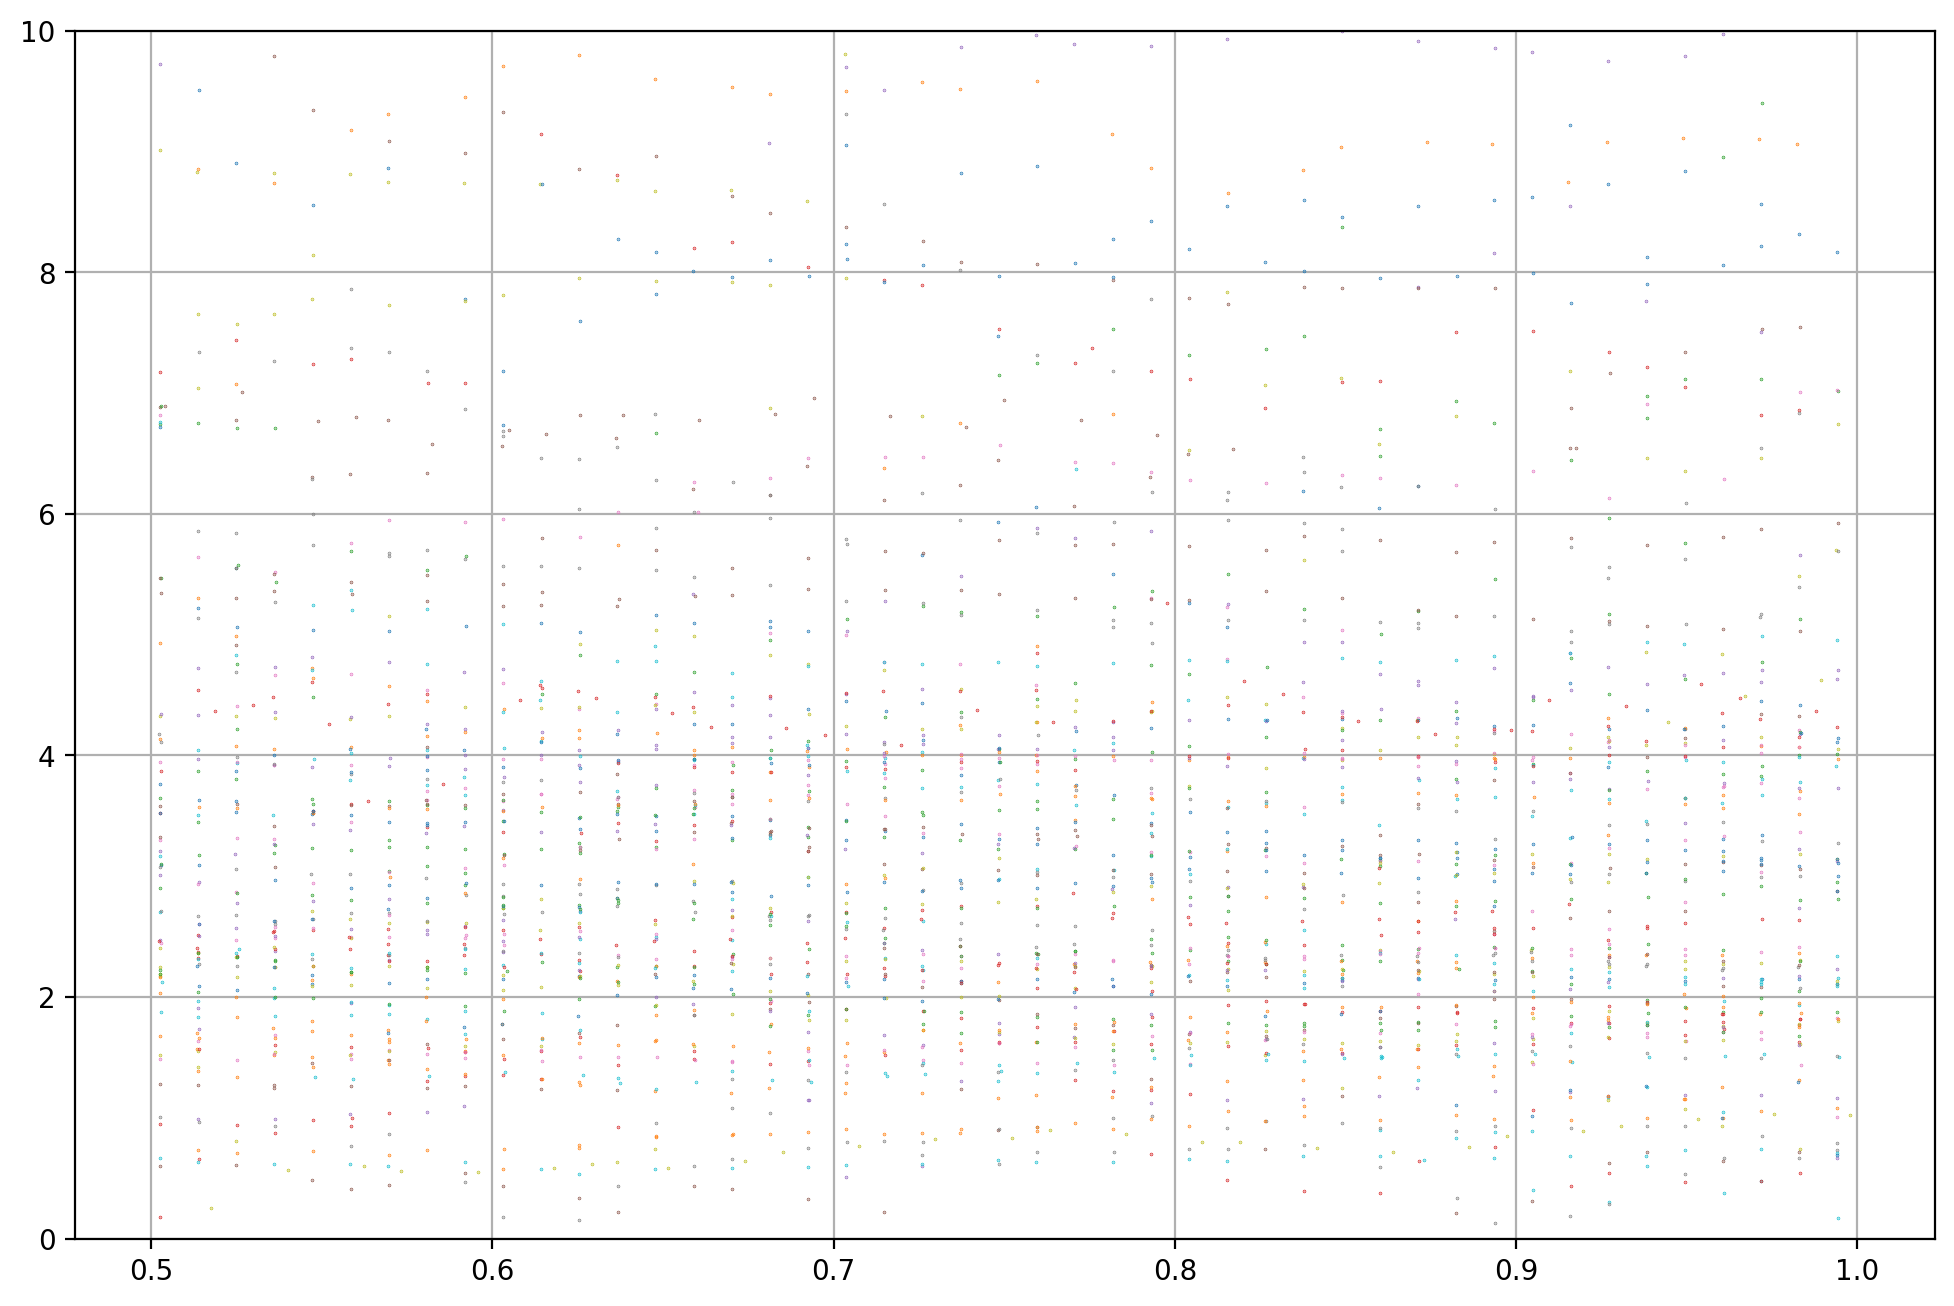

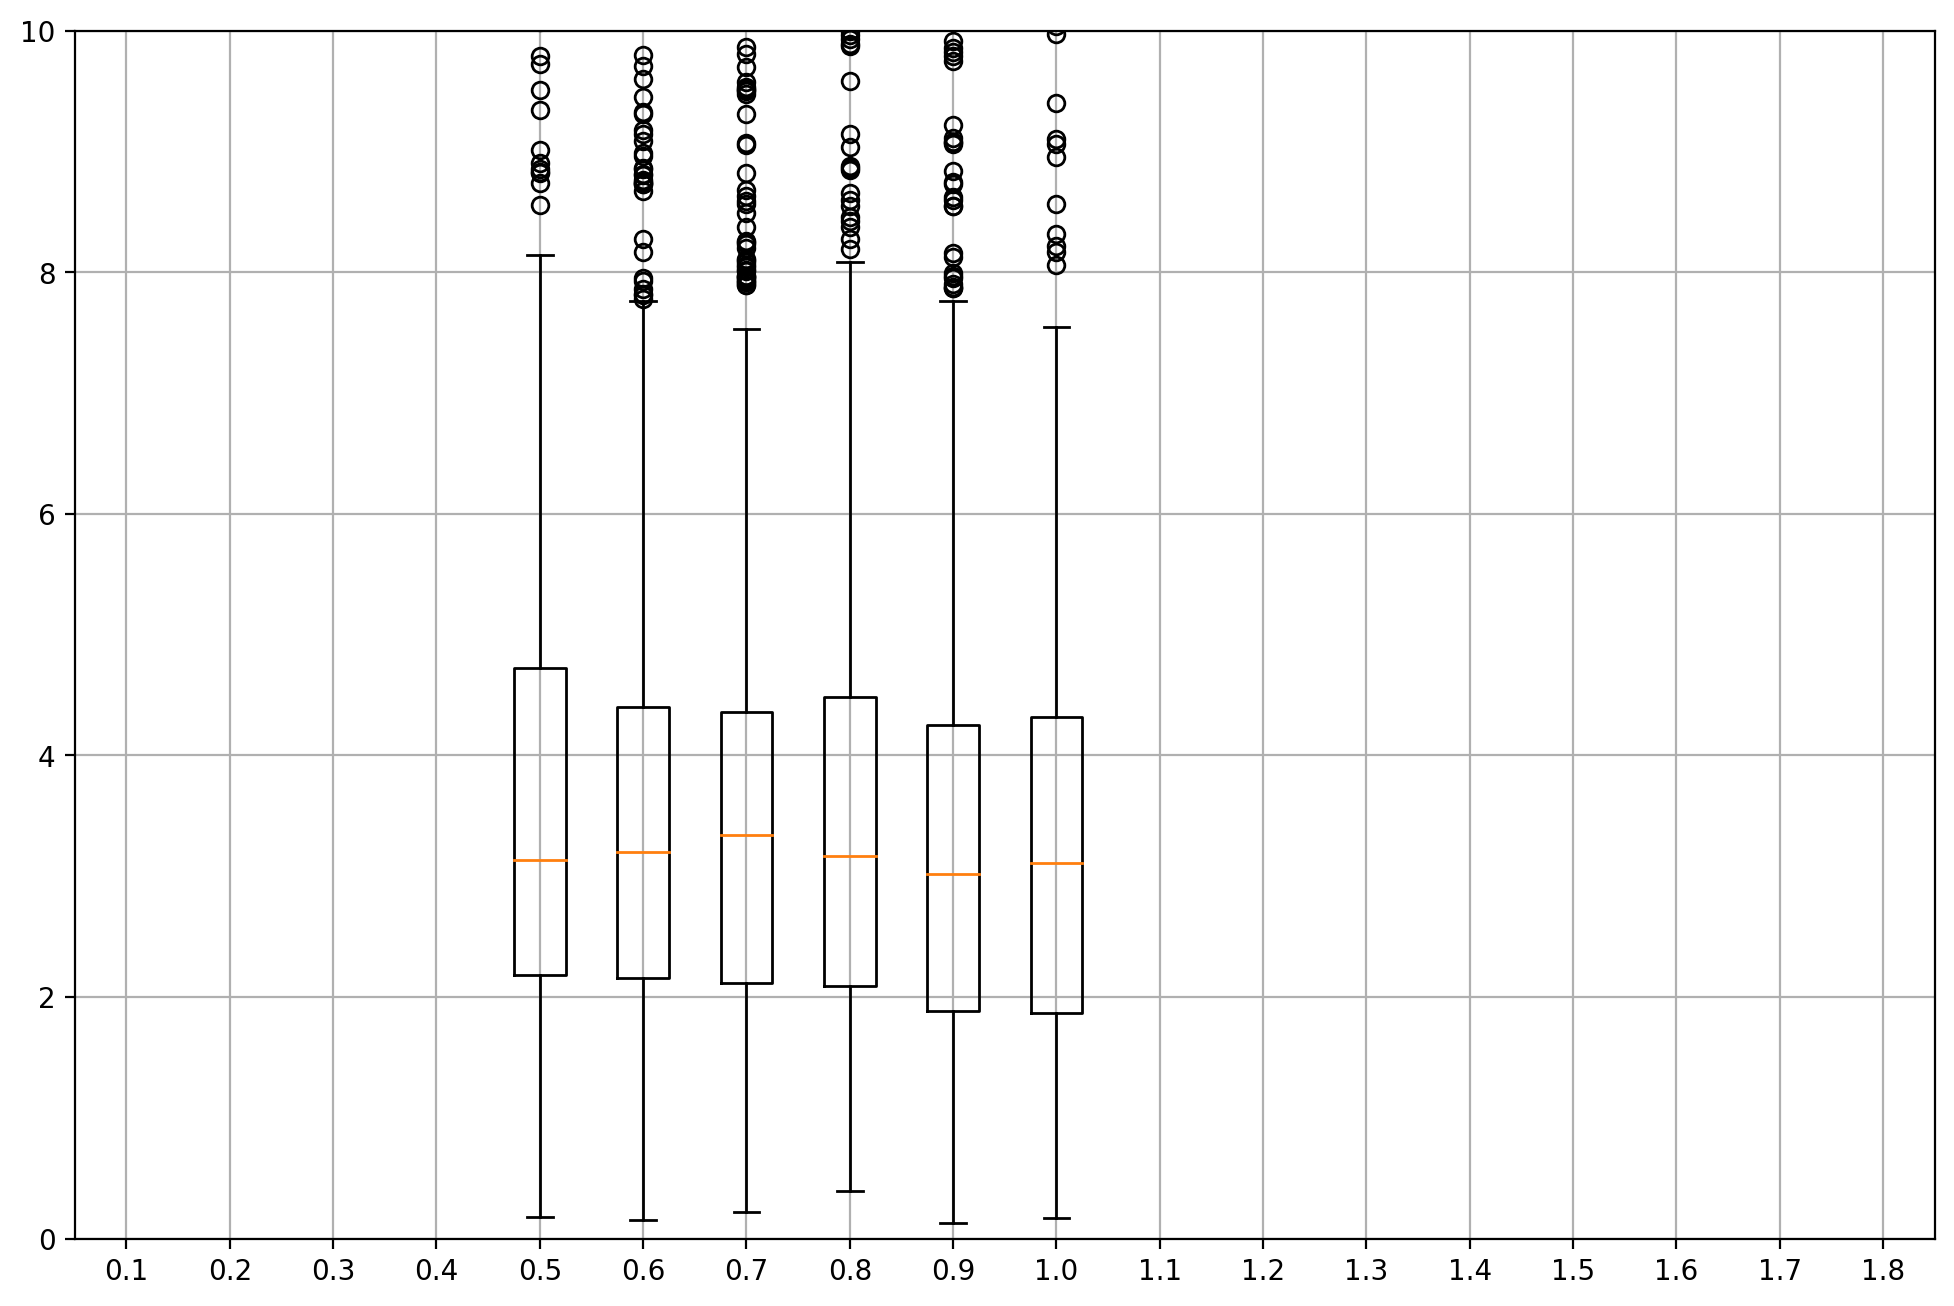

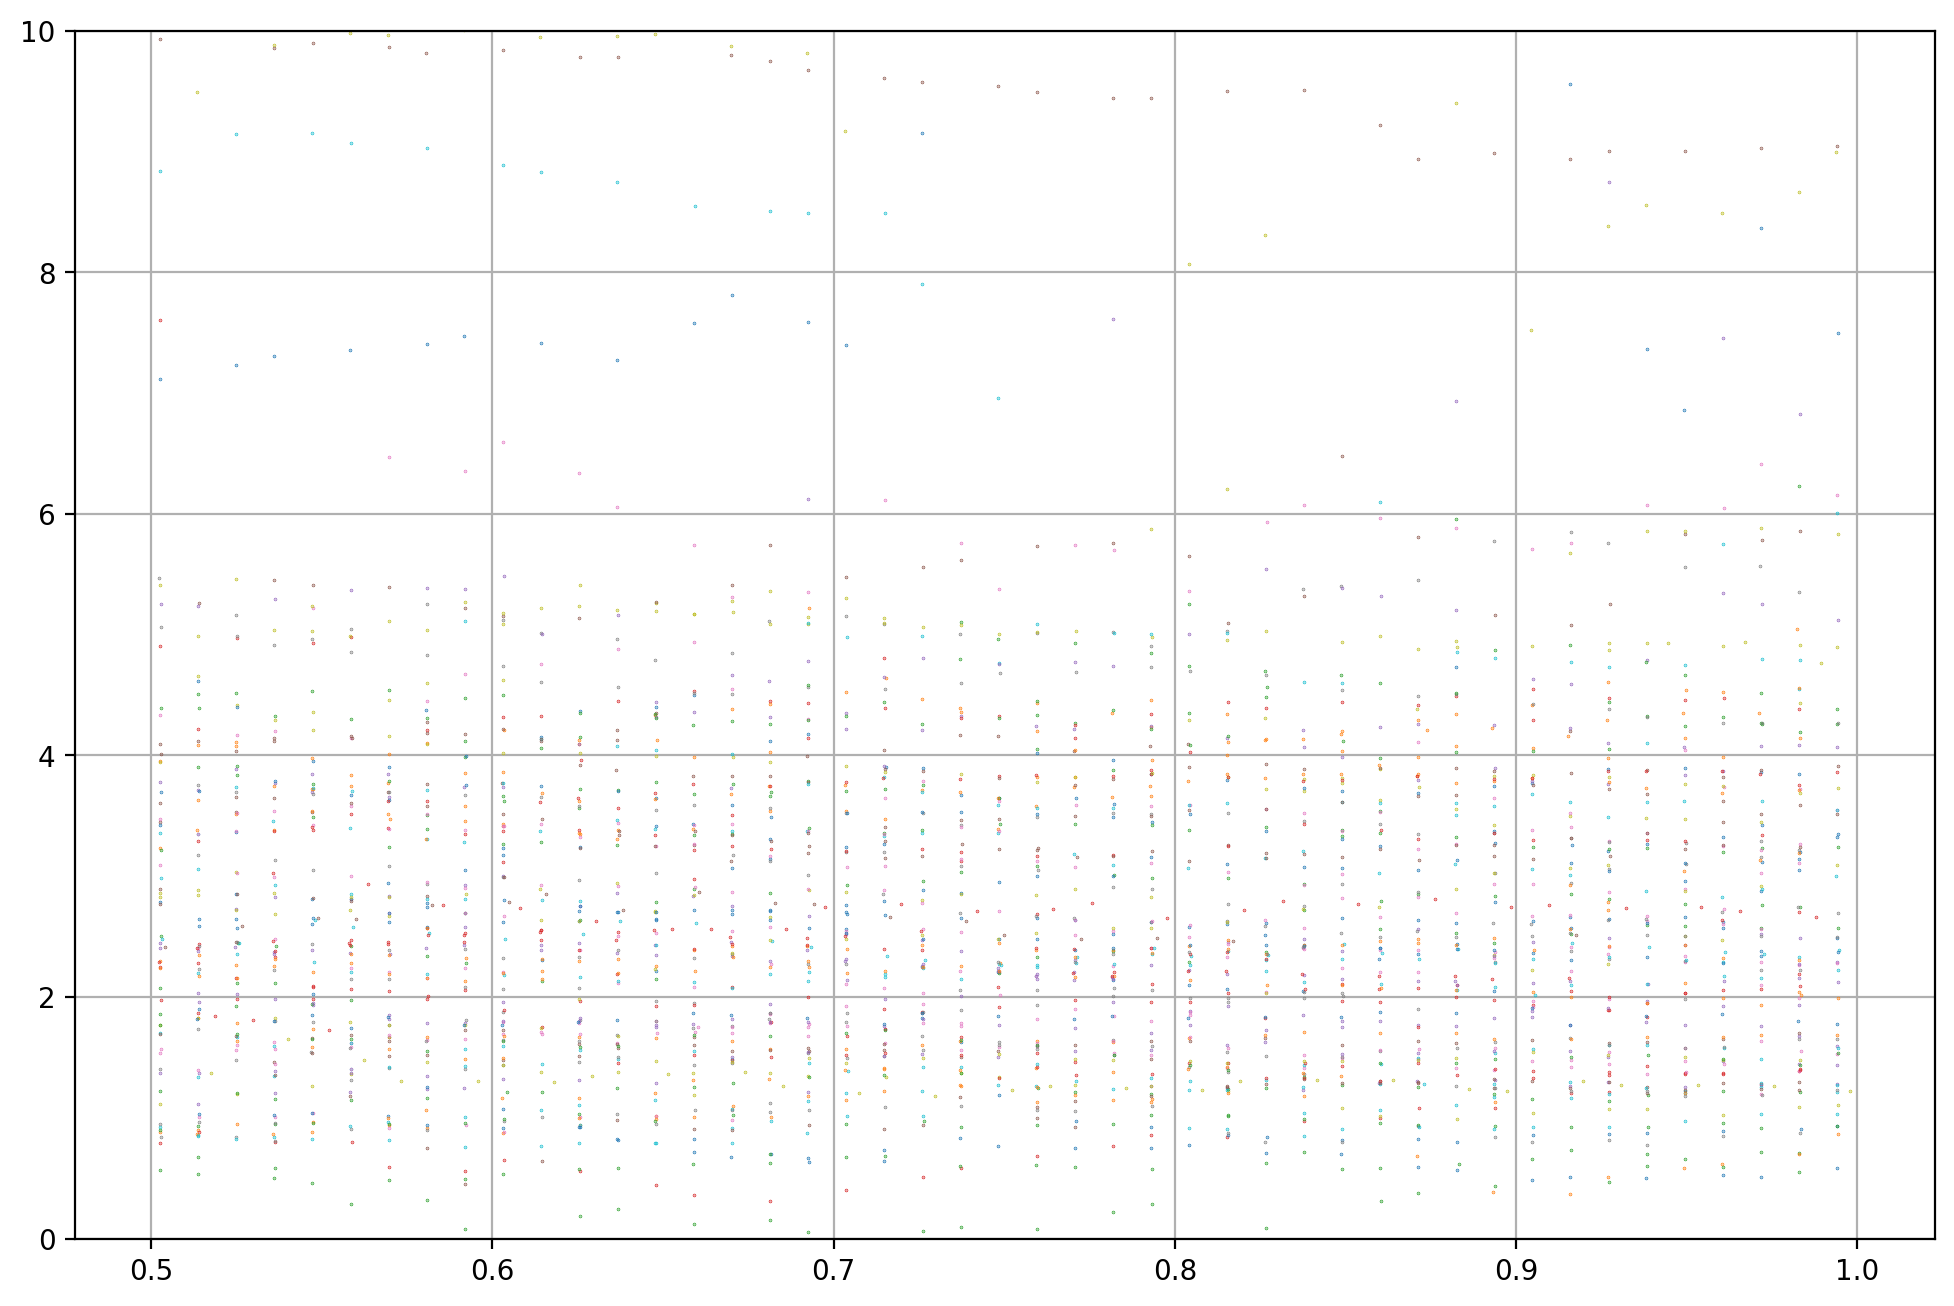

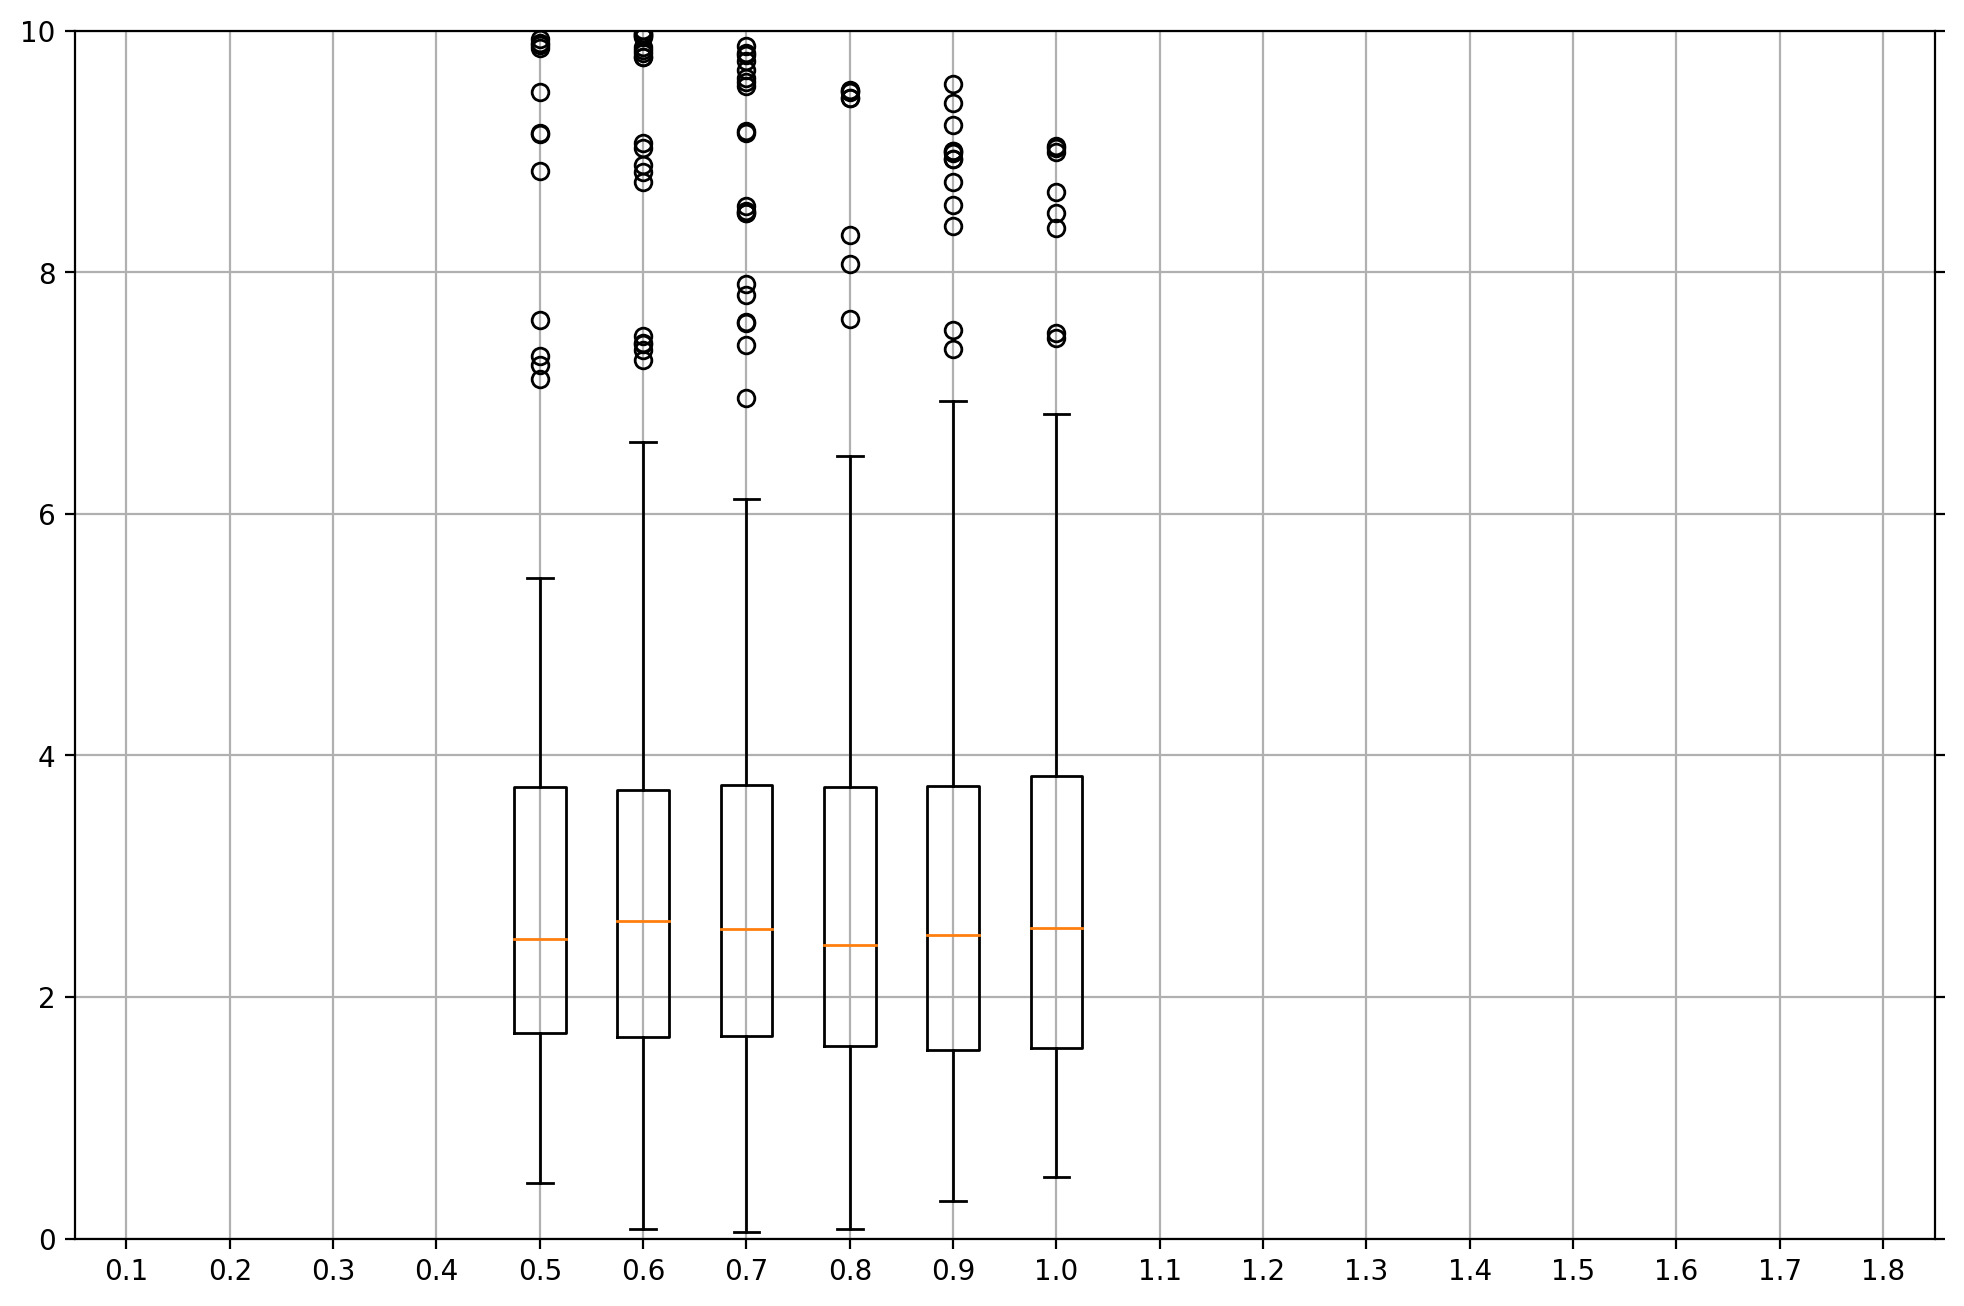

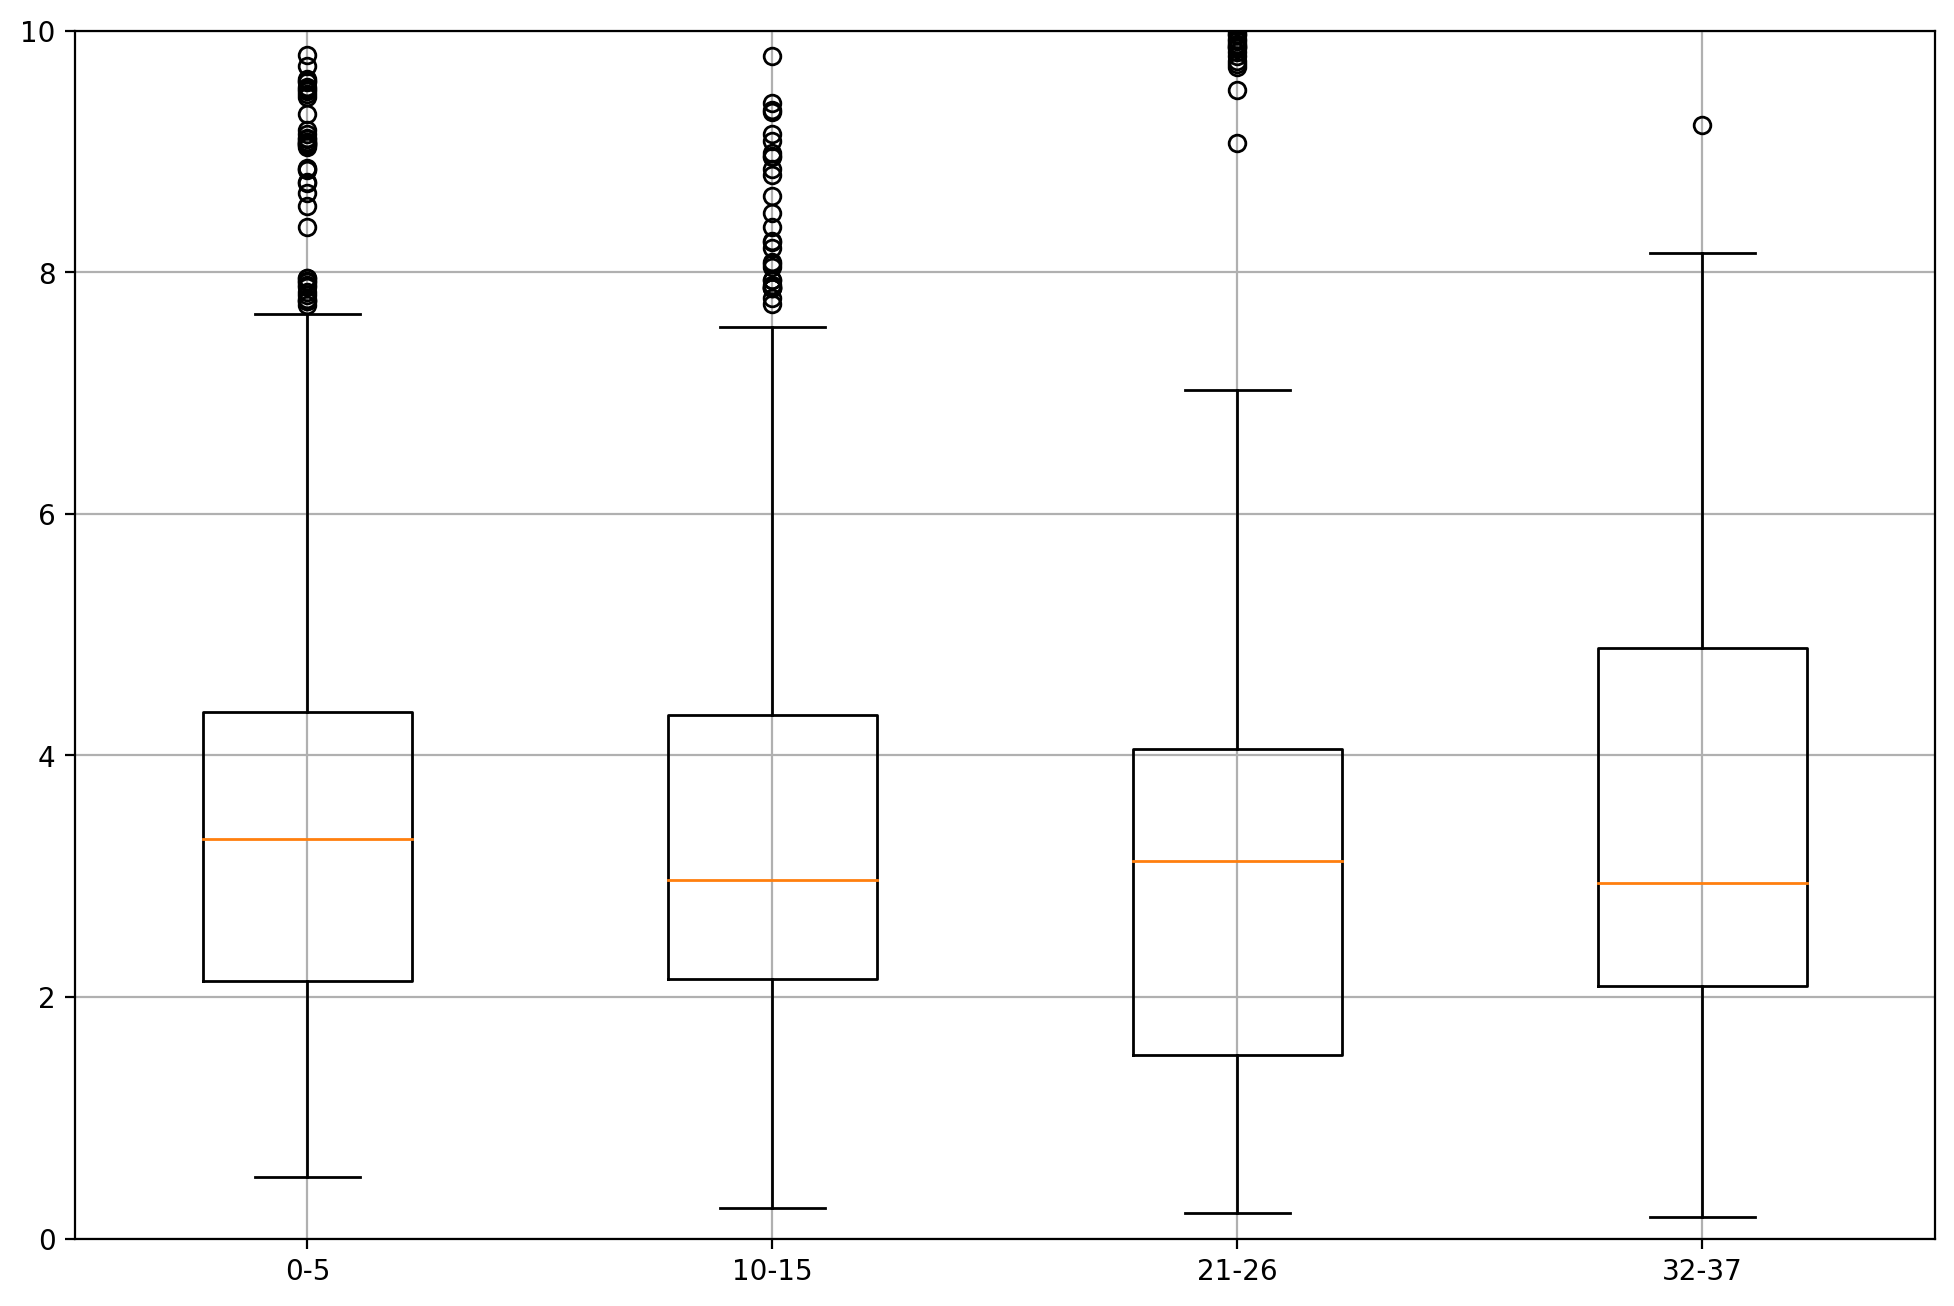

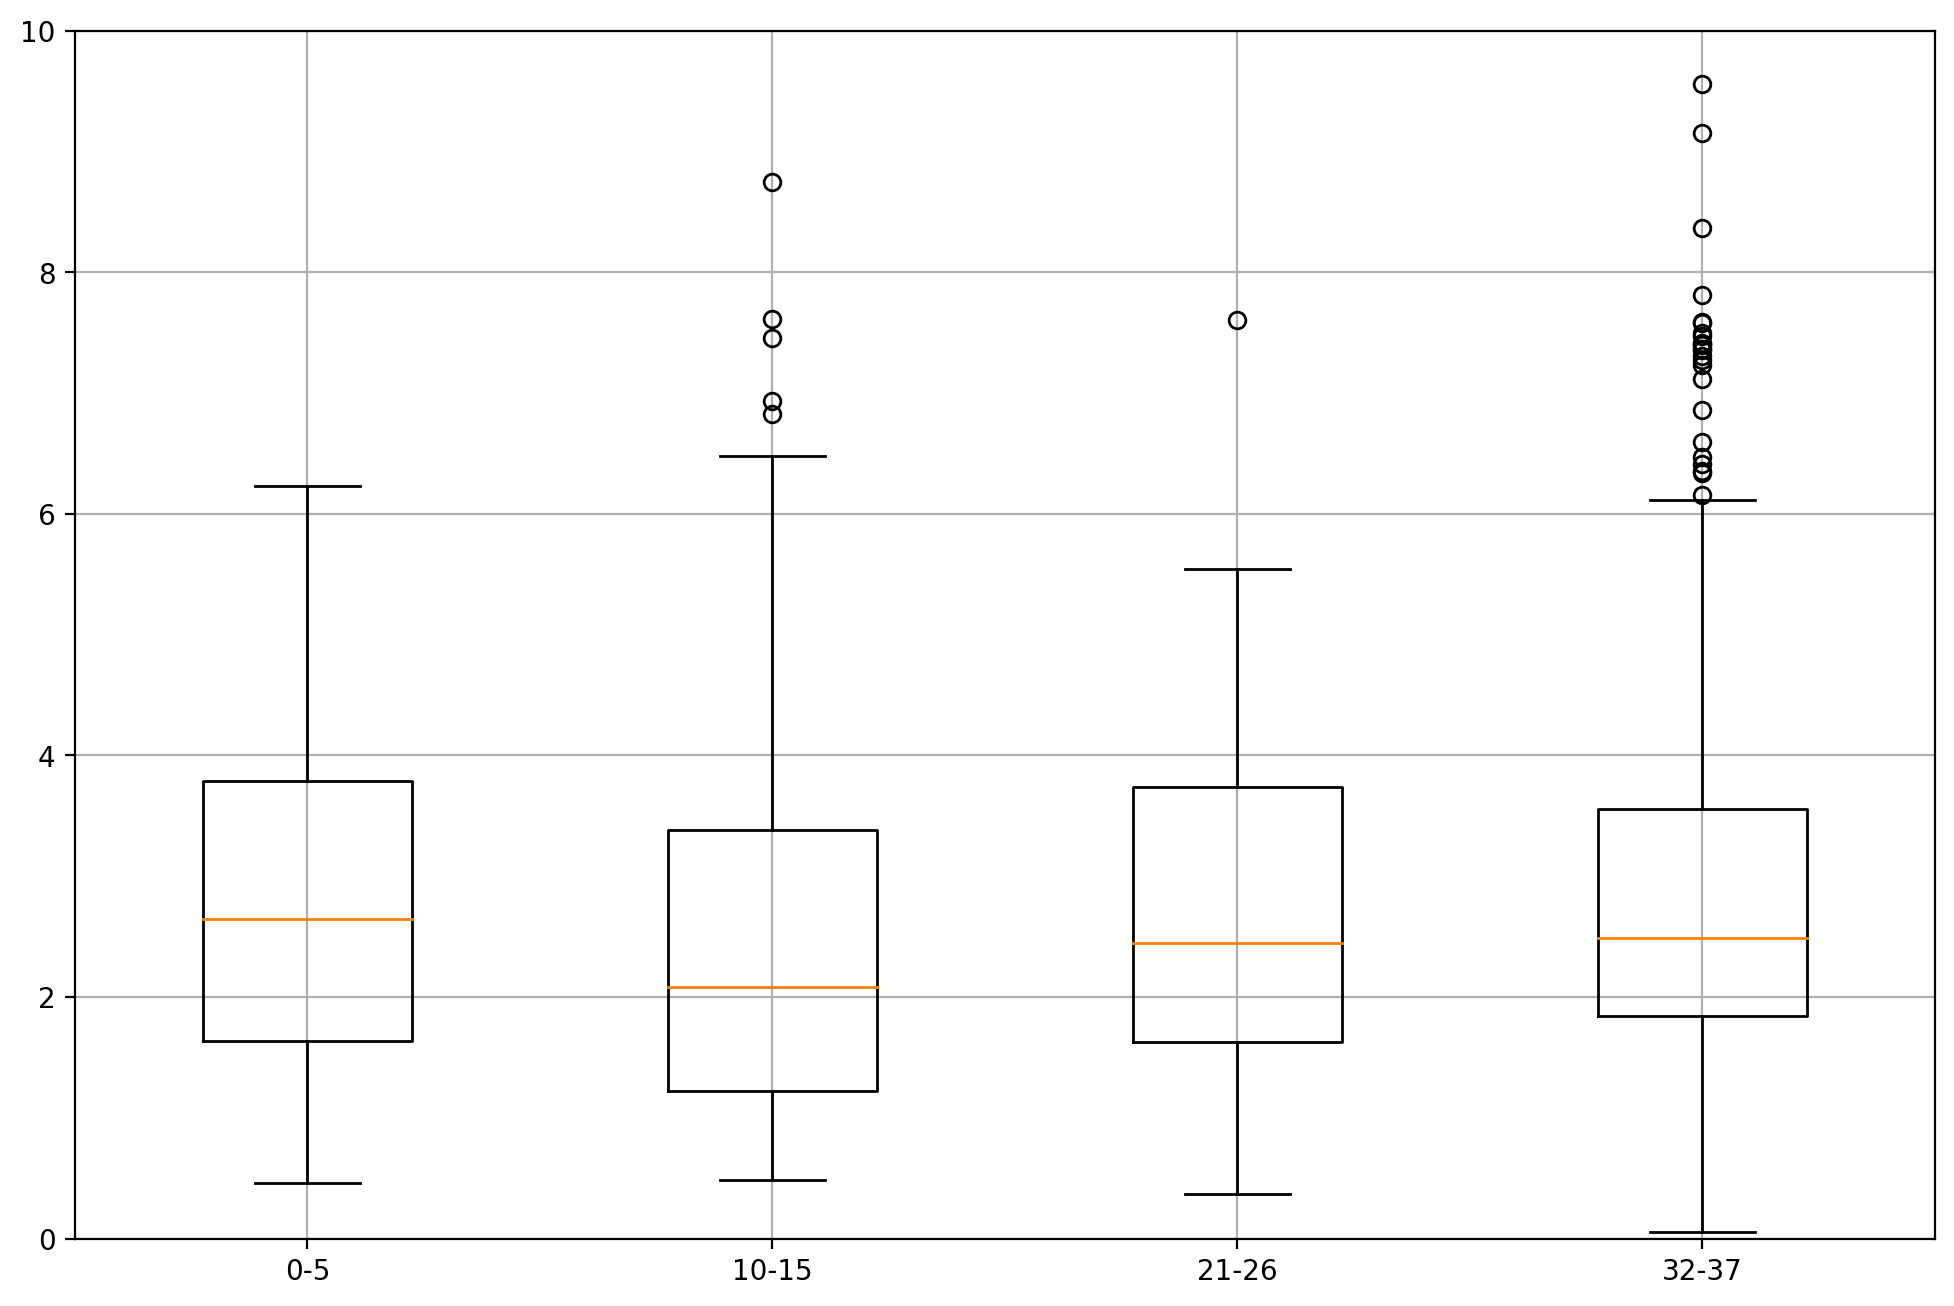

In [6]:
# check the difference between gaze and target through time


def easydist(a1,rr):
    edis = np.sqrt(a1[0]*a1[0]+a1[1]*a1[1])/1000
    
    return(np.degrees(np.arctan(edis/rr[2])))

fig = plt.figure(figsize=(12,8),dpi=200)
for aa in RData:
    for ta,rr in zip(RData[aa]['GPoints_xyz'],RData[aa]['TPoints_xyz']):
        rydat = [easydist(a['righttotarget'],rr) for a in ta if 'righttotarget' in a]
        xdat = [a['timefromstart'] for a in ta if 'righttotarget' in a]
        plt.plot(xdat,rydat,'.',markersize=0.5)
ax = plt.axis()
plt.axis([ax[0],ax[1],0,10])
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(12,8),dpi=200)
rytdat = []
rytind = []
rytstr = []
for ii in range(18):
    rytind.append(0.1+ii/10)
    rytstr.append('{:.1f}'.format(0.1+ii/10))
    rytdat.append([])
for aa in RData:
    for ta,rr in zip(RData[aa]['GPoints_xyz'],RData[aa]['TPoints_xyz']):
        rydat = [easydist(a['righttotarget'],rr) for a in ta if 'righttotarget' in a]
        xdat = [a['timefromstart'] for a in ta if 'righttotarget' in a]
        for i,ryin in enumerate(rytind):
            rytdat[i].extend([a for a,ii in zip(rydat,xdat) if ryin - 0.05 < ii and ryin + 0.05 >= ii])
plt.boxplot(rytdat,labels=rytstr)
ax = plt.axis()
plt.axis([ax[0],ax[1],0,10])
plt.grid(True)
#plt.savefig(r'{:}_right_dist.pdf'.format(fname))
plt.show()

fig = plt.figure(figsize=(12,8),dpi=200)
for aa in RData:
    for ta,rr in zip(RData[aa]['GPoints_xyz'],RData[aa]['TPoints_xyz']):
        lydat = [easydist(a['lefttotarget'],rr) for a in ta if 'lefttotarget' in a]
        xdat = [a['timefromstart'] for a in ta if 'lefttotarget' in a]
        plt.plot(xdat,lydat,'.',markersize=0.5)
ax = plt.axis()
plt.axis([ax[0],ax[1],0,10])
plt.grid(True)
plt.show()
    
fig = plt.figure(figsize=(12,8),dpi=200)
lytdat = []
lytind = []
lytstr = []
for ii in range(18):
    lytind.append(0.1+ii/10)
    lytstr.append('{:.1f}'.format(0.1+ii/10))
    lytdat.append([])
for aa in RData:
    for ta,rr in zip(RData[aa]['GPoints_xyz'],RData[aa]['TPoints_xyz']):
        lydat = [easydist(a['lefttotarget'],rr) for a in ta if 'lefttotarget' in a]
        xdat = [a['timefromstart'] for a in ta if 'lefttotarget' in a]
        for i,lyin in enumerate(lytind):
            lytdat[i].extend([a for a,ii in zip(lydat,xdat) if lyin - 0.05 < ii and lyin + 0.05 >= ii])
plt.boxplot(lytdat,labels=lytstr)
ax = plt.axis()
plt.axis([ax[0],ax[1],0,10])
plt.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    right='off',      # ticks along the bottom edge are off
    left='off',         # ticks along the top edge are off
    labelleft='off')
plt.grid(True)
plt.savefig(r'{:}_left_dist.png'.format(fname))
plt.show()


fig = plt.figure(figsize=(12,8),dpi=200)
rbegdat = [[],[],[],[]]
rbegstr = ['0-5','10-15','21-26','32-37']
for aa in RData:
    for ta,rr in zip(RData[aa]['GPoints_xyz'][0:6],RData[aa]['TPoints_xyz'][0:6]):
        rbegdat[0].extend([easydist(a['righttotarget'],rr) for a in ta if 'righttotarget' in a])
    for ta,rr in zip(RData[aa]['GPoints_xyz'][10:16],RData[aa]['TPoints_xyz'][10:16]):
        rbegdat[1].extend([easydist(a['righttotarget'],rr) for a in ta if 'righttotarget' in a])
    for ta,rr in zip(RData[aa]['GPoints_xyz'][21:27],RData[aa]['TPoints_xyz'][21:27]):
        rbegdat[2].extend([easydist(a['righttotarget'],rr) for a in ta if 'righttotarget' in a])
    for ta,rr in zip(RData[aa]['GPoints_xyz'][-6:],RData[aa]['TPoints_xyz'][-6:]):
        rbegdat[3].extend([easydist(a['righttotarget'],rr) for a in ta if 'righttotarget' in a])
plt.boxplot(rbegdat,labels=rbegstr)
ax = plt.axis()
plt.axis([ax[0],ax[1],0,10])
plt.grid(True)
plt.savefig(r'{:}_right_prog.pdf'.format(fname))
plt.show()

fig = plt.figure(figsize=(12,8),dpi=200)
lbegdat = [[],[],[],[]]
lbegstr = ['0-5','10-15','21-26','32-37']
for aa in RData:
    for ta,rr in zip(RData[aa]['GPoints_xyz'][0:6],RData[aa]['TPoints_xyz'][0:6]):
        lbegdat[0].extend([easydist(a['lefttotarget'],rr) for a in ta if 'lefttotarget' in a])
    for ta,rr in zip(RData[aa]['GPoints_xyz'][10:16],RData[aa]['TPoints_xyz'][10:16]):
        lbegdat[1].extend([easydist(a['lefttotarget'],rr) for a in ta if 'lefttotarget' in a])
    for ta,rr in zip(RData[aa]['GPoints_xyz'][21:27],RData[aa]['TPoints_xyz'][21:27]):
        lbegdat[2].extend([easydist(a['lefttotarget'],rr) for a in ta if 'lefttotarget' in a])
    for ta,rr in zip(RData[aa]['GPoints_xyz'][-6:],RData[aa]['TPoints_xyz'][-6:]):
        lbegdat[3].extend([easydist(a['lefttotarget'],rr) for a in ta if 'lefttotarget' in a])
plt.boxplot(lbegdat,labels=lbegstr)
ax = plt.axis()
plt.axis([ax[0],ax[1],0,10])
plt.grid(True)
plt.savefig(r'{:}_left_prog.pdf'.format(fname))
plt.show()



In [ ]:
# calculate the target measures

TRes = {}
ARes = {}

 

for fname in RData:
    print(fname)
    laccuracies = []
    lprecisions = []
    raccuracies = []
    rprecisions = []
    fig = plt.figure(figsize=(10,10),dpi=200)
    plt.axes().set_aspect('equal')
    print(len(RData[fname]['TPoints_xyz']))
    for i,po in enumerate(RData[fname]['TPoints_xyz']):
        print('point# '+str(i)+', location  '+str(po))
        print('index: '+str(RData[fname]['TPoints_index'][i]))
        print(str(len(RData[fname]['GPoints_xyz'][i]))+' gaze points')
        
        PIndex = RData[fname]['TPoints_index'][i]
        try:
            ARes[PIndex] == 1
        except:
            ARes[PIndex] = {}
        ARes[PIndex]['Location'] = [float(po[0]), float(po[1]), float(po[2])]
        try:
            ARes[PIndex]['LAcc'] == 1
        except:
            ARes[PIndex]['LAcc'] = []
            ARes[PIndex]['RAcc'] = []
            ARes[PIndex]['LPre'] = []
            ARes[PIndex]['RPre'] = []
            
        
        if len(RData[fname]['GPoints_xyz'][i]) < 1:
            continue
        
        # the left gaze locations relative to target
        lx_po = [a['lefttotarget'][0]/1000 for a in RData[fname]['GPoints_xyz'][i] if 'lefttotarget' in a]
        ly_po = [a['lefttotarget'][1]/1000 for a in RData[fname]['GPoints_xyz'][i] if 'lefttotarget' in a]
        lacc = np.sqrt(np.mean(lx_po)**2 + np.mean(ly_po)**2)
        lpre = np.sqrt(np.std(lx_po)**2 + np.std(ly_po)**2)
        print('accuracy (left)  '+str(np.degrees(np.arctan(lacc/po[2])))+' degrees')
        print('precision (left) '+str(np.degrees(np.arctan(lpre/po[2])))+' degrees')
        laccuracies.append(np.degrees(np.arctan(lacc/po[2])))
        lprecisions.append(np.degrees(np.arctan(lpre/po[2])))
        ARes[PIndex]['LAcc'].append(np.degrees(np.arctan(lacc/po[2])))
        ARes[PIndex]['LPre'].append(np.degrees(np.arctan(lpre/po[2])))

        # the right gaze locations relative to target
        rx_po = [a['righttotarget'][0]/1000 for a in RData[fname]['GPoints_xyz'][i] if 'righttotarget' in a]
        ry_po = [a['righttotarget'][1]/1000 for a in RData[fname]['GPoints_xyz'][i] if 'righttotarget' in a]
        racc = np.sqrt(np.mean(rx_po)**2 + np.mean(ry_po)**2)
        rpre = np.sqrt(np.std(rx_po)**2 + np.std(ry_po)**2)
        print('accuracy (right)  '+str(np.degrees(np.arctan(racc/po[2])))+' degrees')
        print('precision (right) '+str(np.degrees(np.arctan(rpre/po[2])))+' degrees')
        raccuracies.append(np.degrees(np.arctan(racc/po[2])))
        rprecisions.append(np.degrees(np.arctan(rpre/po[2])))
        ARes[PIndex]['RAcc'].append(np.degrees(np.arctan(racc/po[2])))
        ARes[PIndex]['RPre'].append(np.degrees(np.arctan(rpre/po[2])))

        # the locations relative to world for drawing
        lx_po_de = [np.degrees(np.arctan((po[0]+a)/po[2])) for a in lx_po]
        ly_po_de = [np.degrees(np.arctan((po[1]+a)/po[2])) for a in ly_po]
        plt.plot(lx_po_de, ly_po_de, '.r',markersize=1.5,label='Left eye')
        rx_po_de = [np.degrees(np.arctan((po[0]+a)/po[2])) for a in rx_po]
        ry_po_de = [np.degrees(np.arctan((po[1]+a)/po[2])) for a in ry_po]
        plt.plot(rx_po_de, ry_po_de, '.g',markersize=1.5,label='Right eye')
        plt.plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),'xk',
                 markersize=5,label='Target')
#        plt.text(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),
#                 str(RData[fname]['TPoints_index'][i]))
        
        
    TRes[fname] = {}
    TRes[fname]['AccuracyL'] = np.median(laccuracies)
    TRes[fname]['PrecisionsL'] = np.median(lprecisions)
    TRes[fname]['AccuracyR'] = np.median(raccuracies)
    TRes[fname]['PrecisionsR'] = np.median(rprecisions)
    TRes[fname]['SpreadAccuracyL'] = spread50(laccuracies)
    TRes[fname]['SpreadPrecisionsL'] = spread50(lprecisions)
    TRes[fname]['SpreadAccuracyR'] = spread50(raccuracies)
    TRes[fname]['SpreadPrecisionsR'] = spread50(rprecisions)
    TRes[fname]['Points'] = len(RData[fname]['TPoints_xyz'])
    print()
    print(fname)
    print('Average accuracy (left): {:.2f} degrees'.format(np.median(laccuracies)))
    print('Average precision (left): {:.2f} degrees'.format(np.median(lprecisions)))
    print('Average accuracy (right): {:.2f} degrees'.format(np.median(raccuracies)))
    print('Average precision (right): {:.2f} degrees'.format(np.median(rprecisions)))
    print('Spread accuracy (left): {:.2f} degrees'.format(spread50(laccuracies)))
    print('Spread precision (left): {:.2f} degrees'.format(spread50(lprecisions)))
    print('Spread accuracy (right): {:.2f} degrees'.format(spread50(raccuracies)))
    print('Spread precision (right): {:.2f} degrees'.format(spread50(rprecisions)))
    plt.title('Distributions of gaze samples ({:})'.format(DataLabel))
    plt.xlabel('x-coordinate in degrees')
    plt.ylabel('y-coordinate in degrees')
    plt.grid(True)
    # plt.legend()
    plt.tight_layout()
    plt.savefig(r'{:}_distr.png'.format(fname))
    plt.show()
        
    
for aa in TRes:
    print(aa)
    print(TRes[aa])






R8logfile_2019-04-24_1336.log
{'AccuracyL': 2.883693370382344, 'PrecisionsL': 0.46333060714619523, 'AccuracyR': 4.553491340965852, 'PrecisionsR': 0.8448128111481799, 'SpreadAccuracyL': 1.960316520409326, 'SpreadPrecisionsL': 0.36600024300143785, 'SpreadAccuracyR': 3.40556286045289, 'SpreadPrecisionsR': 1.2286468413022313, 'Points': 38}
R9logfile_2019-04-24_1501.log
{'AccuracyL': 3.505026269740024, 'PrecisionsL': 0.2618380981085946, 'AccuracyR': 3.4691695828550664, 'PrecisionsR': 0.31548485601302845, 'SpreadAccuracyL': 1.8747329849518084, 'SpreadPrecisionsL': 0.17949973219828033, 'SpreadAccuracyR': 1.7426785781370793, 'SpreadPrecisionsR': 0.31494755434095206, 'Points': 38}
R10logfile_2019-04-24_1511.log
{'AccuracyL': 1.5644478442019893, 'PrecisionsL': 0.28062708962638566, 'AccuracyR': 1.9805953094698605, 'PrecisionsR': 0.29797818708383733, 'SpreadAccuracyL': 1.161096511041201, 'SpreadPrecisionsL': 0.20738732353616018, 'SpreadAccuracyR': 0.8835191191553597, 'SpreadPrecisionsR': 0.2375043

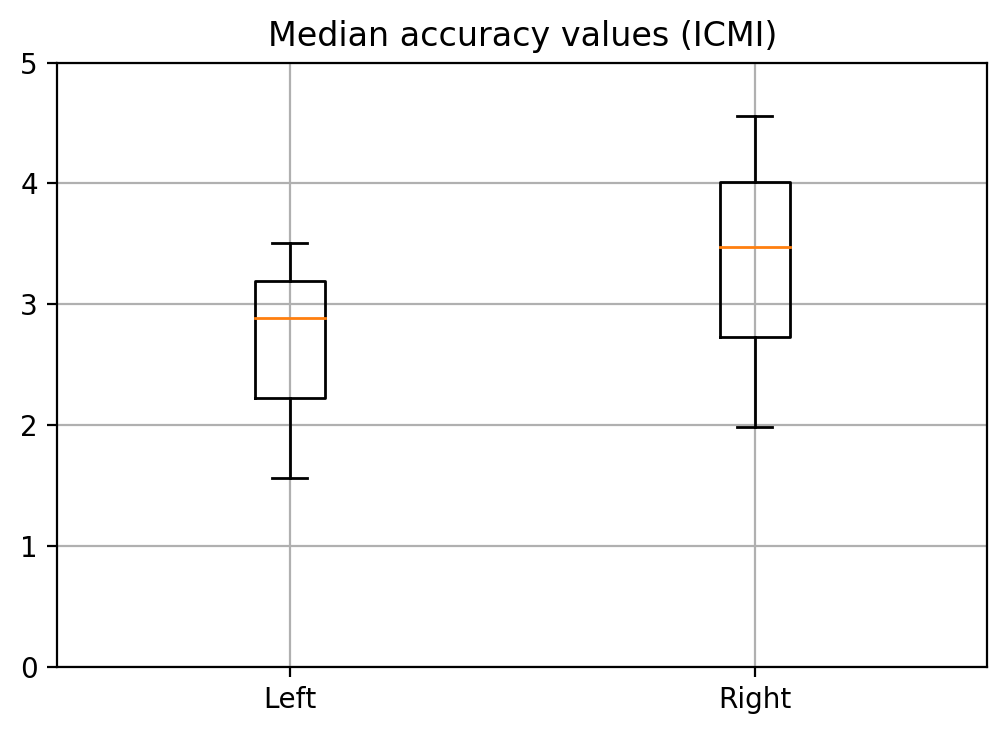

P-value of medians being same 1.000

Left eye precision (median): 0.28
Right eye precision (median): 0.32
Both eyes precision (median): 0.31

Left eye precision (spread 50): 0.10
Right eye precision (spread 50): 0.27
Both eyes precision (spread 50): 0.14

Left eye precision (MAD): 0.07
Right eye precision (MAD): 0.18
Both eyes precision (MAD): 0.13


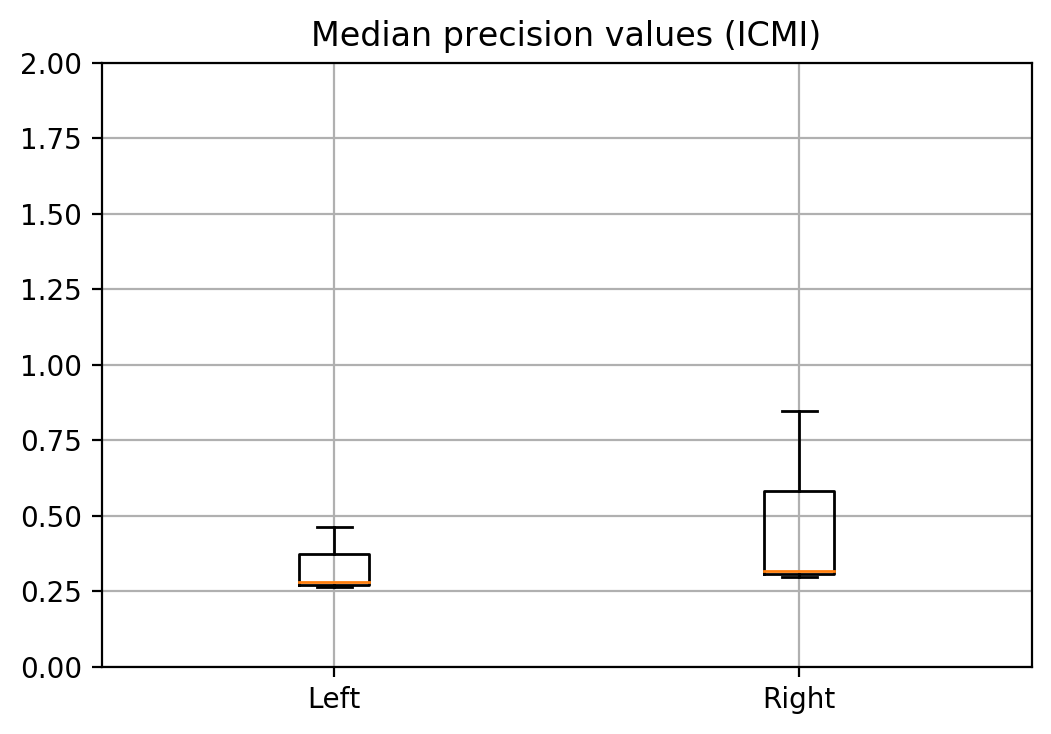

P-value of medians being same 0.601

Total data 76 numbers

Left eye accuracy (median): 2.67
Right eye accuracy (median): 2.93
Both eyes accuracy (median): 2.80

Left eye accuracy (spread 50): 1.34
Right eye accuracy (spread 50): 1.70
Both eyes accuracy (spread 50): 1.59

Left eye accuracy (MAD): 0.83
Right eye accuracy (MAD): 0.93
Both eyes accuracy (MAD): 0.89

Left eye accuracy (CI95): [2.2551348097142094, 3.1034397040381734]
Right eye accuracy (CI95): [2.441163422469298, 3.4985937627729977]
Both eyes accuracy (CI95): [2.397500497050918, 3.126441112152133]


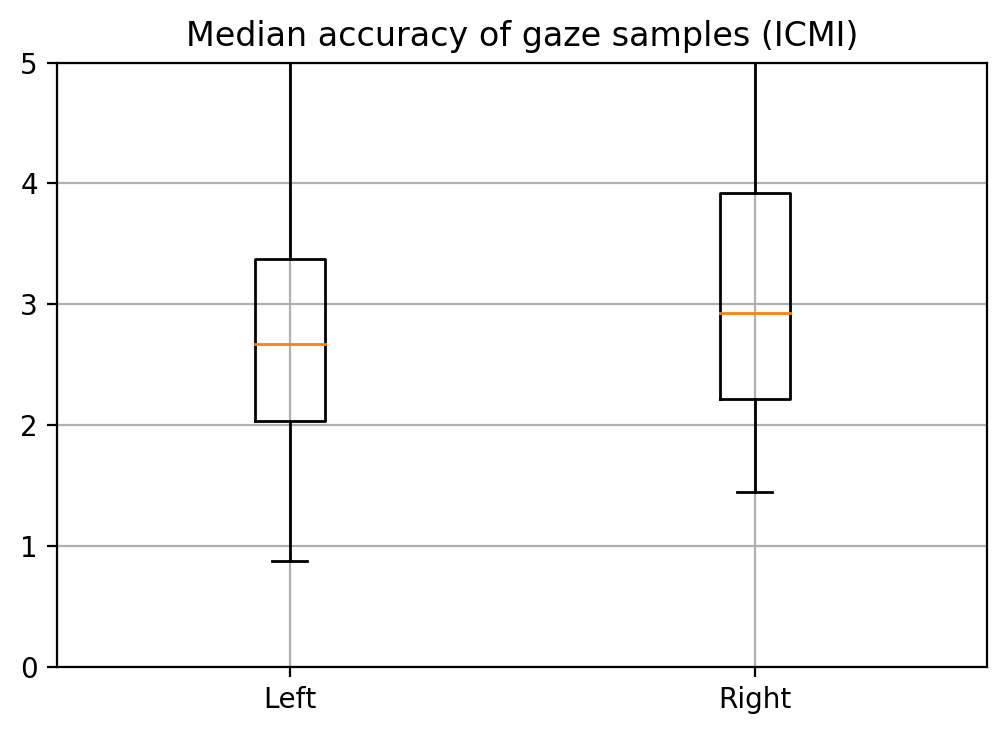

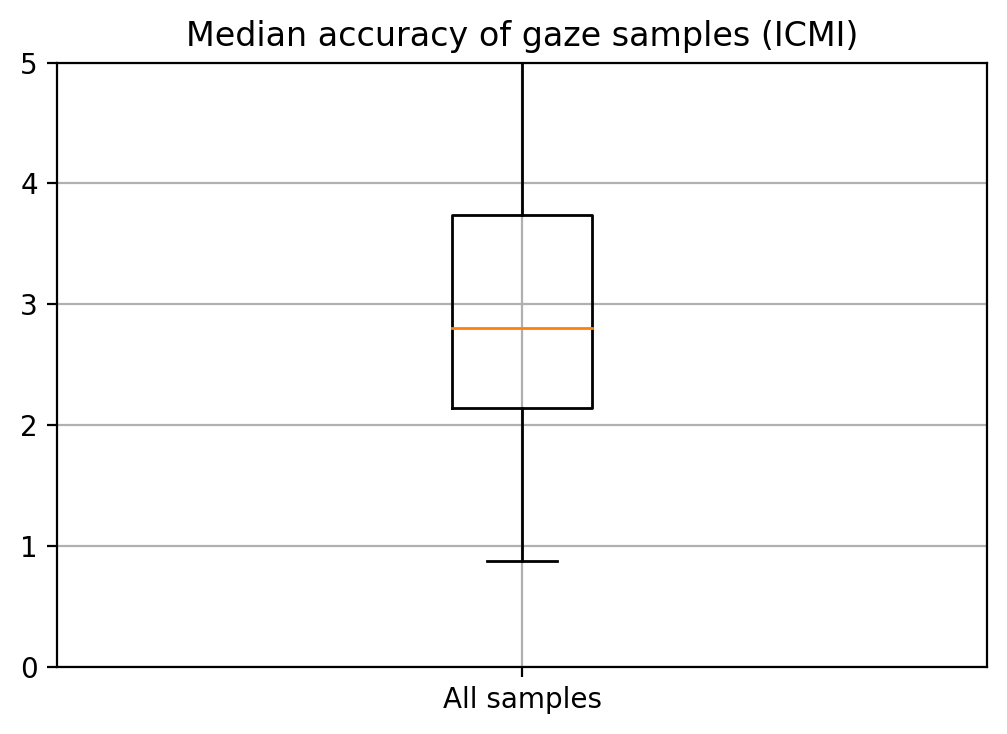


Total data 76 numbers

Left eye precision (median): 0.30
Right eye precision (median): 0.43
Both eyes precision (median): 0.37

Left eye precision (spread 50): 0.18
Right eye precision (spread 50): 0.24
Both eyes precision (spread 50): 0.22

Left eye precision (MAD): 0.12
Right eye precision (MAD): 0.18
Both eyes precision (MAD): 0.16


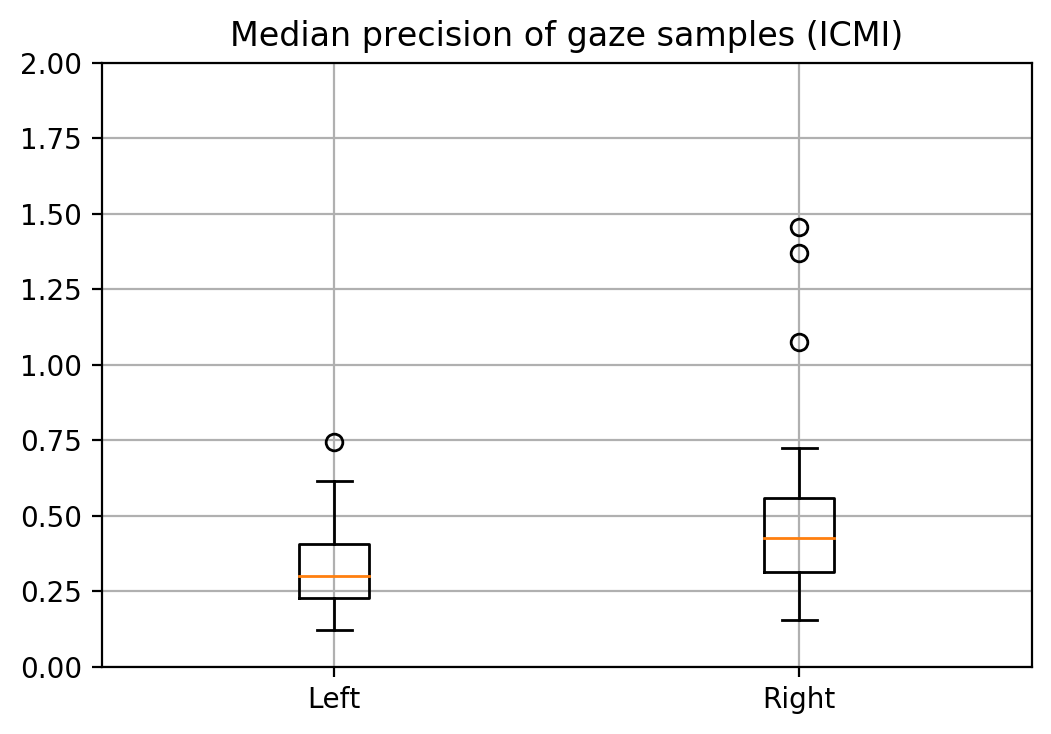


Inner data 52 numbers
Outer data 24 numbers


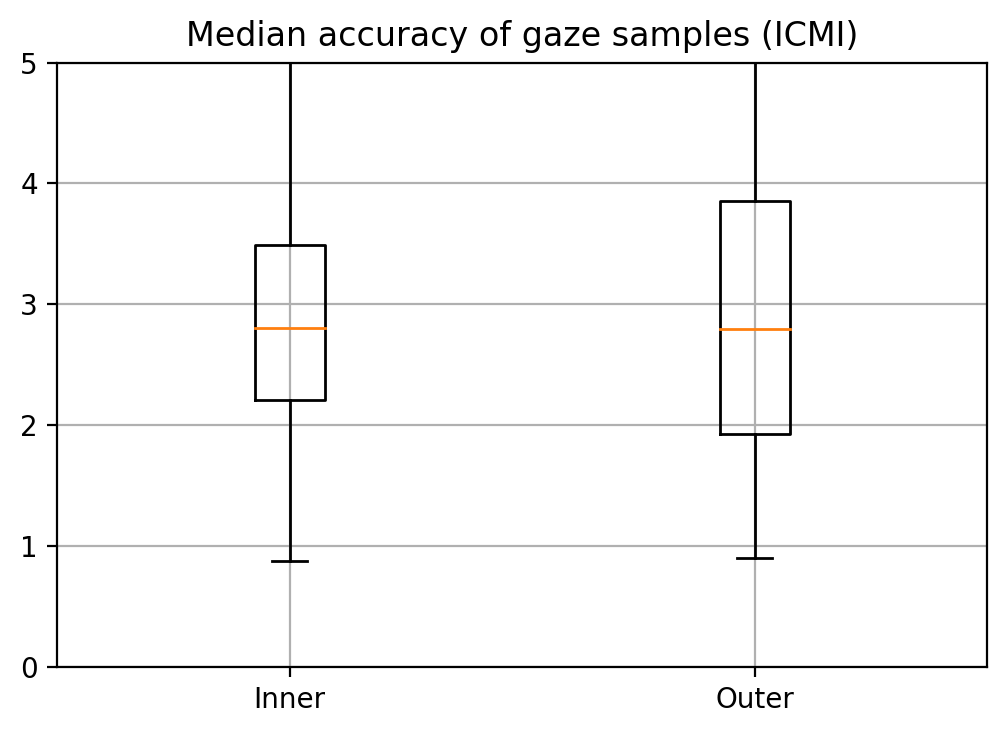

Median accuracy, inner, left eye:  2.67
Median accuracy, inner, right eye: 2.93
Median accuracy, inner, both eyes: 2.80
Spread 50 accuracy, inner, both eyes: 1.28
MAD accuracy, inner, both eyes: 0.83
Median accuracy, outer, left eye:  2.72
Median accuracy, outer, right eye: 2.89
Median accuracy, outer, both eyes: 2.79
MAD accuracy, outer, both eyes: 1.03


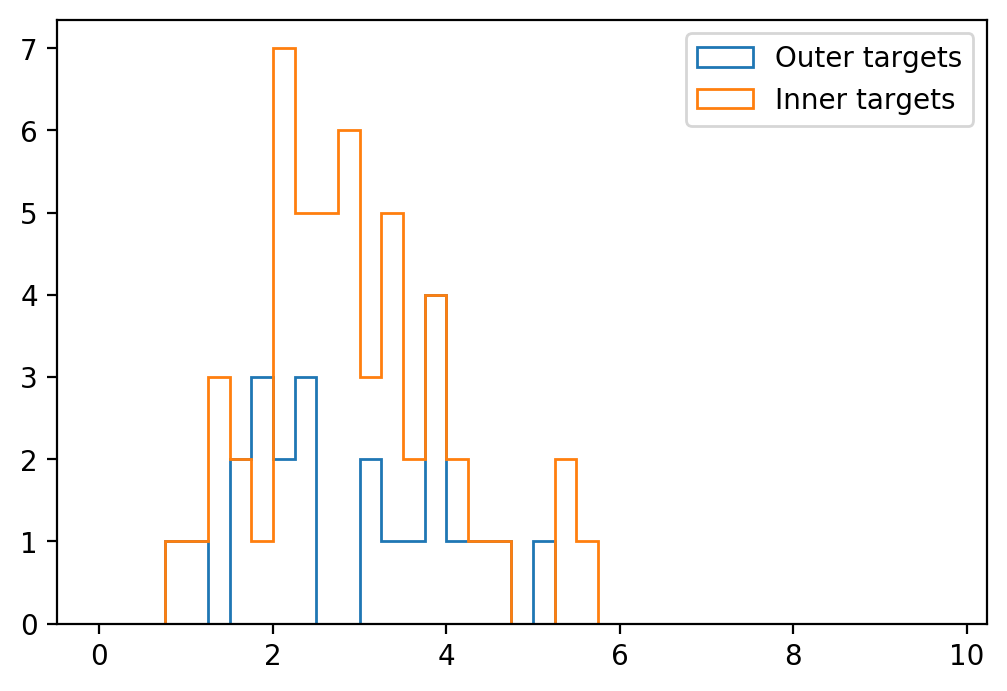

P-value of medians being same: 0.9445

Inner data 52 numbers
Outer data 24 numbers


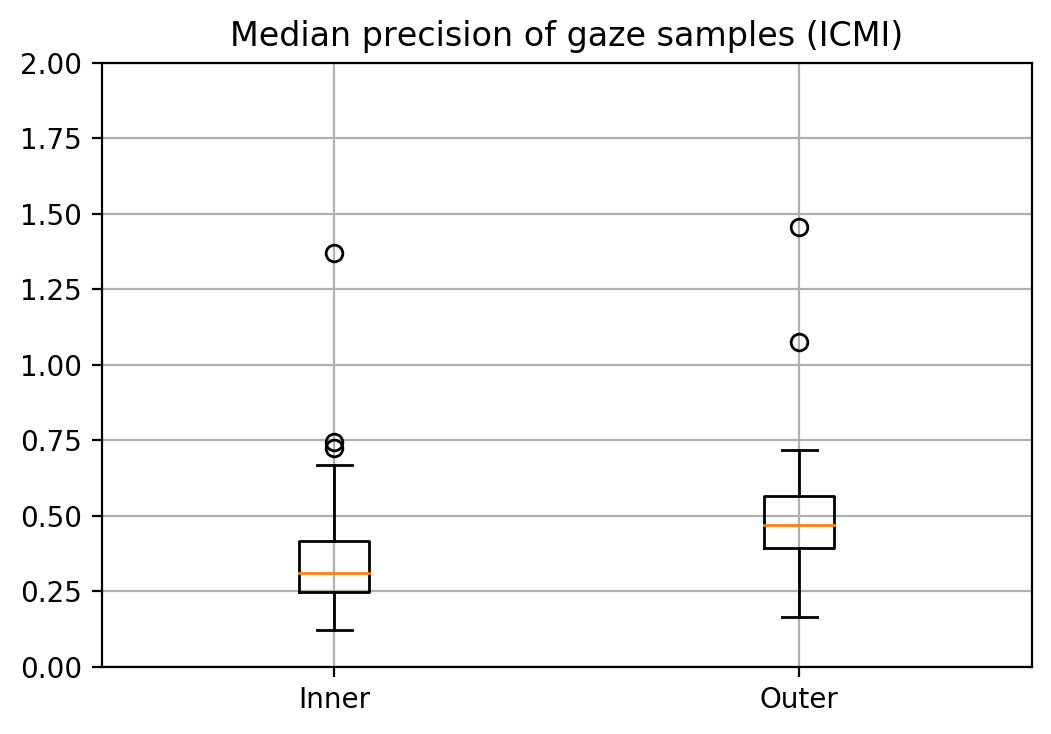

Median precision, inner, left eye:  0.28
Median precision, inner, right eye: 0.35
Median precision, inner, both eyes: 0.31
Spread 50 precision, inner, both eyes: 0.17
MAD precision, inner, both eyes: 0.13
Median precision, outer, left eye:  0.39
Median precision, outer, right eye: 0.53
Median precision, outer, both eyes: 0.47
Spread 50 precision, outer, both eyes: 0.17
MAD precision, outer, both eyes: 0.16


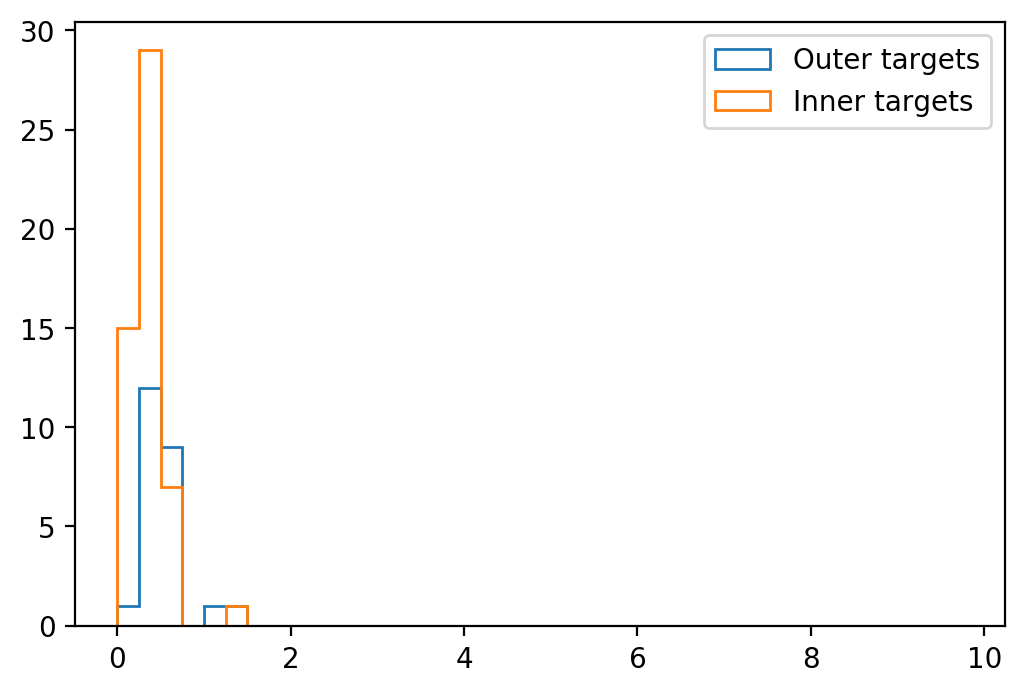

P-value of medians being same: 0.0010

Upper data 48 numbers
Lower data 28 numbers


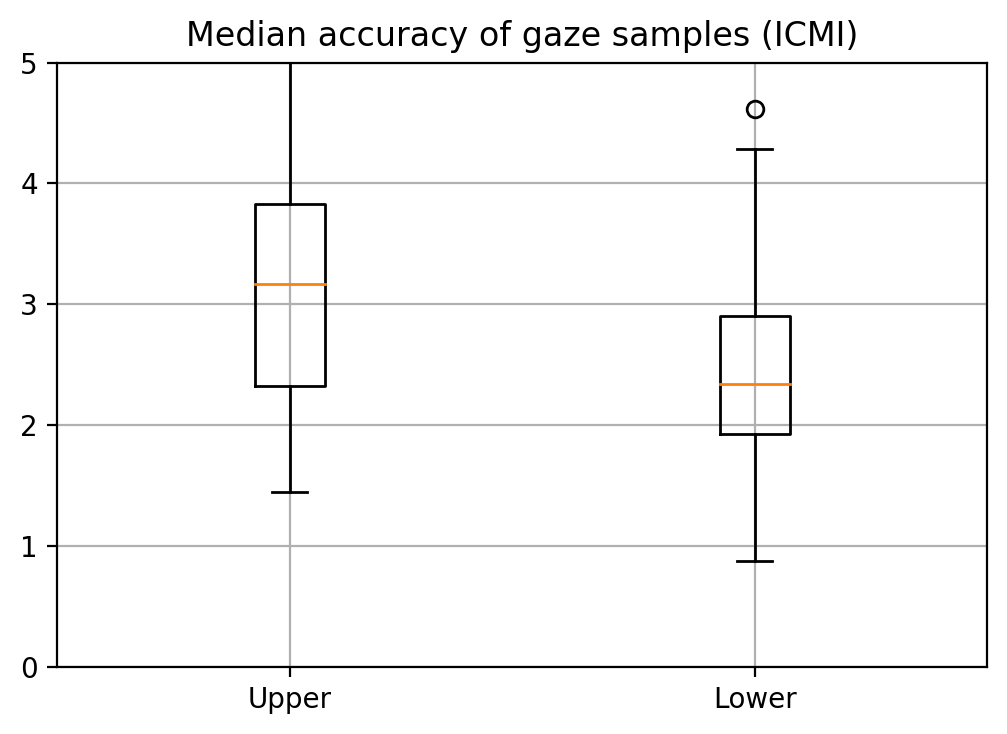

Median accuracy, upper, left eye:  3.11
Median accuracy, upper, right eye: 3.33
Median accuracy, upper, both eyes: 3.17
Spread 50 accuracy, upper, both eyes: 1.50
MAD accuracy, upper, both eyes: 0.83
Median accuracy, lower, left eye:  2.15
Median accuracy, lower, right eye: 2.70
Median accuracy, lower, both eyes: 2.34
Spread 50 accuracy, lower, both eyes: 0.97
MAD accuracy, lower, both eyes: 0.79


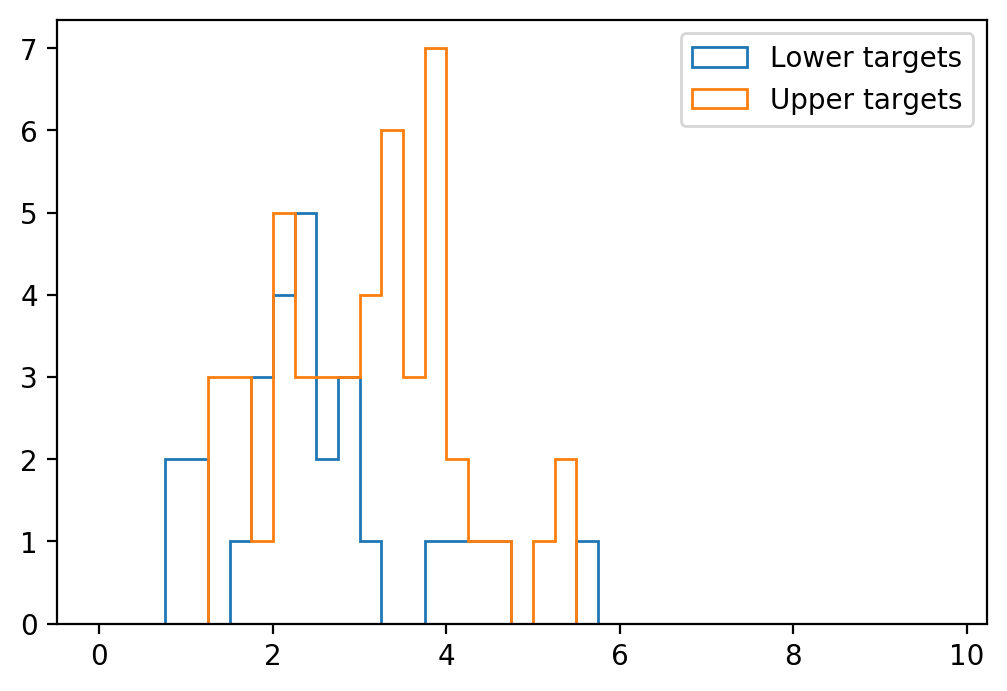

P-value of medians being same: 0.0180

Upper data 48 numbers
Lower data 28 numbers


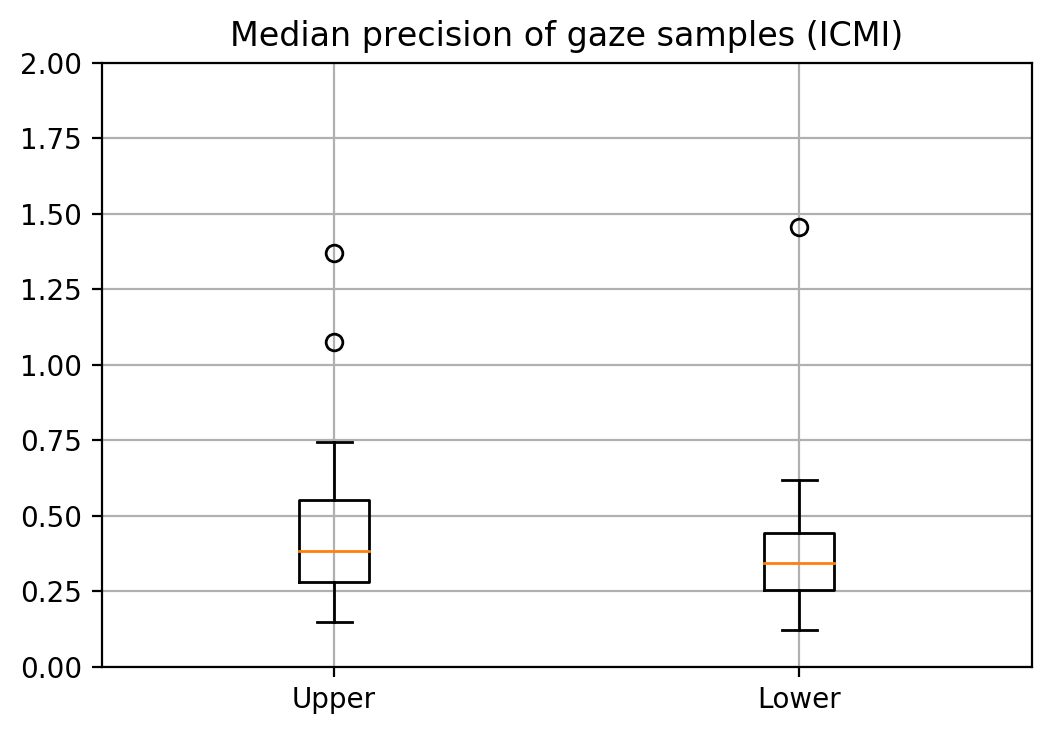

Median precision, upper, left eye:  0.31
Median precision, upper, right eye: 0.43
Median precision, upper, both eyes: 0.38
Spread 50 precision, upper, both eyes: 0.27
MAD precision, upper, both eyes: 0.16
Median precision, lower, left eye:  0.30
Median precision, lower, right eye: 0.42
Median precision, lower, both eyes: 0.34
Spread 50 precision, lower, both eyes: 0.19
MAD precision, lower, both eyes: 0.14


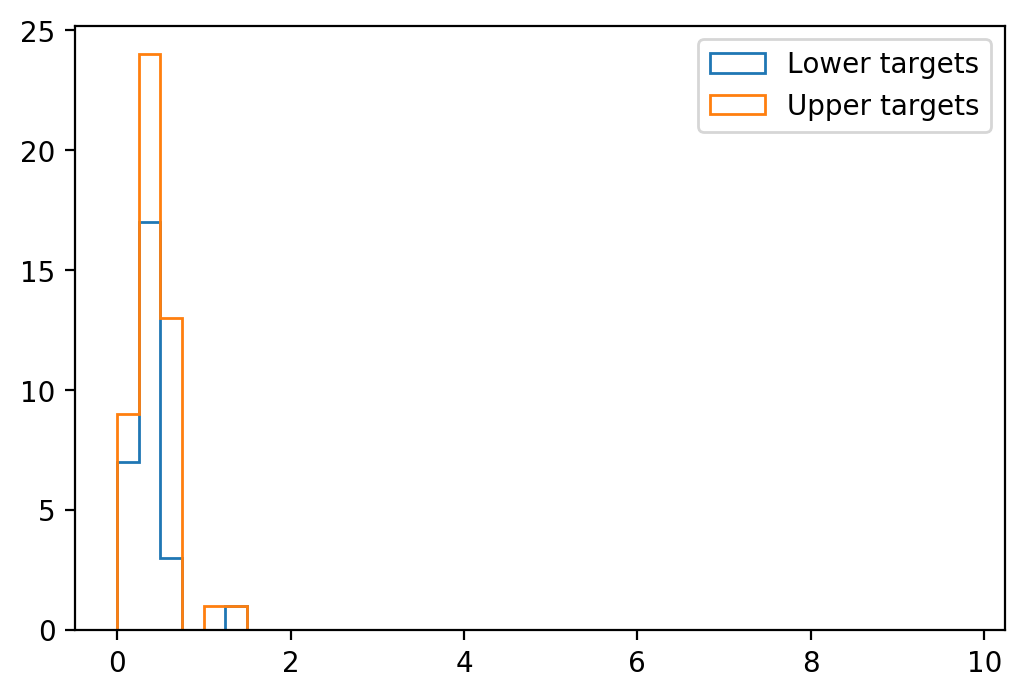

P-value of medians being same: 0.5595


In [8]:
# some analysis of results between people

# see the difference between left and right eyes

for aa in TRes:
    print(aa)
    print(TRes[aa])

AccL = [TRes[a]['AccuracyL'] for a in TRes]
AccR = [TRes[a]['AccuracyR'] for a in TRes]
PreL = [TRes[a]['PrecisionsL'] for a in TRes]
PreR = [TRes[a]['PrecisionsR'] for a in TRes]
#print(AccL,AccR)

#AccL = []
#AccR = []
#PreL = []
#PreR = []
#for aa in ARes:
#    AccL.extend([np.median(ARes[aa]['LAcc'])])
#    AccR.extend([np.median(ARes[aa]['RAcc'])])
#    PreL.extend([np.median(ARes[aa]['LPre'])])
#    PreR.extend([np.median(ARes[aa]['RPre'])])


print()
print('Left eye accuracy (median): {:.2f}'.format(np.median(AccL)))
print('Right eye accuracy (median): {:.2f}'.format(np.median(AccR)))
print('Both eyes accuracy (median): {:.2f}'.format(np.median(AccR+AccL)))
MResults.append('Median accuracy: {:.2f}'.format(np.median(AccR+AccL)))

print()
print('Left eye accuracy (spread 50): {:.2f}'.format(spread50(AccL)))
print('Right eye accuracy (spread 50): {:.2f}'.format(spread50(AccR)))
print('Both eyes accuracy (spread 50): {:.2f}'.format(spread50(AccR+AccL)))
MResults.append('Spread50 of accuracy: {:.2f}'.format(spread50(AccR+AccL)))

print()
print('Left eye accuracy (MAD): {:.2f}'.format(MAD(AccL)))
print('Right eye accuracy (MAD): {:.2f}'.format(MAD(AccR)))
print('Both eyes accuracy (MAD): {:.2f}'.format(MAD(AccR+AccL)))
MResults.append('MAD of accuracy: {:.2f}'.format(MAD(AccR+AccL)))

print()
print('Left eye accuracy (CI95): {:}'.format(CI95(AccL)))
print('Right eye accuracy (CI95): {:}'.format(CI95(AccR)))
print('Both eyes accuracy (CI95): {:}'.format(CI95(AccR+AccL)))
MResults.append('CI95 of accuracy: {:}'.format(CI95(AccR+AccL)))

fig = plt.figure(figsize=(6,4),dpi=200)
plt.title('Median accuracy values ({:})'.format(DataLabel))
plt.boxplot([AccL,AccR],labels=['Left','Right'])
ax = plt.axis()
plt.axis([ax[0],ax[1],0,5])
plt.grid(True)
plt.savefig(r'Median_accuracy_{:}.pdf'.format(DataLabel))
plt.savefig(r'Median_accuracy_{:}.png'.format(DataLabel))
plt.show()

print('P-value of medians being same {:.3f}'.format(diff_check(AccL, AccR)))

print()
print('Left eye precision (median): {:.2f}'.format(np.median(PreL)))
print('Right eye precision (median): {:.2f}'.format(np.median(PreR)))
print('Both eyes precision (median): {:.2f}'.format(np.median(PreR+PreL)))
MResults.append('Median precision: {:.2f}'.format(np.median(PreR+PreL)))

print()
print('Left eye precision (spread 50): {:.2f}'.format(spread50(PreL)))
print('Right eye precision (spread 50): {:.2f}'.format(spread50(PreR)))
print('Both eyes precision (spread 50): {:.2f}'.format(spread50(PreL+PreR)))
MResults.append('Spread50 of precision: {:.2f}'.format(spread50(PreR+PreL)))

print()
print('Left eye precision (MAD): {:.2f}'.format(MAD(PreL)))
print('Right eye precision (MAD): {:.2f}'.format(MAD(PreR)))
print('Both eyes precision (MAD): {:.2f}'.format(MAD(PreL+PreR)))
MResults.append('MAD of precision: {:.2f}'.format(MAD(PreR+PreL)))

fig = plt.figure(figsize=(6,4),dpi=200)
plt.title('Median precision values ({:})'.format(DataLabel))
plt.boxplot([PreL,PreR],labels=['Left','Right'])
ax = plt.axis()
plt.axis([ax[0],ax[1],0,2])
plt.grid(True)
plt.savefig(r'Median_precision_{:}.pdf'.format(DataLabel))
plt.show()

print('P-value of medians being same {:.3f}'.format(diff_check(PreL, PreR)))

# same as above but different clustering

TotalAccuracyL = []
TotalAccuracyR = []

fig = plt.figure(figsize=(6,4),dpi=200)
for aa in ARes:
    TotalAccuracyL.extend([np.median(ARes[aa]['LAcc'])])
    TotalAccuracyR.extend([np.median(ARes[aa]['RAcc'])])
        
print()
print('Total data {} numbers'.format(len(TotalAccuracyL+TotalAccuracyR)))
        
print()
print('Left eye accuracy (median): {:.2f}'.format(np.median(TotalAccuracyL)))
print('Right eye accuracy (median): {:.2f}'.format(np.median(TotalAccuracyR)))
print('Both eyes accuracy (median): {:.2f}'.format(np.median(TotalAccuracyL+TotalAccuracyR)))
MResults.append('Median accuracy2: {:.2f}'.format(np.median(TotalAccuracyL+TotalAccuracyR)))

print()
print('Left eye accuracy (spread 50): {:.2f}'.format(spread50(TotalAccuracyL)))
print('Right eye accuracy (spread 50): {:.2f}'.format(spread50(TotalAccuracyR)))
print('Both eyes accuracy (spread 50): {:.2f}'.format(spread50(TotalAccuracyL+TotalAccuracyR)))
MResults.append('Spread50 of accuracy2: {:.2f}'.format(spread50(TotalAccuracyL+TotalAccuracyR)))

print()
print('Left eye accuracy (MAD): {:.2f}'.format(MAD(TotalAccuracyL)))
print('Right eye accuracy (MAD): {:.2f}'.format(MAD(TotalAccuracyR)))
print('Both eyes accuracy (MAD): {:.2f}'.format(MAD(TotalAccuracyL+TotalAccuracyR)))
MResults.append('MAD of accuracy2: {:.2f}'.format(MAD(TotalAccuracyL+TotalAccuracyR)))

print()
print('Left eye accuracy (CI95): {:}'.format(CI95(TotalAccuracyL)))
print('Right eye accuracy (CI95): {:}'.format(CI95(TotalAccuracyR)))
print('Both eyes accuracy (CI95): {:}'.format(CI95(TotalAccuracyL+TotalAccuracyR)))
MResults.append('CI95 of accuracy2: {:}'.format(CI95(TotalAccuracyL+TotalAccuracyR)))

plt.boxplot([TotalAccuracyL,TotalAccuracyR],labels=['Left','Right'])
plt.title('Median accuracy of gaze samples ({:})'.format(DataLabel))
plt.grid(True)
ax = plt.axis()
plt.axis([ax[0],ax[1],0,5])
plt.savefig(r'Median_accuracy2_{:}.pdf'.format(DataLabel))
plt.show()


fig = plt.figure(figsize=(6,4),dpi=200)
plt.boxplot([TotalAccuracyL+TotalAccuracyR],labels=['All samples'])
plt.title('Median accuracy of gaze samples ({:})'.format(DataLabel))
plt.grid(True)
ax = plt.axis()
plt.axis([ax[0],ax[1],0,5])
plt.savefig(r'Median_accuracy3_{:}.pdf'.format(DataLabel))
plt.show()


TotalPrecisionL = []
TotalPrecisionR = []

fig = plt.figure(figsize=(6,4),dpi=200)
for aa in ARes:
    TotalPrecisionL.extend([np.median(ARes[aa]['LPre'])])
    TotalPrecisionR.extend([np.median(ARes[aa]['RPre'])])
        
print()
print('Total data {} numbers'.format(len(TotalPrecisionL+TotalPrecisionR)))
        
print()
print('Left eye precision (median): {:.2f}'.format(np.median(TotalPrecisionL)))
print('Right eye precision (median): {:.2f}'.format(np.median(TotalPrecisionR)))
print('Both eyes precision (median): {:.2f}'.format(np.median(TotalPrecisionL+TotalPrecisionR)))
MResults.append('Median precision2: {:.2f}'.format(np.median(TotalPrecisionL+TotalPrecisionR)))

print()
print('Left eye precision (spread 50): {:.2f}'.format(spread50(TotalPrecisionL)))
print('Right eye precision (spread 50): {:.2f}'.format(spread50(TotalPrecisionR)))
print('Both eyes precision (spread 50): {:.2f}'.format(spread50(TotalPrecisionL+TotalPrecisionR)))
MResults.append('Spread50 of precision2: {:.2f}'.format(spread50(TotalPrecisionL+TotalPrecisionR)))

print()
print('Left eye precision (MAD): {:.2f}'.format(MAD(TotalPrecisionL)))
print('Right eye precision (MAD): {:.2f}'.format(MAD(TotalPrecisionR)))
print('Both eyes precision (MAD): {:.2f}'.format(MAD(TotalPrecisionL+TotalPrecisionR)))
MResults.append('MAD of precision2: {:.2f}'.format(MAD(TotalPrecisionL+TotalPrecisionR)))

plt.boxplot([TotalPrecisionL,TotalPrecisionR],labels=['Left','Right'])
plt.title('Median precision of gaze samples ({:})'.format(DataLabel))
plt.grid(True)
ax = plt.axis()
plt.axis([ax[0],ax[1],0,2])
plt.savefig(r'Median_precision2_{:}.pdf'.format(DataLabel))
plt.show()


# see the difference between inner and outer regions

citts0 = [0,1,3,6,9,12,13,16,17,20,22,24,26,27,30,33,35,37,  2,5,8,11,18,21,25,31 ]
citts1 = [4,7,10,14,15,19,23,28,29,32,34,36]

for i in range(38):
    if i not in citts0 and i not in citts1:
        print('error: did not find: {:}'.format(i))

InnerAccuracyL = []
InnerAccuracyR = []
OuterAccuracyL = []
OuterAccuracyR = []

fig = plt.figure(figsize=(6,4),dpi=200)
for aa in ARes:
    if aa in citts0:
        InnerAccuracyL.extend([np.median(ARes[aa]['LAcc'])])
        InnerAccuracyR.extend([np.median(ARes[aa]['RAcc'])])
#        InnerAccuracyL.extend(ARes[aa]['LAcc'])
#        InnerAccuracyR.extend(ARes[aa]['RAcc'])
    if aa in citts1:
        OuterAccuracyL.extend([np.median(ARes[aa]['LAcc'])])
        OuterAccuracyR.extend([np.median(ARes[aa]['RAcc'])])
#        OuterAccuracyL.extend(ARes[aa]['LAcc'])
#        OuterAccuracyR.extend(ARes[aa]['RAcc'])
        
print()
print('Inner data {} numbers'.format(len(InnerAccuracyL+InnerAccuracyR)))
print('Outer data {} numbers'.format(len(OuterAccuracyL+OuterAccuracyR)))
        
plt.boxplot([InnerAccuracyL+InnerAccuracyR,OuterAccuracyL+OuterAccuracyR],labels=['Inner','Outer'])
plt.title('Median accuracy of gaze samples ({:})'.format(DataLabel))
plt.grid(True)
ax = plt.axis()
plt.axis([ax[0],ax[1],0,5])
plt.savefig(r'Accur_InOut_{:}.pdf'.format(DataLabel))
plt.show()

print('Median accuracy, inner, left eye:  {:.2f}'.format(np.median(InnerAccuracyL)))
print('Median accuracy, inner, right eye: {:.2f}'.format(np.median(InnerAccuracyR)))
print('Median accuracy, inner, both eyes: {:.2f}'.format(np.median(InnerAccuracyL+InnerAccuracyR)))
print('Spread 50 accuracy, inner, both eyes: {:.2f}'.format(spread50(InnerAccuracyL+InnerAccuracyR)))
print('MAD accuracy, inner, both eyes: {:.2f}'.format(MAD(InnerAccuracyL+InnerAccuracyR)))
print('Median accuracy, outer, left eye:  {:.2f}'.format(np.median(OuterAccuracyL)))
print('Median accuracy, outer, right eye: {:.2f}'.format(np.median(OuterAccuracyR)))
print('Median accuracy, outer, both eyes: {:.2f}'.format(np.median(OuterAccuracyL+OuterAccuracyR)))
print('MAD accuracy, outer, both eyes: {:.2f}'.format(MAD(OuterAccuracyL+OuterAccuracyR)))

MResults.append('Median accuracy, inner: {:.2f}'.format(np.median(InnerAccuracyL+InnerAccuracyR)))
MResults.append('Spread50 of accuracy, inner: {:.2f}'.format(spread50(InnerAccuracyL+InnerAccuracyR)))
MResults.append('MAD of accuracy, inner: {:.2f}'.format(MAD(InnerAccuracyL+InnerAccuracyR)))
MResults.append('Median accuracy, outer: {:.2f}'.format(np.median(OuterAccuracyL+OuterAccuracyR)))
MResults.append('Spread50 of accuracy, outer: {:.2f}'.format(spread50(OuterAccuracyL+OuterAccuracyR)))
MResults.append('MAD of accuracy, outer: {:.2f}'.format(MAD(OuterAccuracyL+OuterAccuracyR)))


binlims = [a/4.0 for a in range(40)]

fig = plt.figure(figsize=(6,4),dpi=200)
plt.hist(OuterAccuracyL+OuterAccuracyR,bins=binlims, label='Outer targets',histtype='step')
plt.hist(InnerAccuracyL+InnerAccuracyR,bins=binlims, label='Inner targets',histtype='step')
plt.legend()
plt.show()
print('P-value of medians being same: {:.4f}'.format((diff_check(InnerAccuracyL+InnerAccuracyR,OuterAccuracyL+OuterAccuracyR))))


InnerPrecisionL = []
InnerPrecisionR = []
OuterPrecisionL = []
OuterPrecisionR = []

fig = plt.figure(figsize=(6,4),dpi=200)
for aa in ARes:
    if aa in citts0:
        InnerPrecisionL.extend([np.median(ARes[aa]['LPre'])])
        InnerPrecisionR.extend([np.median(ARes[aa]['RPre'])])
#        InnerPrecisionL.extend(ARes[aa]['LPre'])
#        InnerPrecisionR.extend(ARes[aa]['RPre'])
    if aa in citts1:
        OuterPrecisionL.extend([np.median(ARes[aa]['LPre'])])
        OuterPrecisionR.extend([np.median(ARes[aa]['RPre'])])
#        OuterPrecisionL.extend(ARes[aa]['LPre'])
#        OuterPrecisionR.extend(ARes[aa]['RPre'])
        
print()
print('Inner data {} numbers'.format(len(InnerPrecisionL+InnerPrecisionR)))
print('Outer data {} numbers'.format(len(OuterPrecisionL+OuterPrecisionR)))
        
plt.boxplot([InnerPrecisionL+InnerPrecisionR,OuterPrecisionL+OuterPrecisionR],labels=['Inner','Outer'])
plt.title('Median precision of gaze samples ({:})'.format(DataLabel))
plt.grid(True)
ax = plt.axis()
plt.axis([ax[0],ax[1],0,2])
plt.savefig(r'Preci_InOut_{:}.pdf'.format(DataLabel))
plt.show()

print('Median precision, inner, left eye:  {:.2f}'.format(np.median(InnerPrecisionL)))
print('Median precision, inner, right eye: {:.2f}'.format(np.median(InnerPrecisionR)))
print('Median precision, inner, both eyes: {:.2f}'.format(np.median(InnerPrecisionL+InnerPrecisionR)))
print('Spread 50 precision, inner, both eyes: {:.2f}'.format(spread50(InnerPrecisionL+InnerPrecisionR)))
print('MAD precision, inner, both eyes: {:.2f}'.format(MAD(InnerPrecisionL+InnerPrecisionR)))
print('Median precision, outer, left eye:  {:.2f}'.format(np.median(OuterPrecisionL)))
print('Median precision, outer, right eye: {:.2f}'.format(np.median(OuterPrecisionR)))
print('Median precision, outer, both eyes: {:.2f}'.format(np.median(OuterPrecisionL+OuterPrecisionR)))
print('Spread 50 precision, outer, both eyes: {:.2f}'.format(spread50(OuterPrecisionL+OuterPrecisionR)))
print('MAD precision, outer, both eyes: {:.2f}'.format(MAD(OuterPrecisionL+OuterPrecisionR)))

MResults.append('Median precision, inner: {:.2f}'.format(np.median(InnerPrecisionL+InnerPrecisionR)))
MResults.append('Spread50 of precision, inner: {:.2f}'.format(spread50(InnerPrecisionL+InnerPrecisionR)))
MResults.append('MAD of precision, inner: {:.2f}'.format(MAD(InnerPrecisionL+InnerPrecisionR)))
MResults.append('Median precision, outer: {:.2f}'.format(np.median(OuterPrecisionL+OuterPrecisionR)))
MResults.append('Spread50 of precision, outer: {:.2f}'.format(spread50(OuterPrecisionL+OuterPrecisionR)))
MResults.append('MAD of precision, outer: {:.2f}'.format(MAD(OuterPrecisionL+OuterPrecisionR)))

binlims = [a/4.0 for a in range(40)]

fig = plt.figure(figsize=(6,4),dpi=200)
plt.hist(OuterPrecisionL+OuterPrecisionR,bins=binlims, label='Outer targets',histtype='step')
plt.hist(InnerPrecisionL+InnerPrecisionR,bins=binlims, label='Inner targets',histtype='step')
plt.legend()
plt.show()
print('P-value of medians being same: {:.4f}'.format((diff_check(InnerPrecisionL+InnerPrecisionR,OuterPrecisionL+OuterPrecisionR))))


# see the difference between upper and lower regions

ditts0 = [0,1,3,5,7,8,9,13,14,15,16,20,21,22,23,24,25,29,30,31,32,34,35,37]
ditts1 = [2,4,6,10,11,12,17,18,19,26,27,28,33,36]

for i in range(38):
    if i not in ditts0 and i not in ditts1:
        print('error: did not find: {:}'.format(i))

UpperAccuracyL = []
UpperAccuracyR = []
LowerAccuracyL = []
LowerAccuracyR = []

fig = plt.figure(figsize=(6,4),dpi=200)
for aa in ARes:
    if aa in ditts0:
        UpperAccuracyL.extend([np.median(ARes[aa]['LAcc'])])
        UpperAccuracyR.extend([np.median(ARes[aa]['RAcc'])])
#        UpperAccuracyL.extend(ARes[aa]['LAcc'])
#        UpperAccuracyR.extend(ARes[aa]['RAcc'])
    if aa in ditts1:
        LowerAccuracyL.extend([np.median(ARes[aa]['LAcc'])])
        LowerAccuracyR.extend([np.median(ARes[aa]['RAcc'])])
#        LowerAccuracyL.extend(ARes[aa]['LAcc'])
#        LowerAccuracyR.extend(ARes[aa]['RAcc'])
        
print()
print('Upper data {} numbers'.format(len(UpperAccuracyL+UpperAccuracyR)))
print('Lower data {} numbers'.format(len(LowerAccuracyL+LowerAccuracyR)))
        
plt.boxplot([UpperAccuracyL+UpperAccuracyR,LowerAccuracyL+LowerAccuracyR],labels=['Upper','Lower'])
plt.title('Median accuracy of gaze samples ({:})'.format(DataLabel))
plt.grid(True)
ax = plt.axis()
plt.axis([ax[0],ax[1],0,5])
plt.savefig(r'Accur_UpLow_{:}.pdf'.format(DataLabel))
plt.show()

print('Median accuracy, upper, left eye:  {:.2f}'.format(np.median(UpperAccuracyL)))
print('Median accuracy, upper, right eye: {:.2f}'.format(np.median(UpperAccuracyR)))
print('Median accuracy, upper, both eyes: {:.2f}'.format(np.median(UpperAccuracyL+UpperAccuracyR)))
print('Spread 50 accuracy, upper, both eyes: {:.2f}'.format(spread50(UpperAccuracyL+UpperAccuracyR)))
print('MAD accuracy, upper, both eyes: {:.2f}'.format(MAD(UpperAccuracyL+UpperAccuracyR)))
print('Median accuracy, lower, left eye:  {:.2f}'.format(np.median(LowerAccuracyL)))
print('Median accuracy, lower, right eye: {:.2f}'.format(np.median(LowerAccuracyR)))
print('Median accuracy, lower, both eyes: {:.2f}'.format(np.median(LowerAccuracyL+LowerAccuracyR)))
print('Spread 50 accuracy, lower, both eyes: {:.2f}'.format(spread50(LowerAccuracyL+LowerAccuracyR)))
print('MAD accuracy, lower, both eyes: {:.2f}'.format(MAD(LowerAccuracyL+LowerAccuracyR)))

MResults.append('Median accuracy, upper: {:.2f}'.format(np.median(UpperAccuracyL+UpperAccuracyR)))
MResults.append('Spread50 of accuracy, upper: {:.2f}'.format(spread50(UpperAccuracyL+UpperAccuracyR)))
MResults.append('MAD of accuracy, upper: {:.2f}'.format(MAD(UpperAccuracyL+UpperAccuracyR)))
MResults.append('Median accuracy, lower: {:.2f}'.format(np.median(LowerAccuracyL+LowerAccuracyR)))
MResults.append('Spread50 of accuracy, lower: {:.2f}'.format(spread50(LowerAccuracyL+LowerAccuracyR)))
MResults.append('MAD of accuracy, lower: {:.2f}'.format(MAD(LowerAccuracyL+LowerAccuracyR)))


binlims = [a/4.0 for a in range(40)]

fig = plt.figure(figsize=(6,4),dpi=200)
plt.hist(LowerAccuracyL+LowerAccuracyR,bins=binlims, label='Lower targets',histtype='step')
plt.hist(UpperAccuracyL+UpperAccuracyR,bins=binlims, label='Upper targets',histtype='step')
plt.legend()
plt.show()
print('P-value of medians being same: {:.4f}'.format((diff_check(UpperAccuracyL+UpperAccuracyR,LowerAccuracyL+LowerAccuracyR))))


UpperPrecisionL = []
UpperPrecisionR = []
LowerPrecisionL = []
LowerPrecisionR = []

fig = plt.figure(figsize=(6,4),dpi=200)
for aa in ARes:
    if aa in ditts0:
        UpperPrecisionL.extend([np.median(ARes[aa]['LPre'])])
        UpperPrecisionR.extend([np.median(ARes[aa]['RPre'])])
#        UpperPrecisionL.extend(ARes[aa]['LPre'])
#        UpperPrecisionR.extend(ARes[aa]['RPre'])
    if aa in ditts1:
        LowerPrecisionL.extend([np.median(ARes[aa]['LPre'])])
        LowerPrecisionR.extend([np.median(ARes[aa]['RPre'])])
#        LowerPrecisionL.extend(ARes[aa]['LPre'])
#        LowerPrecisionR.extend(ARes[aa]['RPre'])
        
print()
print('Upper data {} numbers'.format(len(UpperPrecisionL+UpperPrecisionR)))
print('Lower data {} numbers'.format(len(LowerPrecisionL+LowerPrecisionR)))
        
plt.boxplot([UpperPrecisionL+UpperPrecisionR,LowerPrecisionL+LowerPrecisionR],labels=['Upper','Lower'])
plt.title('Median precision of gaze samples ({:})'.format(DataLabel))
plt.grid(True)
ax = plt.axis()
plt.axis([ax[0],ax[1],0,2])
plt.savefig(r'Preci_UpLow_{:}.pdf'.format(DataLabel))
plt.show()

print('Median precision, upper, left eye:  {:.2f}'.format(np.median(UpperPrecisionL)))
print('Median precision, upper, right eye: {:.2f}'.format(np.median(UpperPrecisionR)))
print('Median precision, upper, both eyes: {:.2f}'.format(np.median(UpperPrecisionL+UpperPrecisionR)))
print('Spread 50 precision, upper, both eyes: {:.2f}'.format(spread50(UpperPrecisionL+UpperPrecisionR)))
print('MAD precision, upper, both eyes: {:.2f}'.format(MAD(UpperPrecisionL+UpperPrecisionR)))
print('Median precision, lower, left eye:  {:.2f}'.format(np.median(LowerPrecisionL)))
print('Median precision, lower, right eye: {:.2f}'.format(np.median(LowerPrecisionR)))
print('Median precision, lower, both eyes: {:.2f}'.format(np.median(LowerPrecisionL+LowerPrecisionR)))
print('Spread 50 precision, lower, both eyes: {:.2f}'.format(spread50(LowerPrecisionL+LowerPrecisionR)))
print('MAD precision, lower, both eyes: {:.2f}'.format(MAD(LowerPrecisionL+LowerPrecisionR)))

MResults.append('Median precision, upper: {:.2f}'.format(np.median(UpperPrecisionL+UpperPrecisionR)))
MResults.append('Spread50 of precision, upper: {:.2f}'.format(spread50(UpperPrecisionL+UpperPrecisionR)))
MResults.append('MAD of precision, upper: {:.2f}'.format(MAD(UpperPrecisionL+UpperPrecisionR)))
MResults.append('Median precision, lower: {:.2f}'.format(np.median(LowerPrecisionL+LowerPrecisionR)))
MResults.append('Spread50 of precision, lower: {:.2f}'.format(spread50(LowerPrecisionL+LowerPrecisionR)))
MResults.append('MAD of precision, lower: {:.2f}'.format(MAD(LowerPrecisionL+LowerPrecisionR)))

binlims = [a/4.0 for a in range(40)]

fig = plt.figure(figsize=(6,4),dpi=200)
plt.hist(LowerPrecisionL+LowerPrecisionR,bins=binlims, label='Lower targets',histtype='step')
plt.hist(UpperPrecisionL+UpperPrecisionR,bins=binlims, label='Upper targets',histtype='step')
plt.legend()
plt.show()
print('P-value of medians being same: {:.4f}'.format((diff_check(UpperPrecisionL+UpperPrecisionR,LowerPrecisionL+LowerPrecisionR))))





ARes = {0: {'Location': [0.0, 0.0, 1.0], 'LAcc': [2.4416141014554382, 5.391871961060859, 3.126441112152133], 'RAcc': [5.336667881886082, 7.462004409752195, 3.646123546297861], 'LPre': [1.0143976300252846, 0.7429176003644503, 0.2224216138427629], 'RPre': [1.5460721642852893, 0.722808272021483, 0.47917347995931103]}, 1: {'Location': [0.1232568, 0.1232568, 1.992389], 'LAcc': [4.196150486904872, 4.873524865155107, 2.1701750904210453], 'RAcc': [9.18285144811548, 3.5192060459305585, 2.52537734444673], 'LPre': [0.41012480739234425, 0.21458671902792634, 0.8389037106838879], 'RPre': [0.8407448769394179, 0.6008347494612202, 0.6664026379197018]}, 2: {'Location': [0.4911511, -0.4911513, 3.939231], 'LAcc': [4.1664905819466105, 2.838597111632123, 1.213652791780919], 'RAcc': [4.380937860662054, 2.122048813238715, 1.928854202430422], 'LPre': [0.9070695449558434, 0.4161494374236471, 0.39531963606858994], 'RPre': [2.6365468453103915, 0.20270011246781416, 0.3091455140960802]}, 3: {'Location': [-0.308142

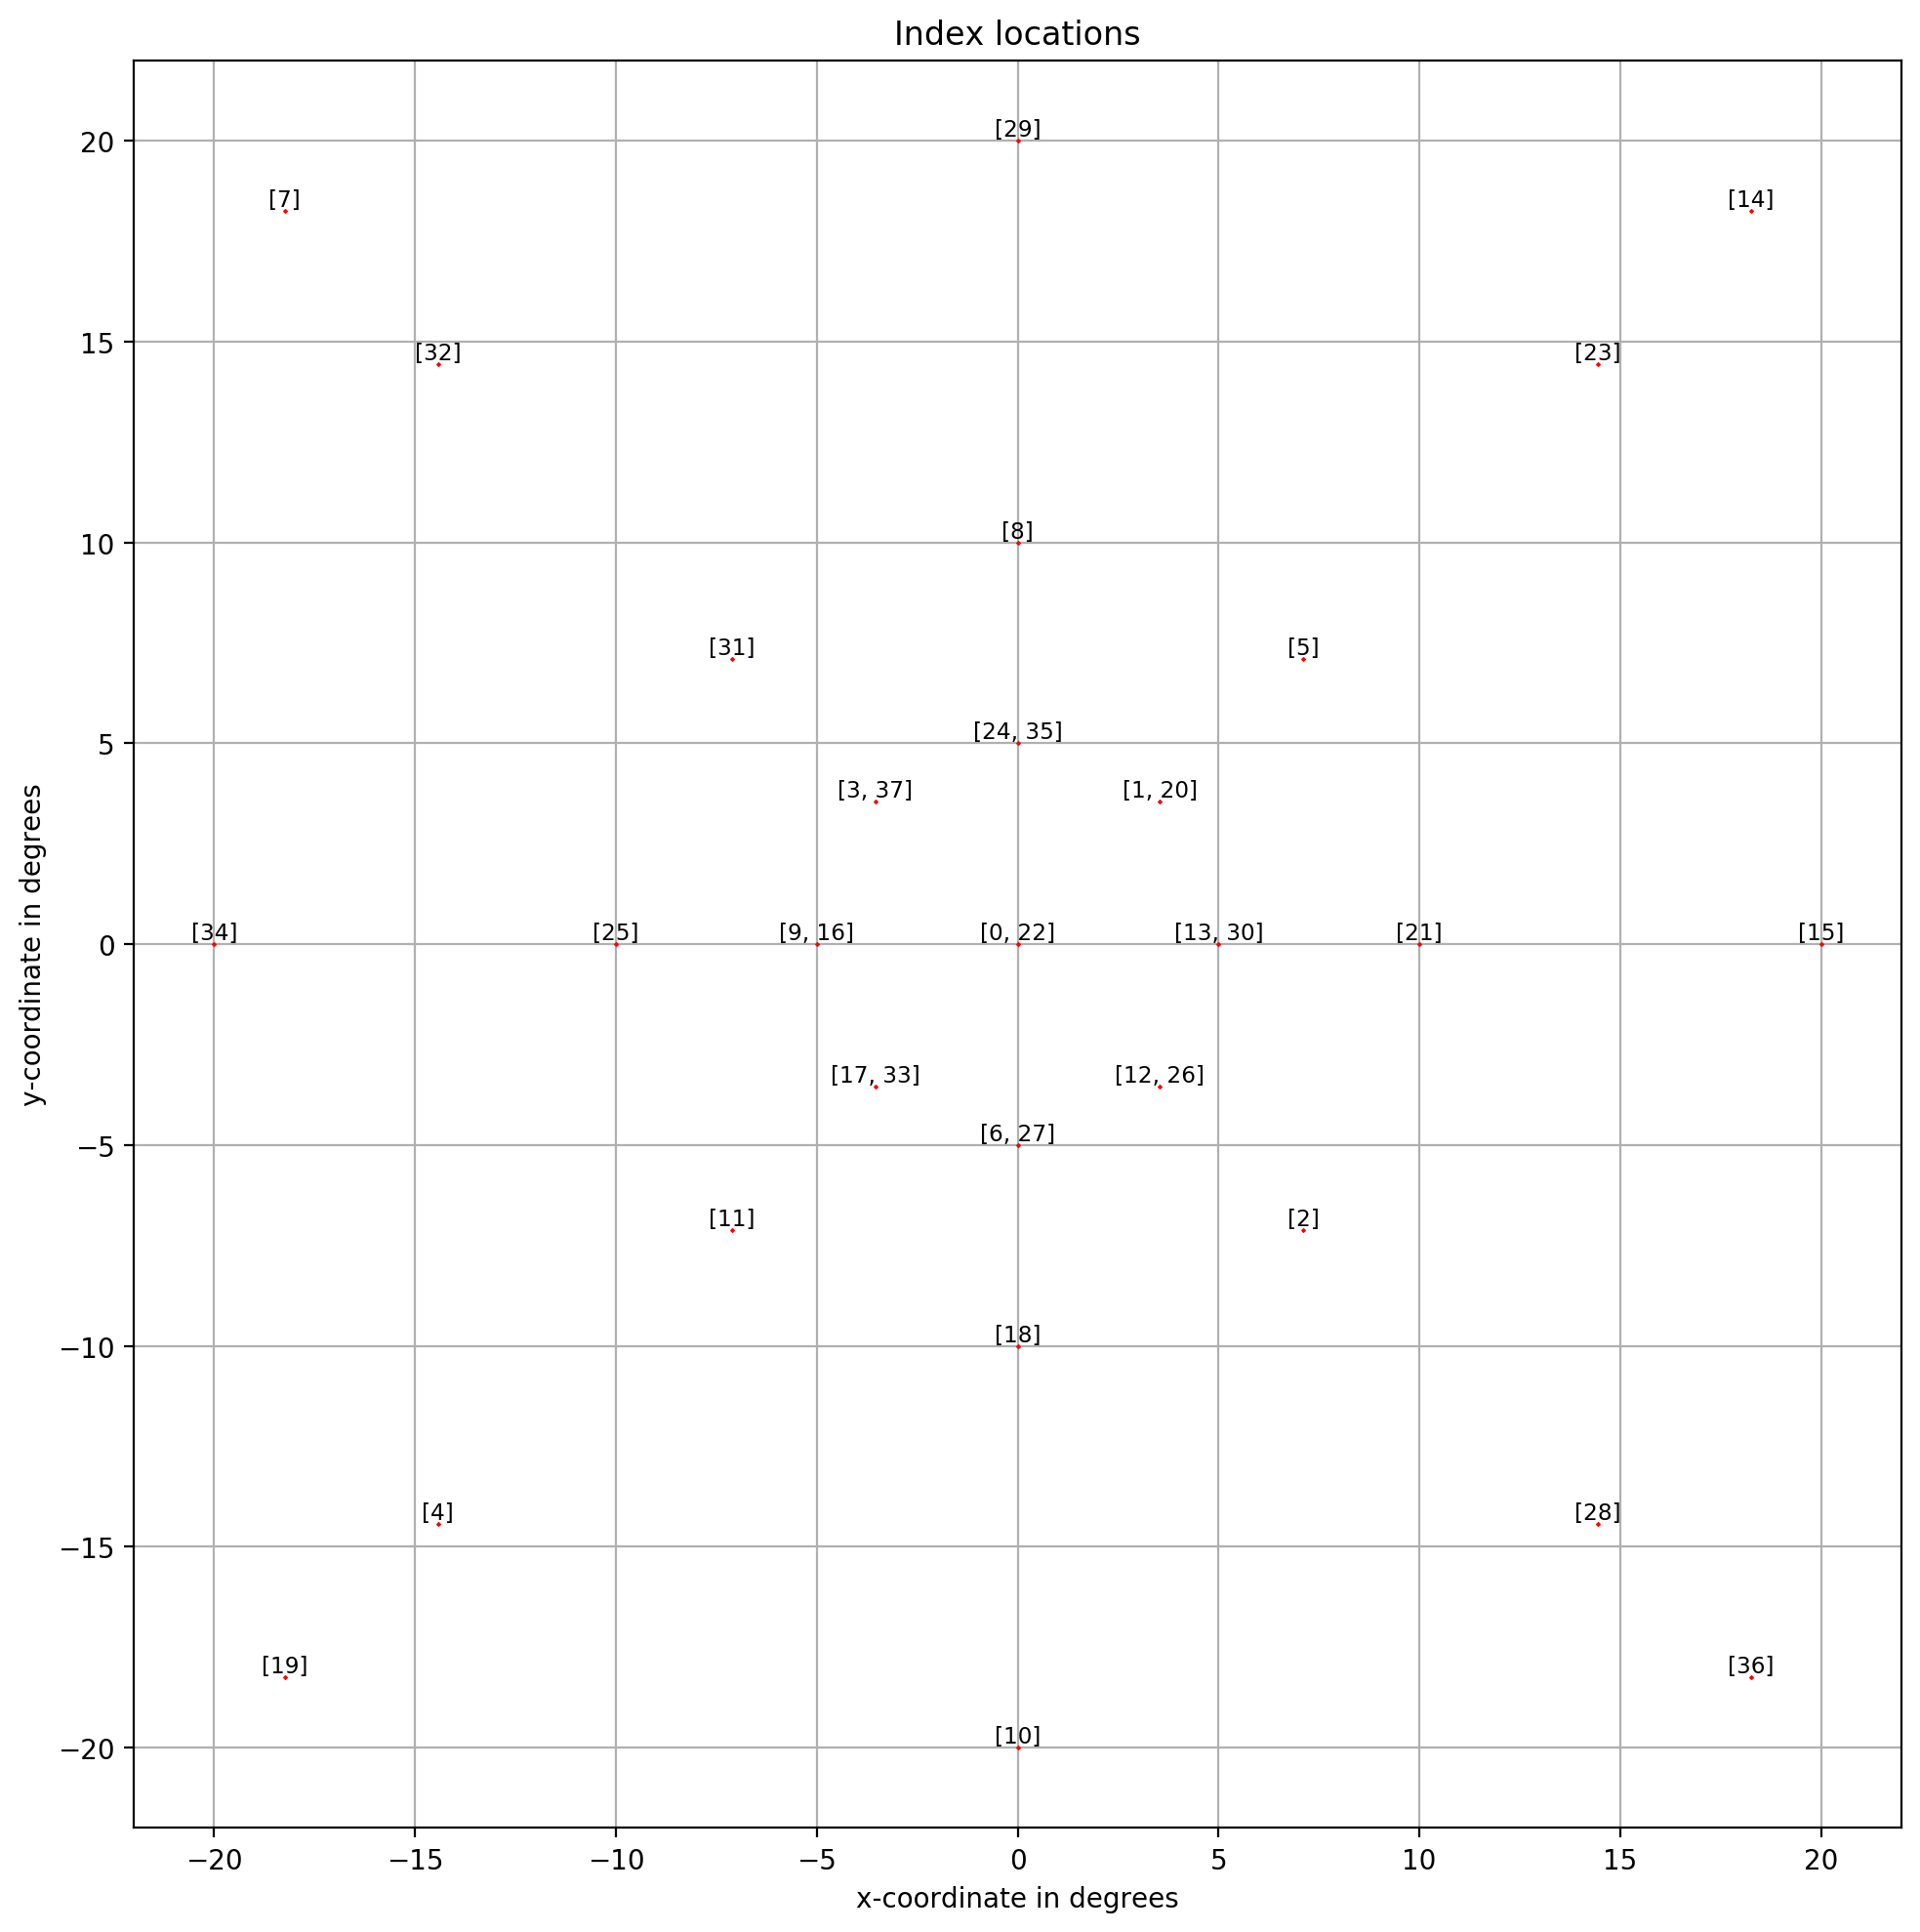

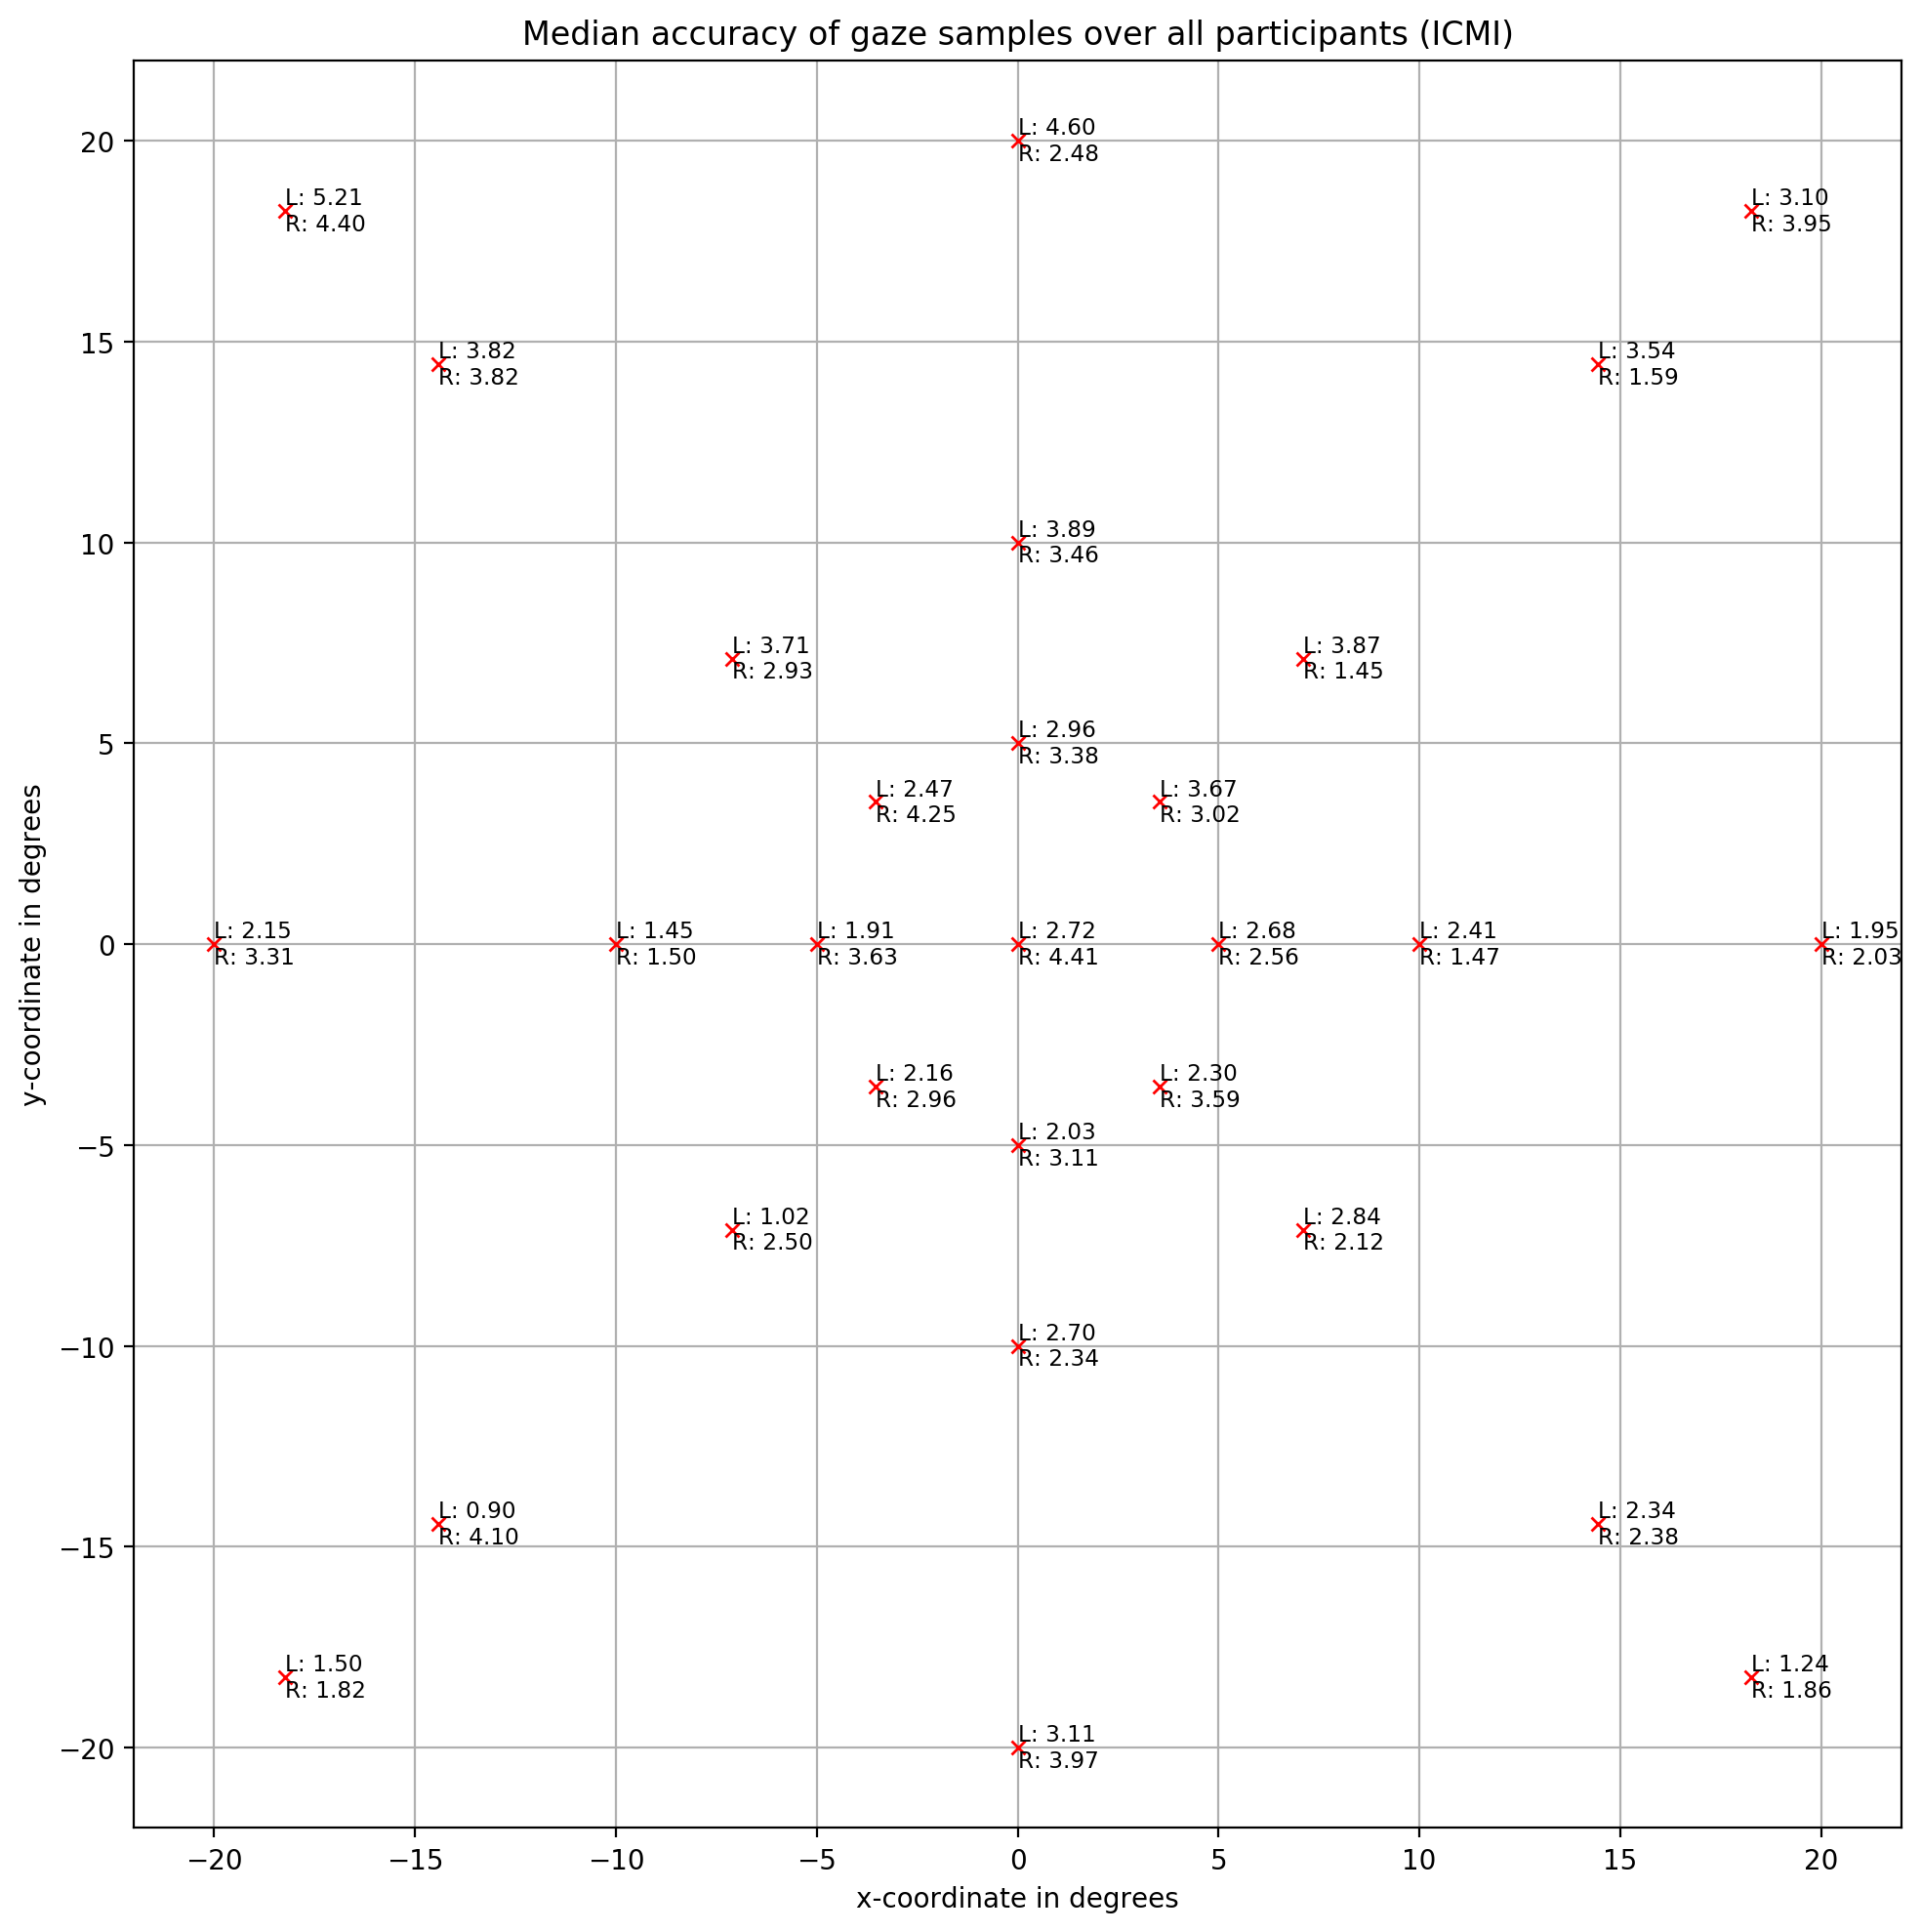

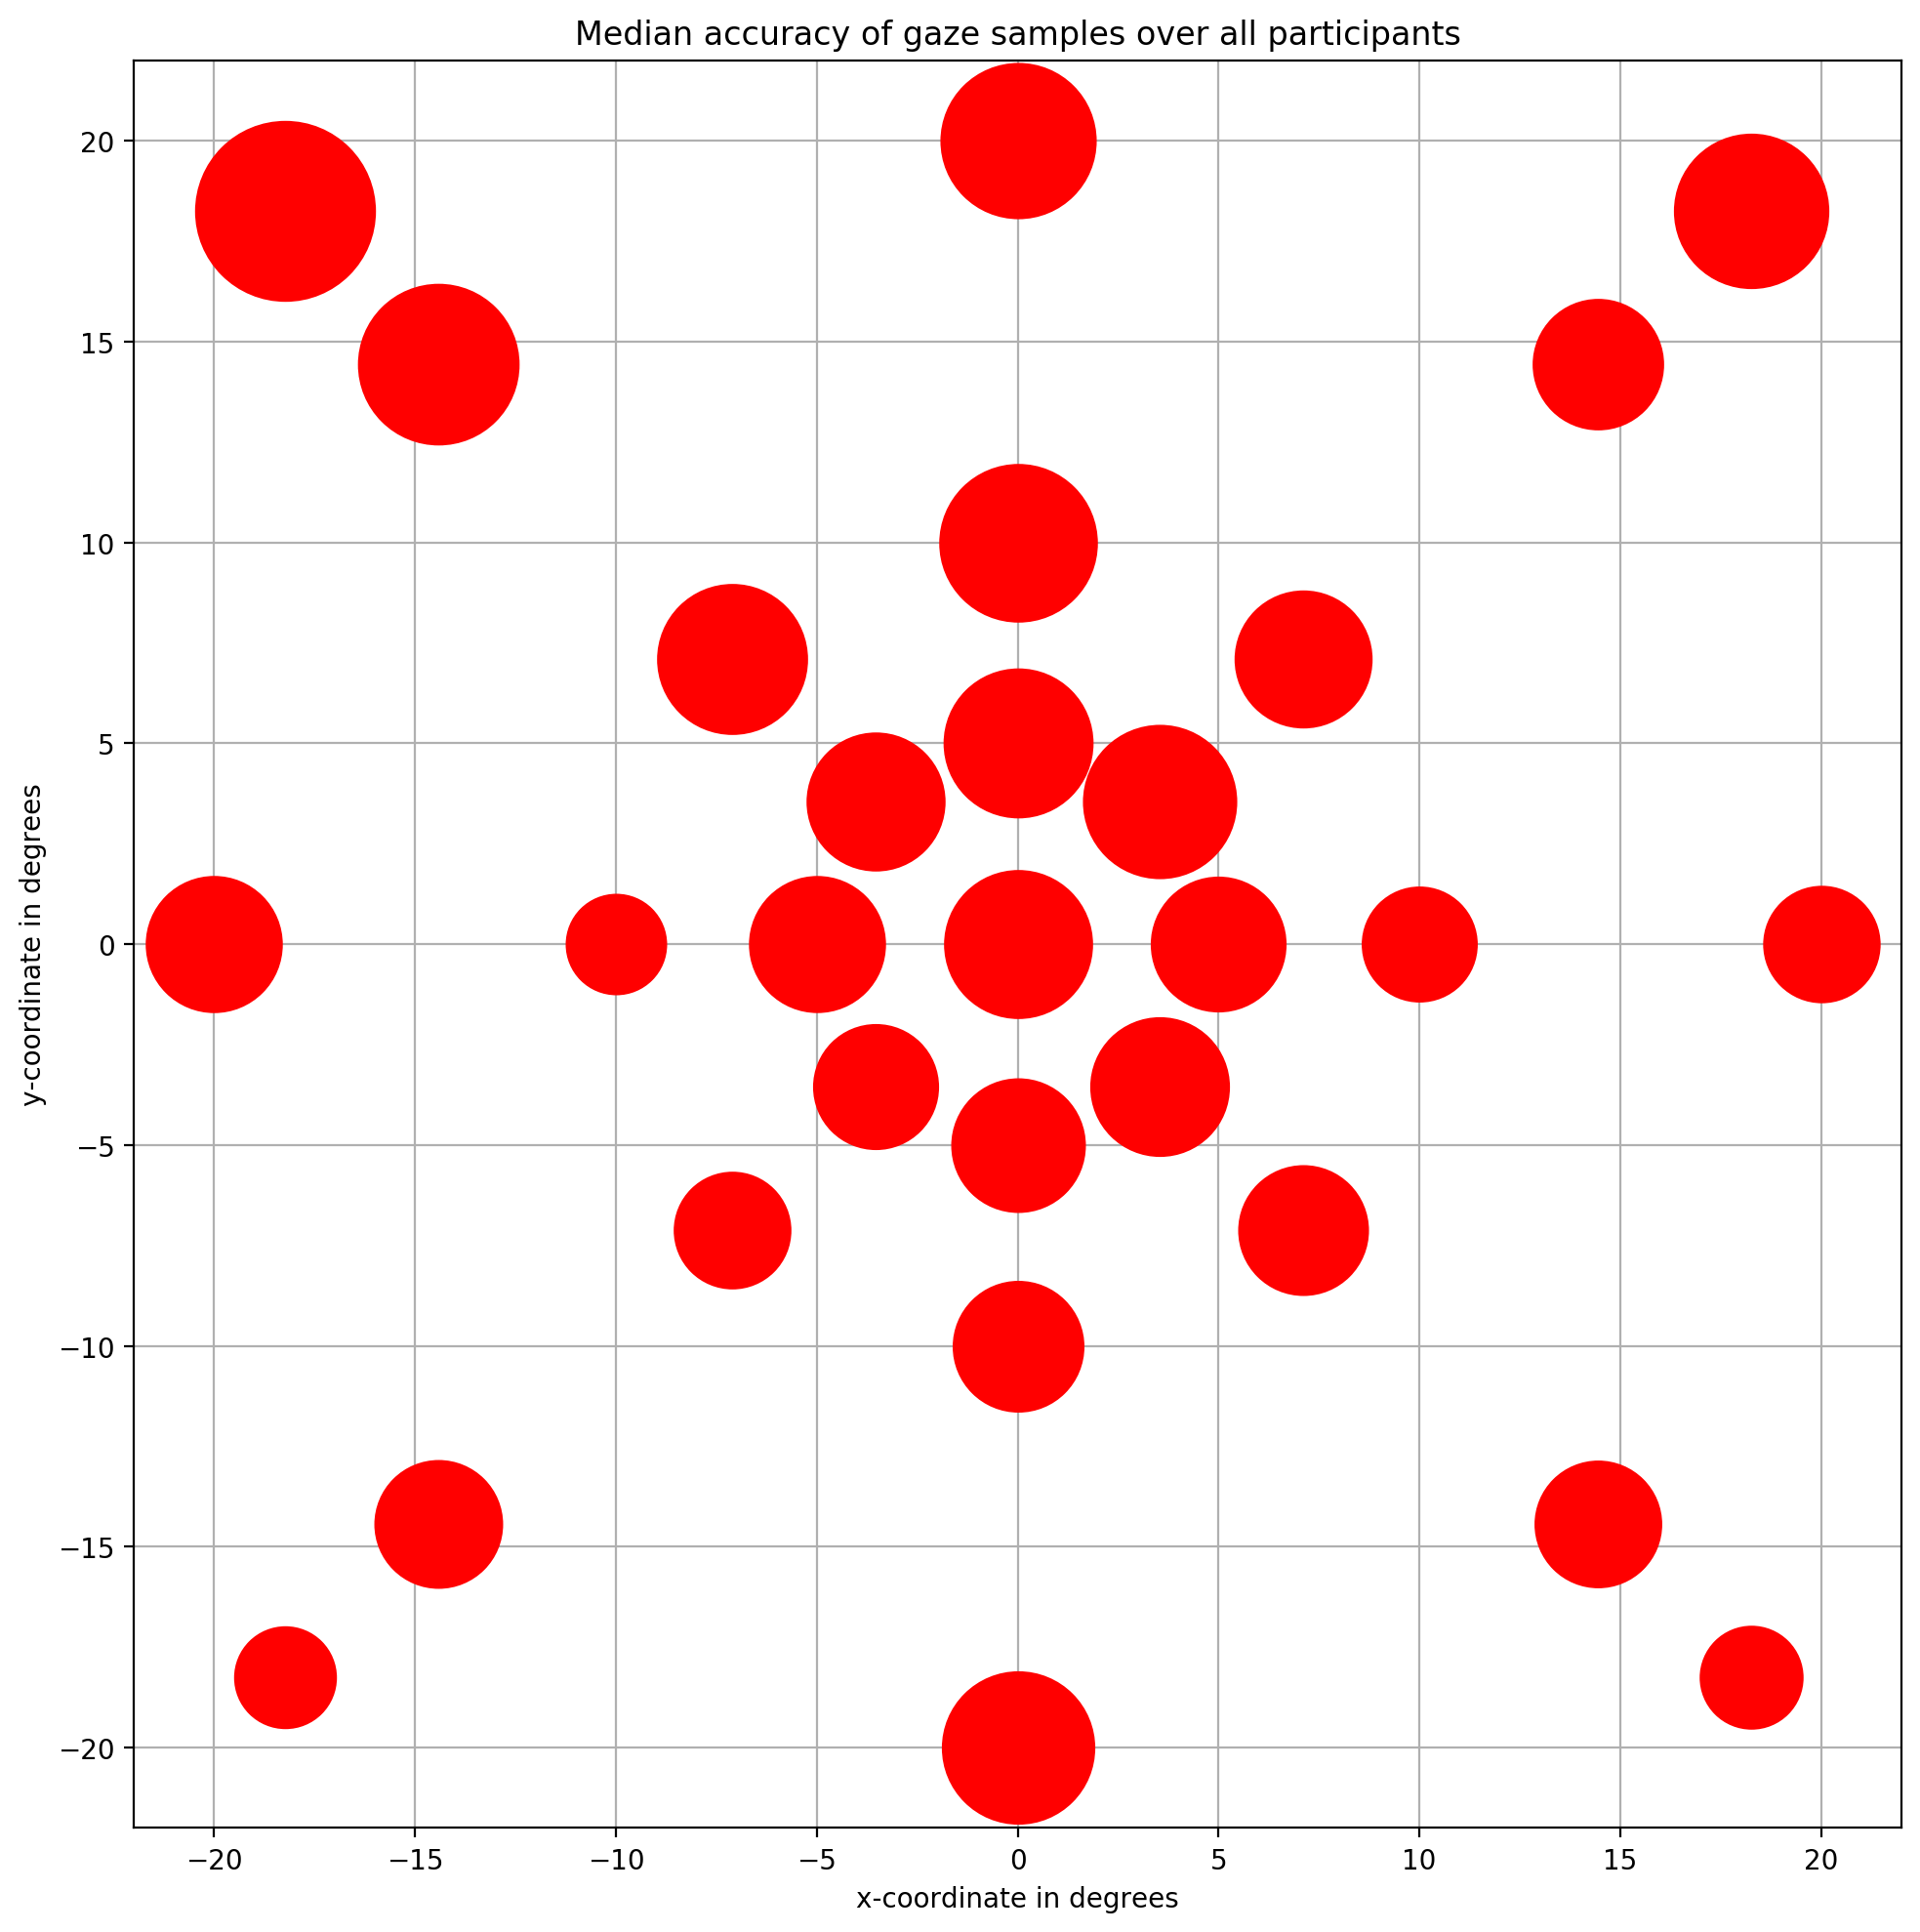

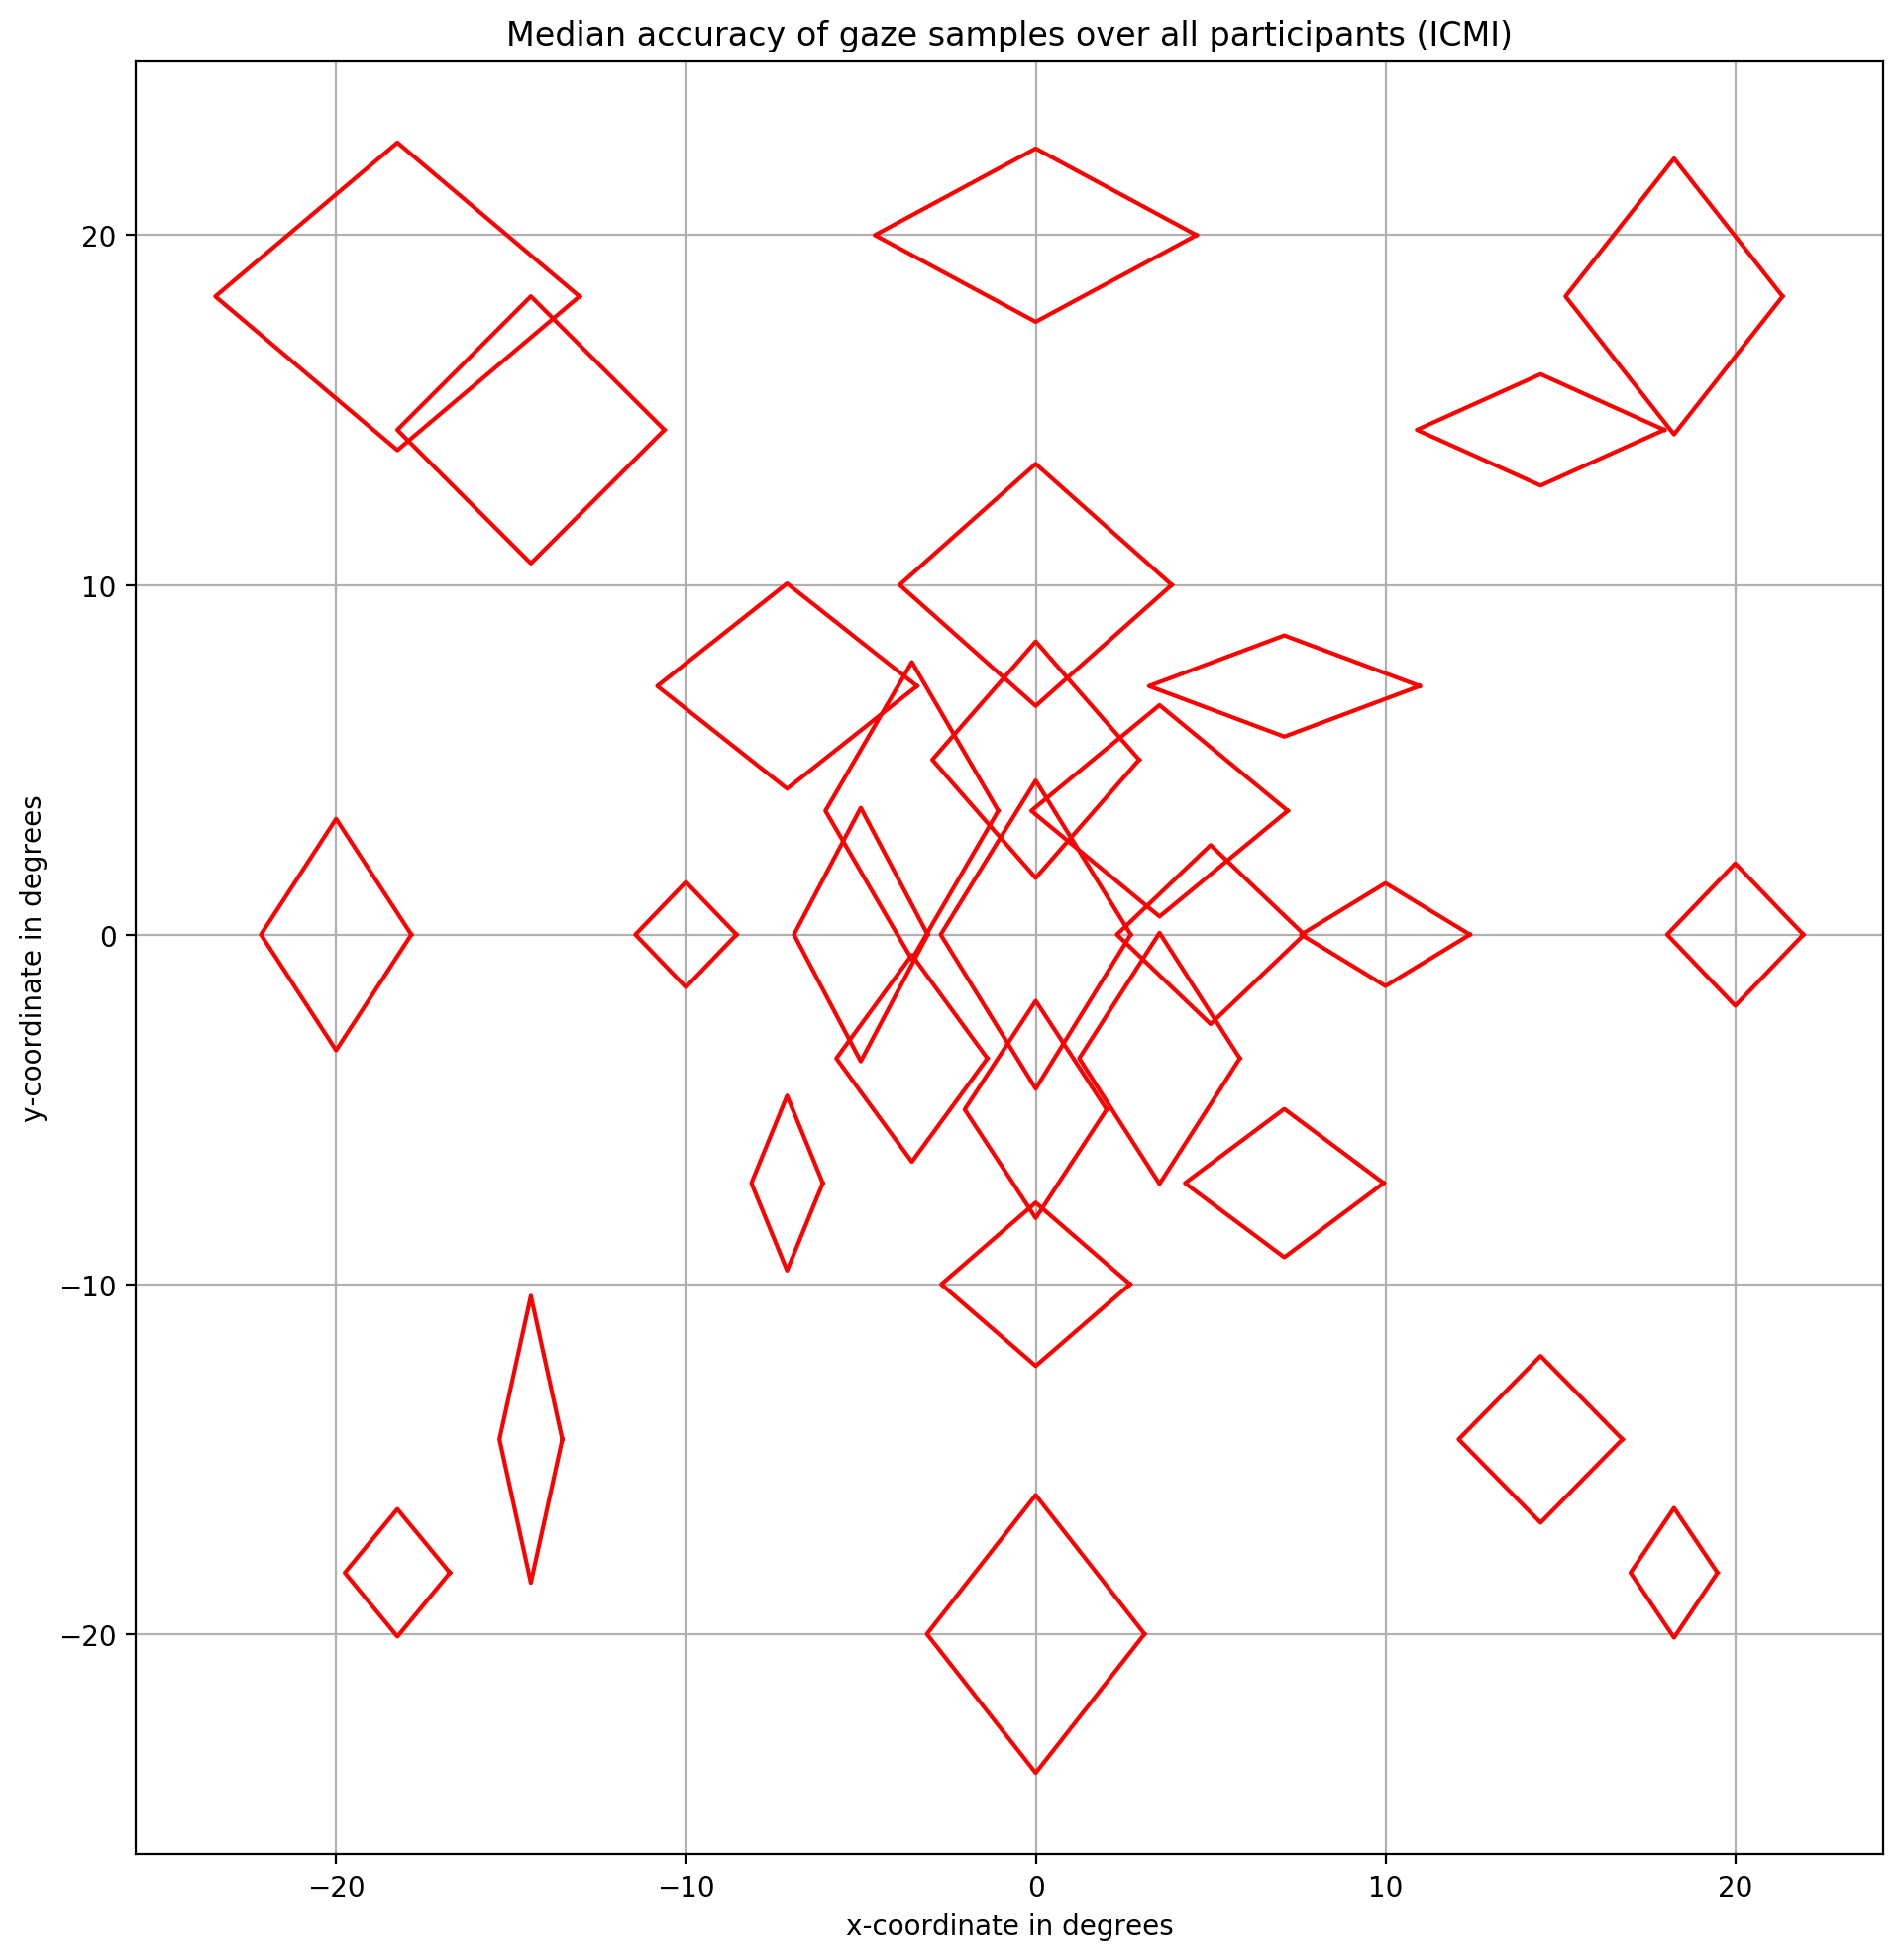

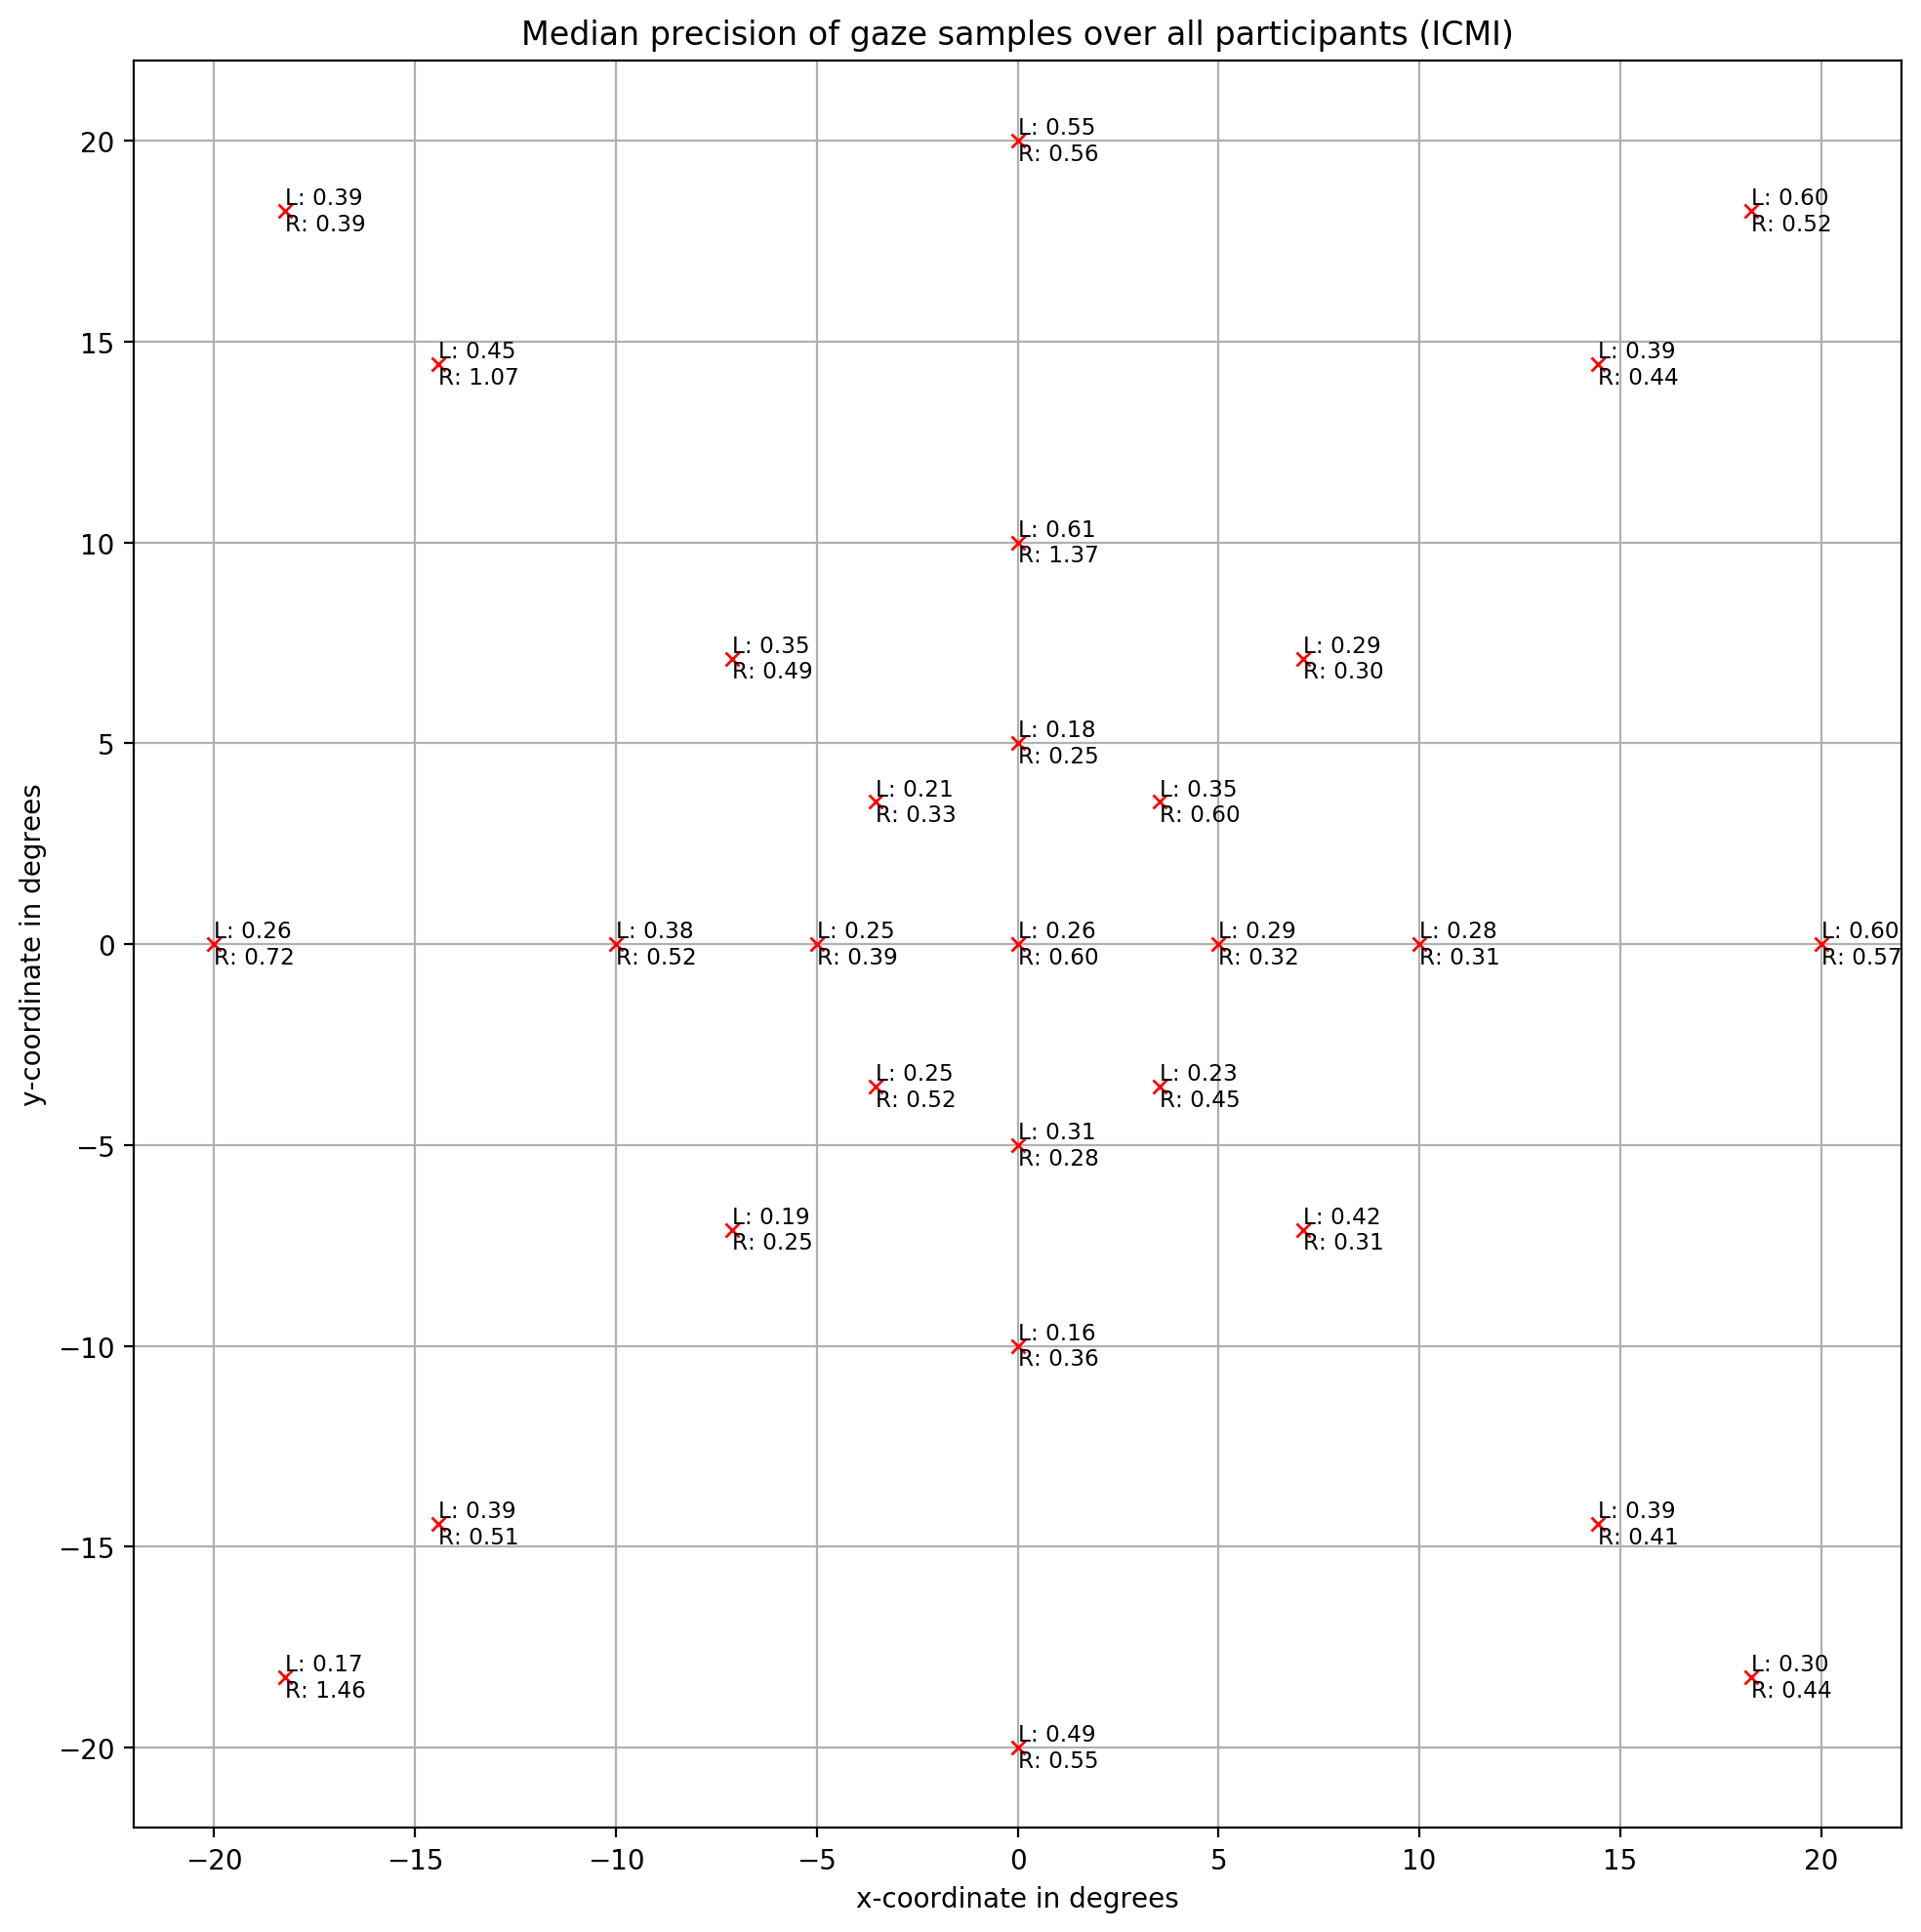

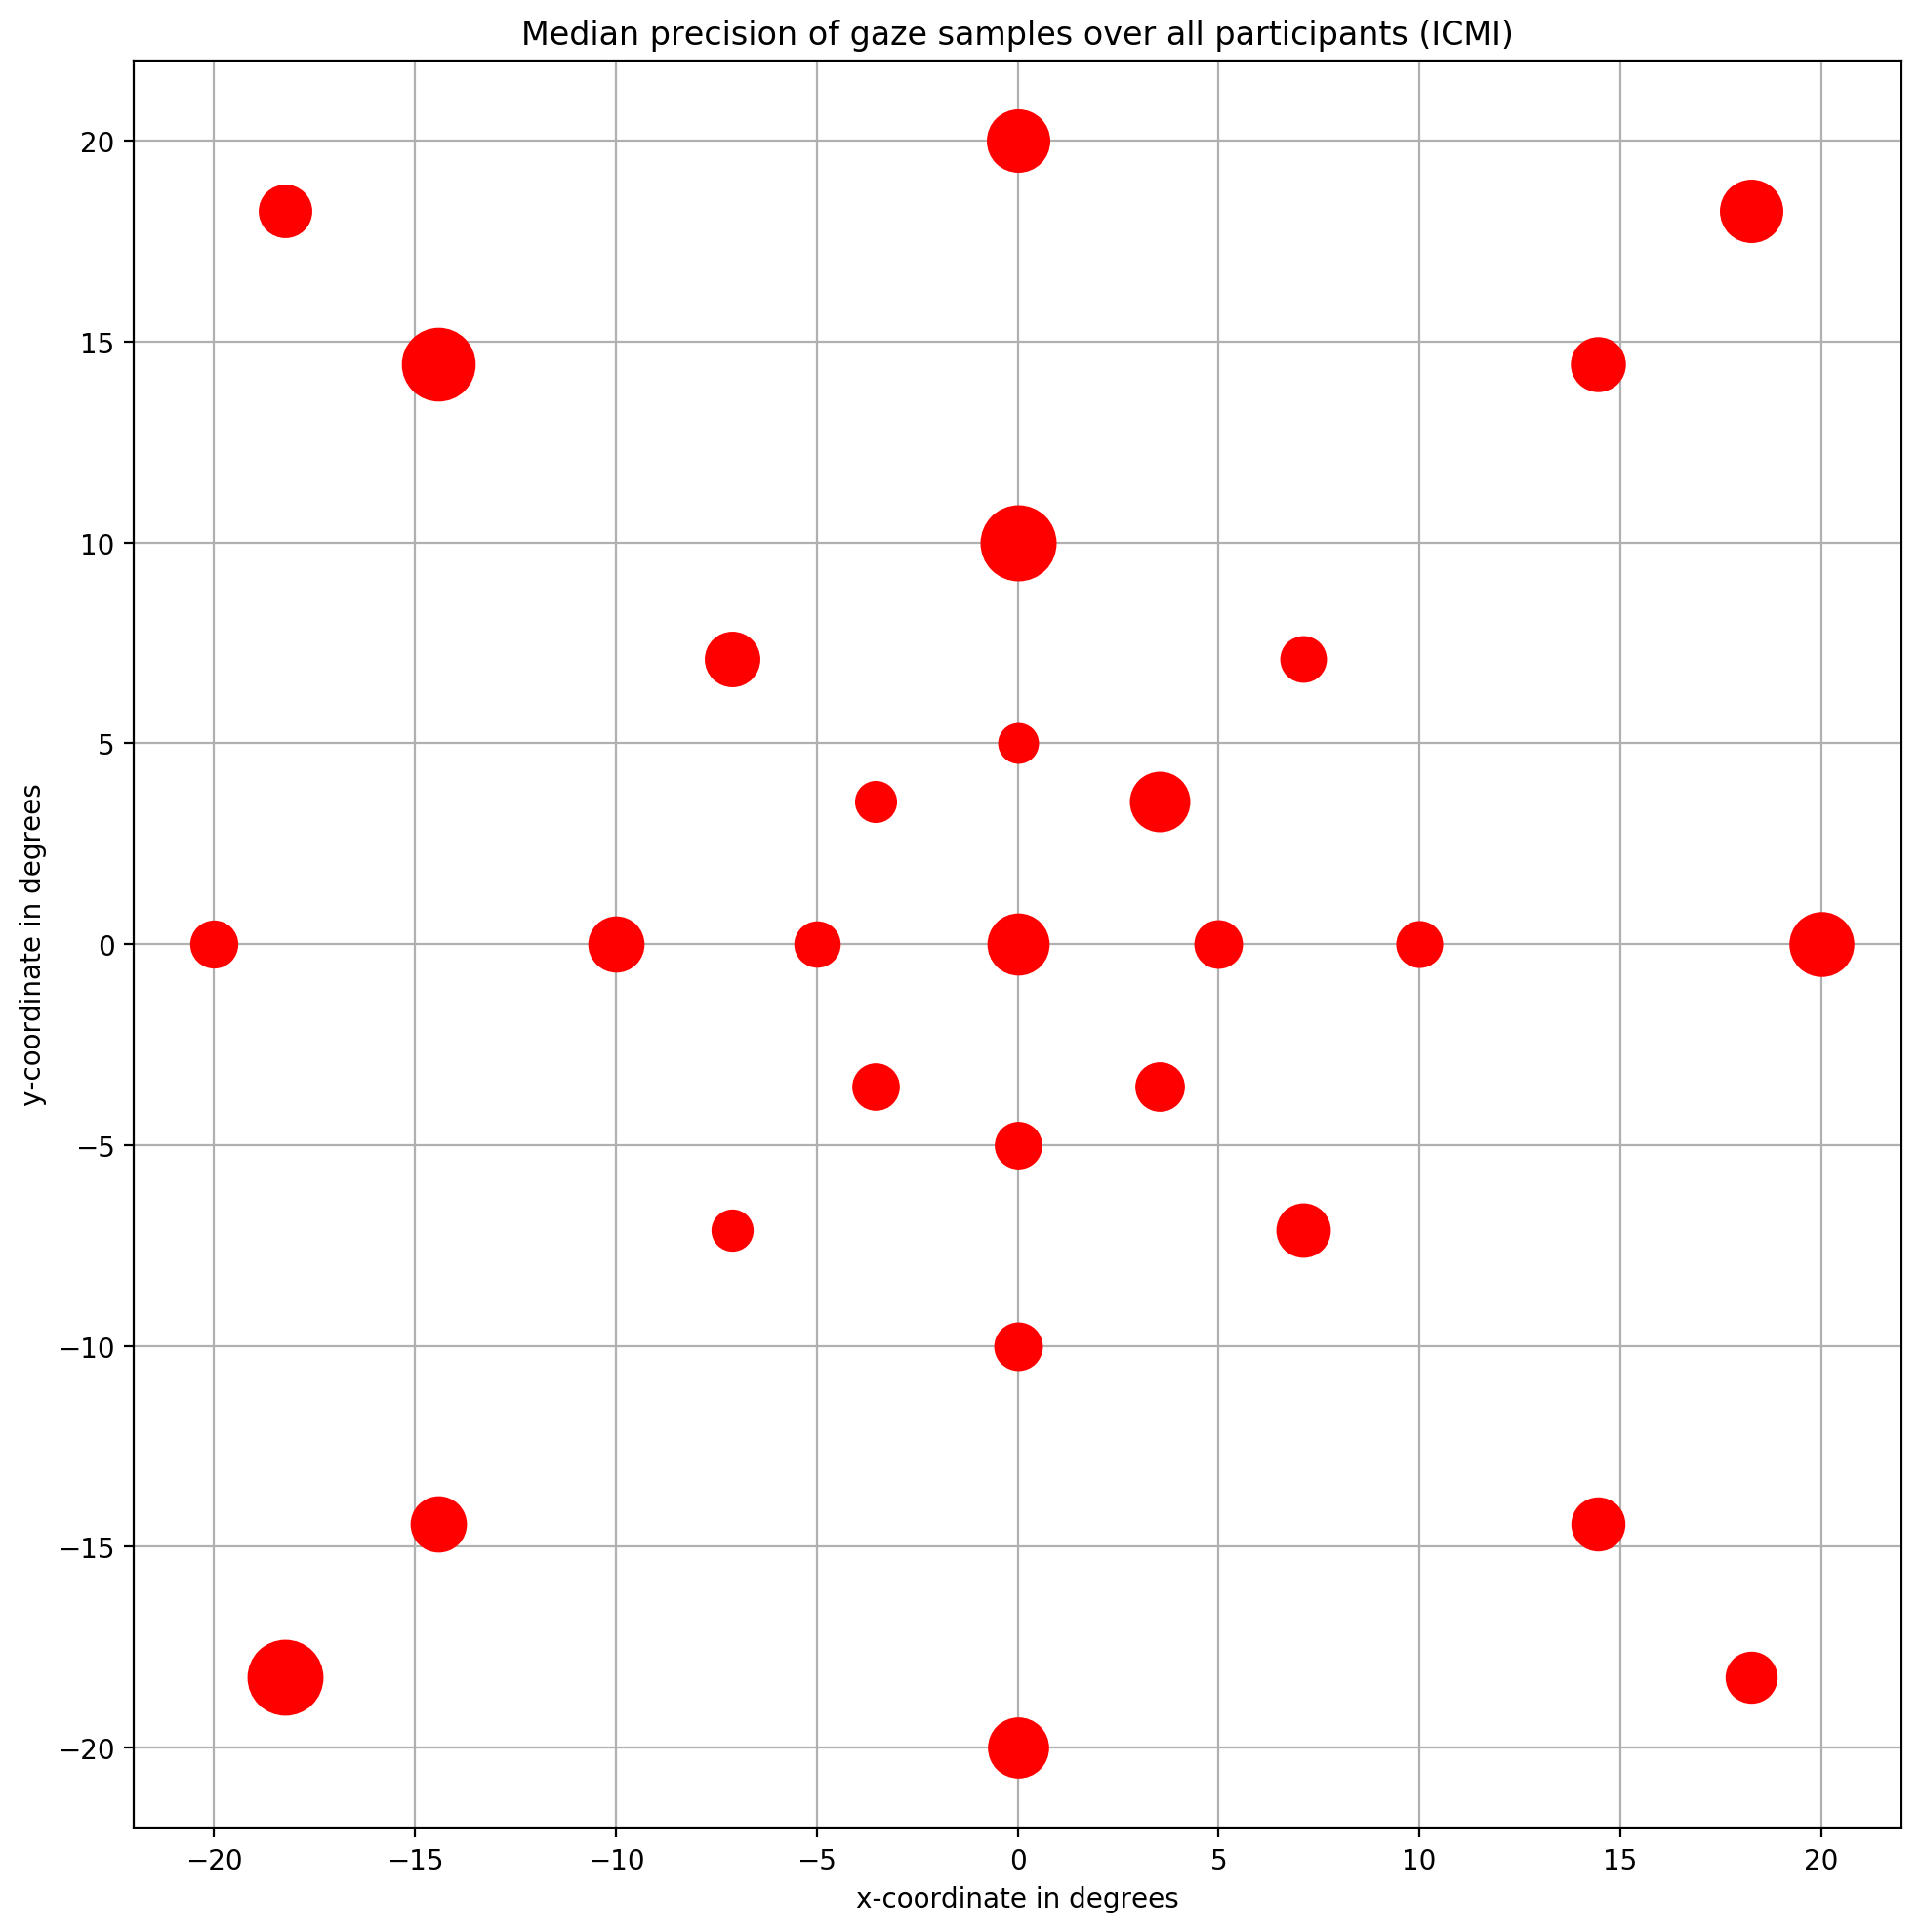

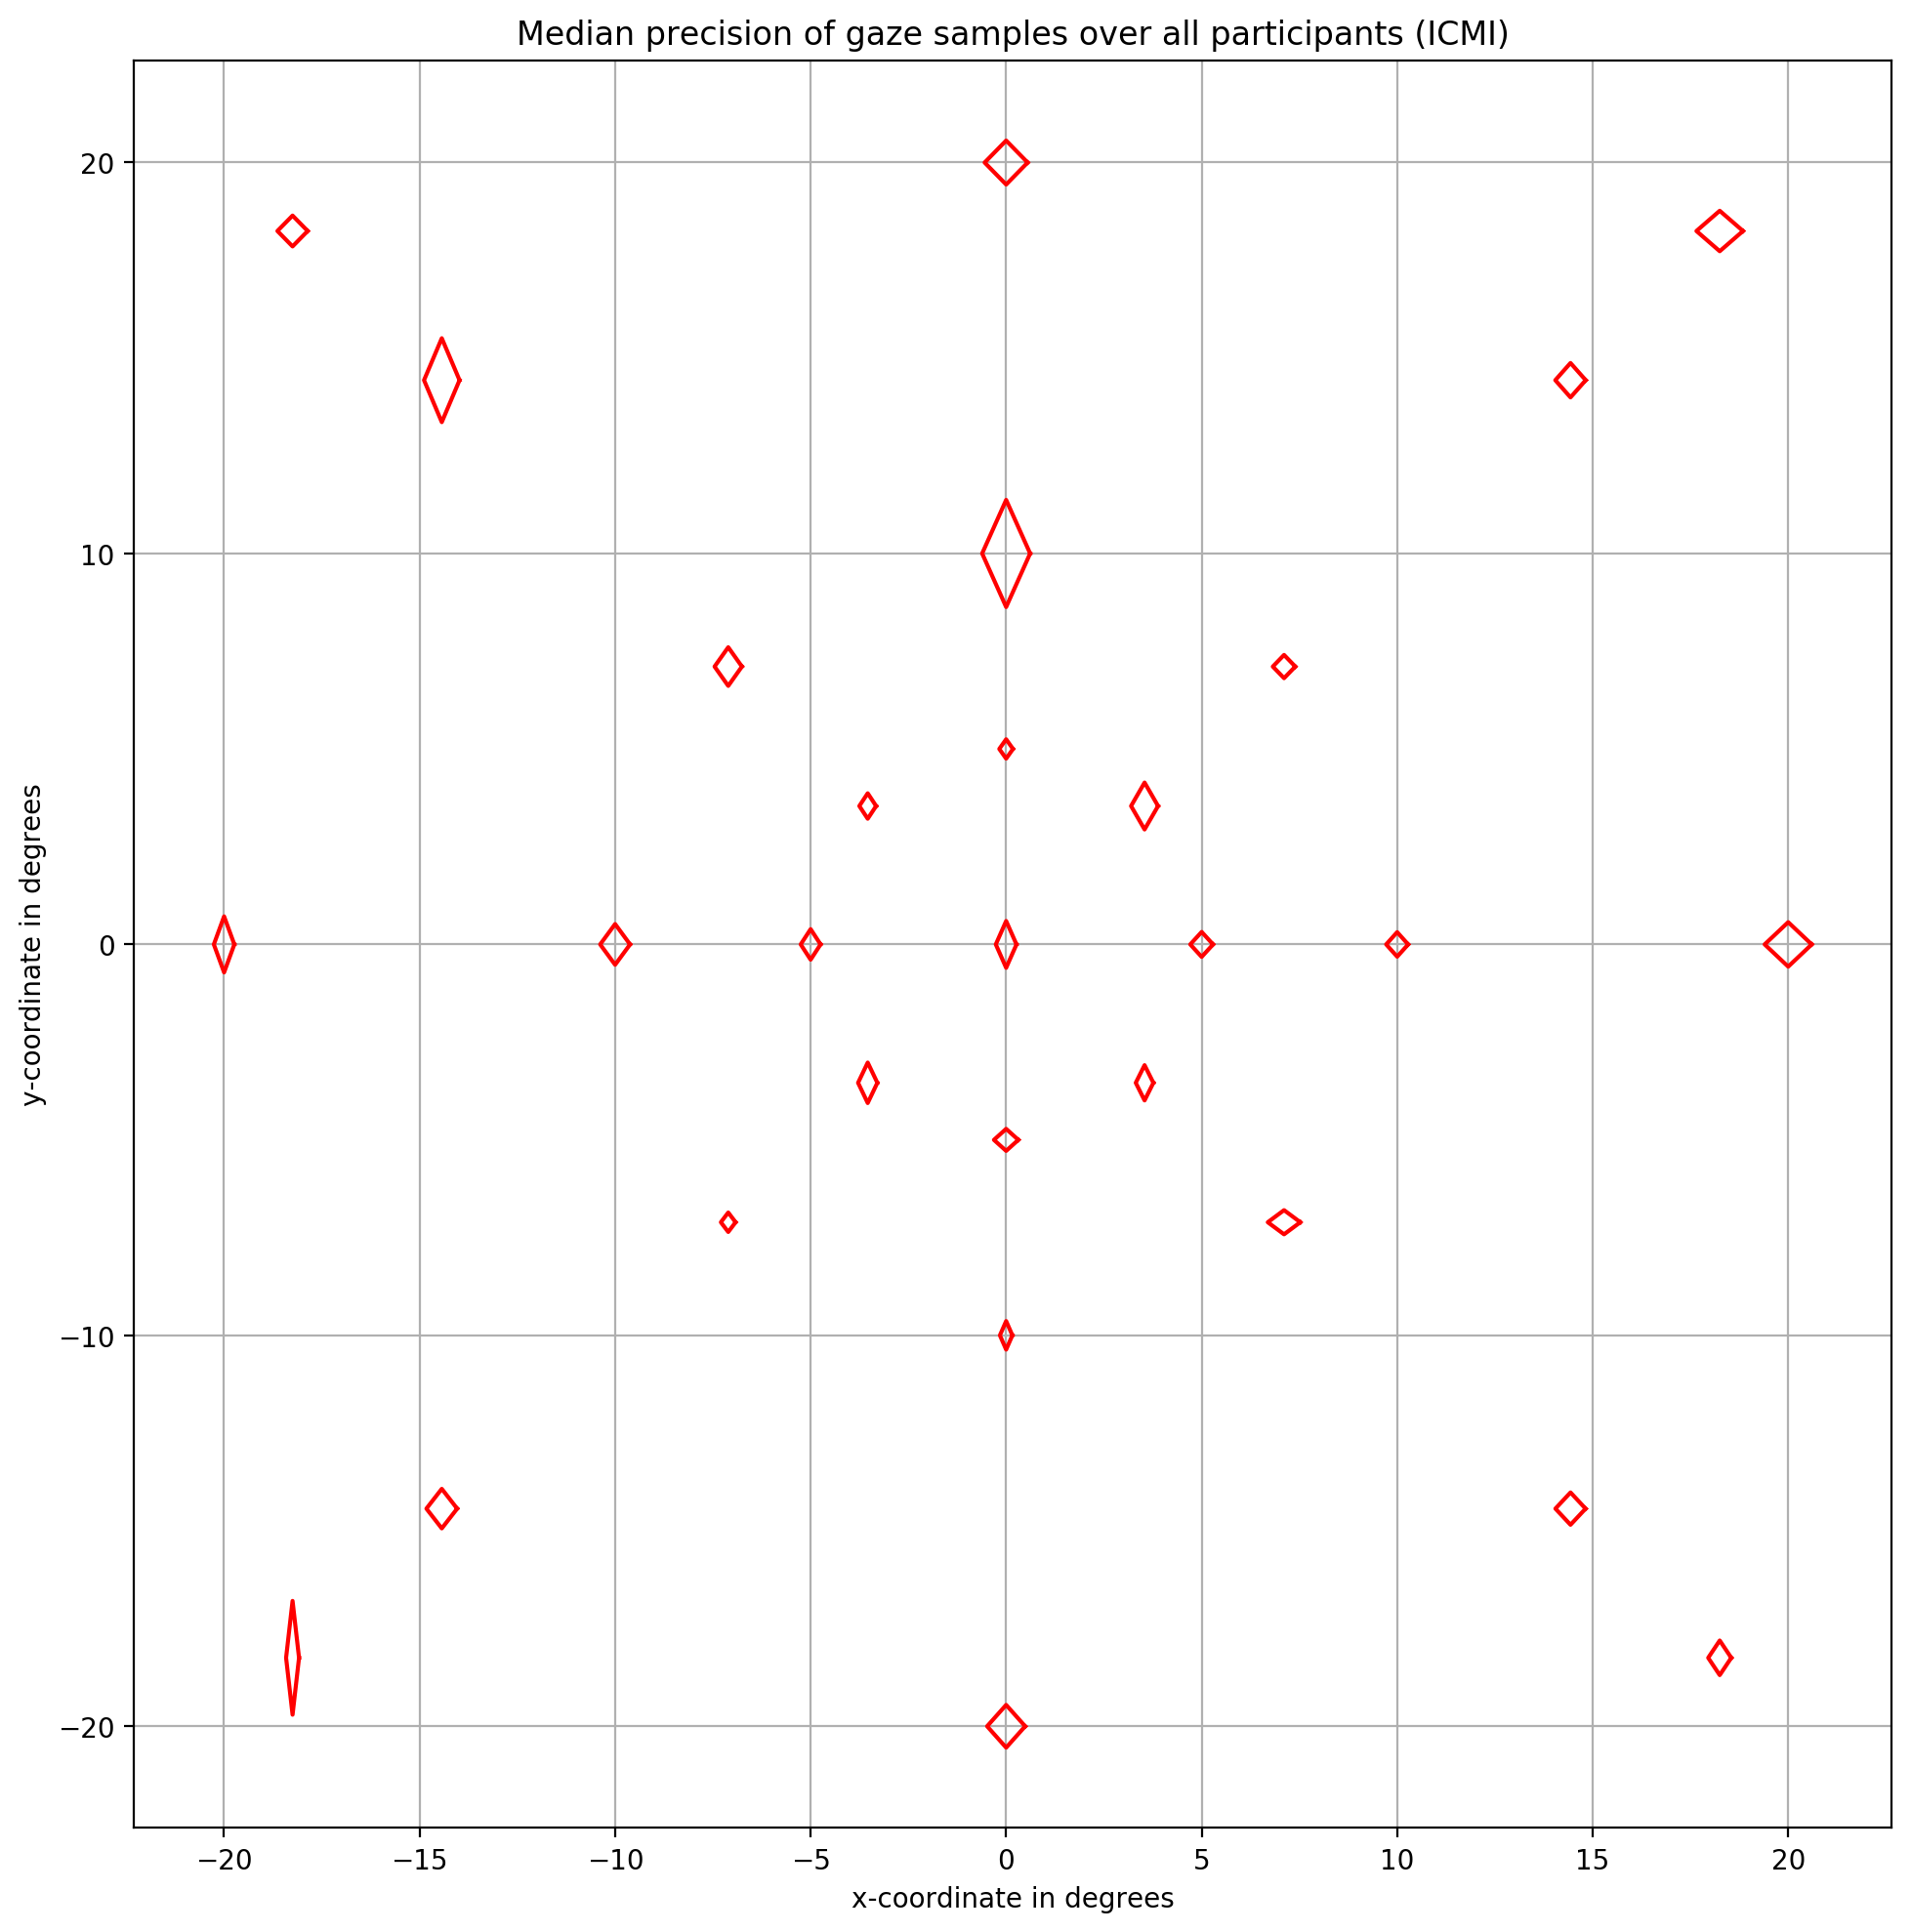

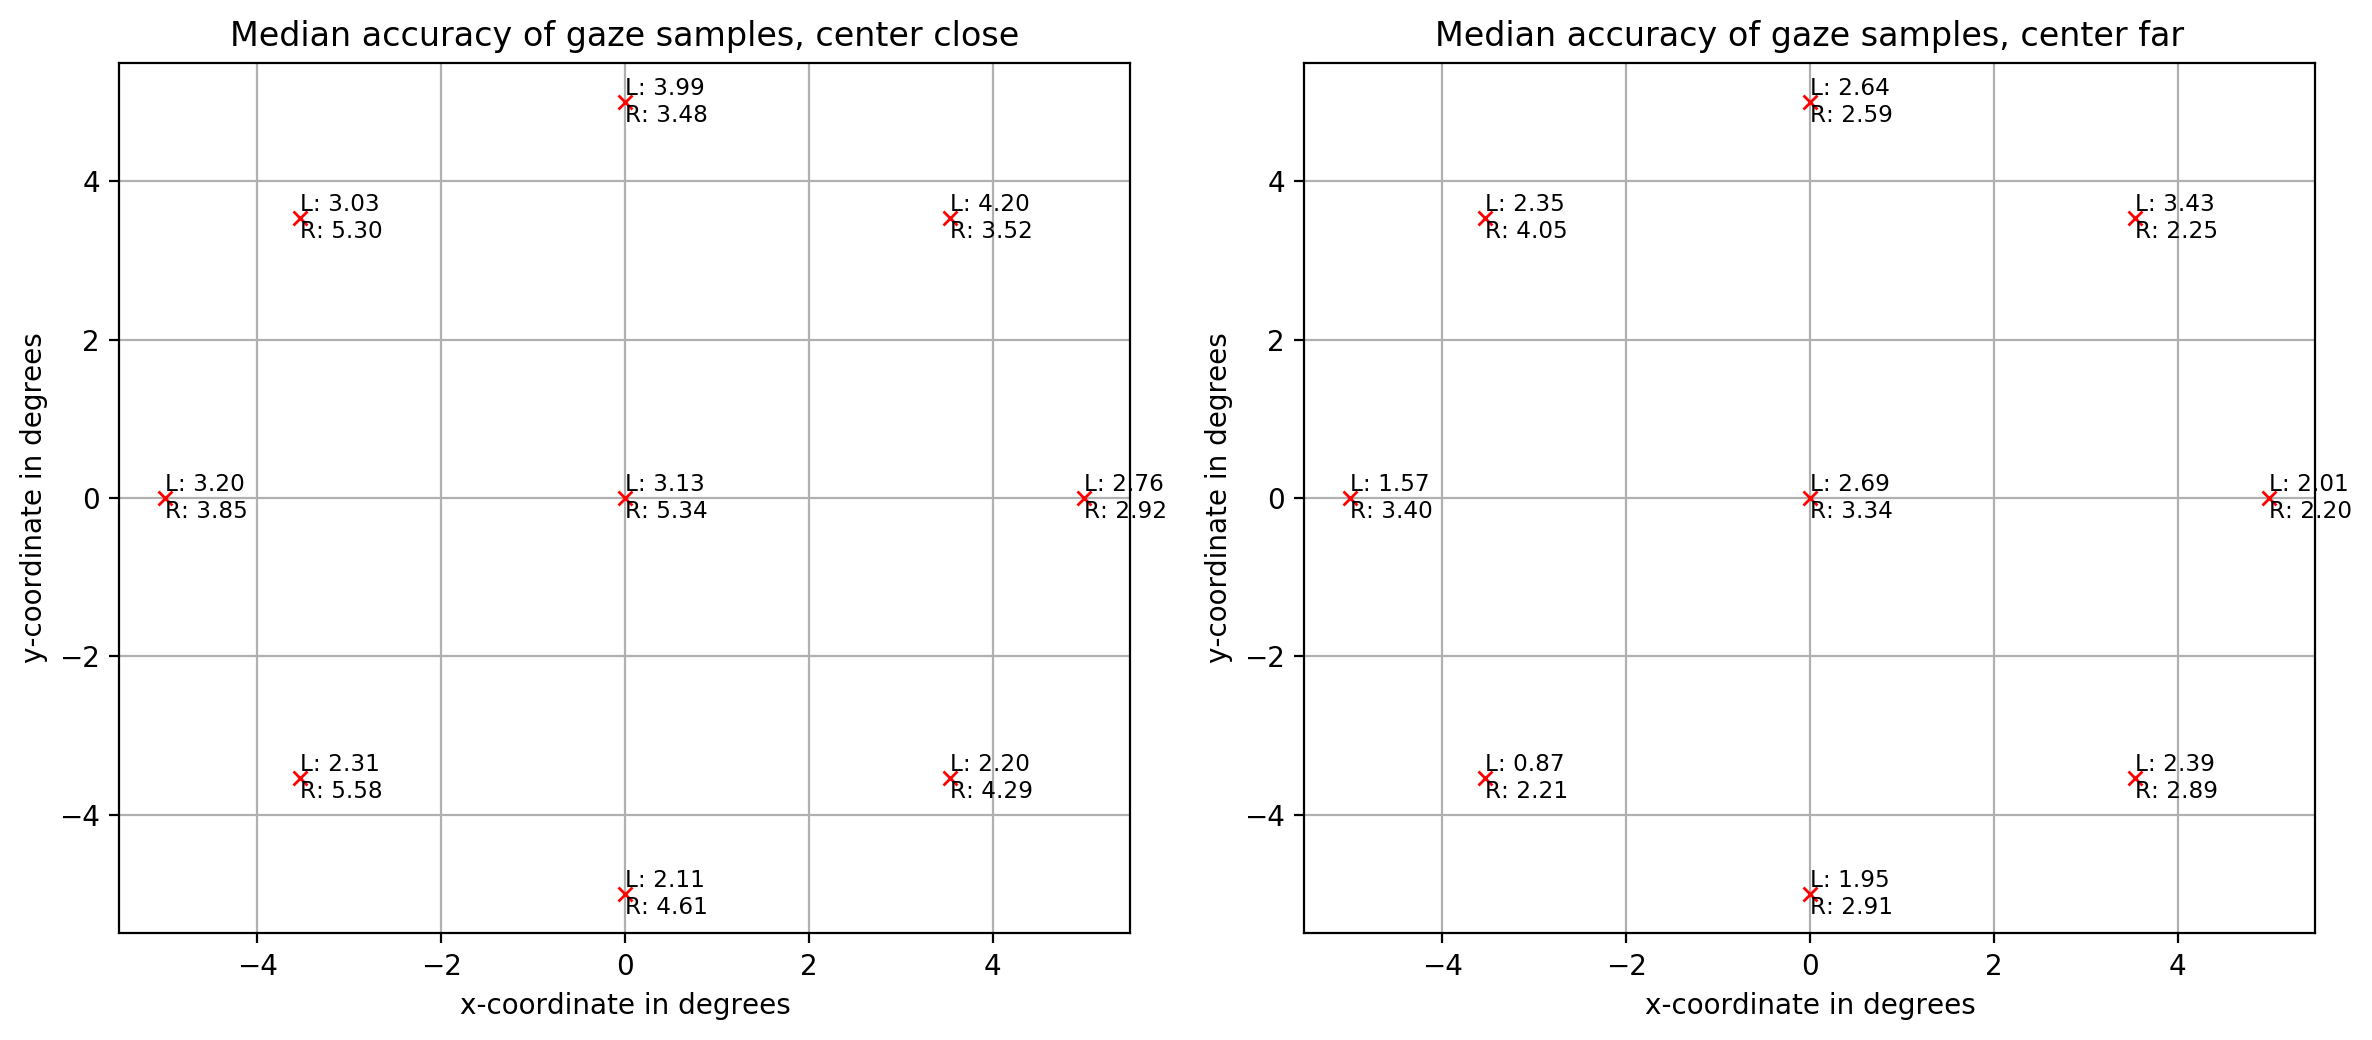

Median accuracy, center close, left eye:  3.03
Median accuracy, center close, right eye: 4.29
Median accuracy, center close, both eyes: 3.50
Median accuracy, center far, left eye:  2.25
Median accuracy, center far, right eye: 2.89
Median accuracy, center far, both eyes: 2.32


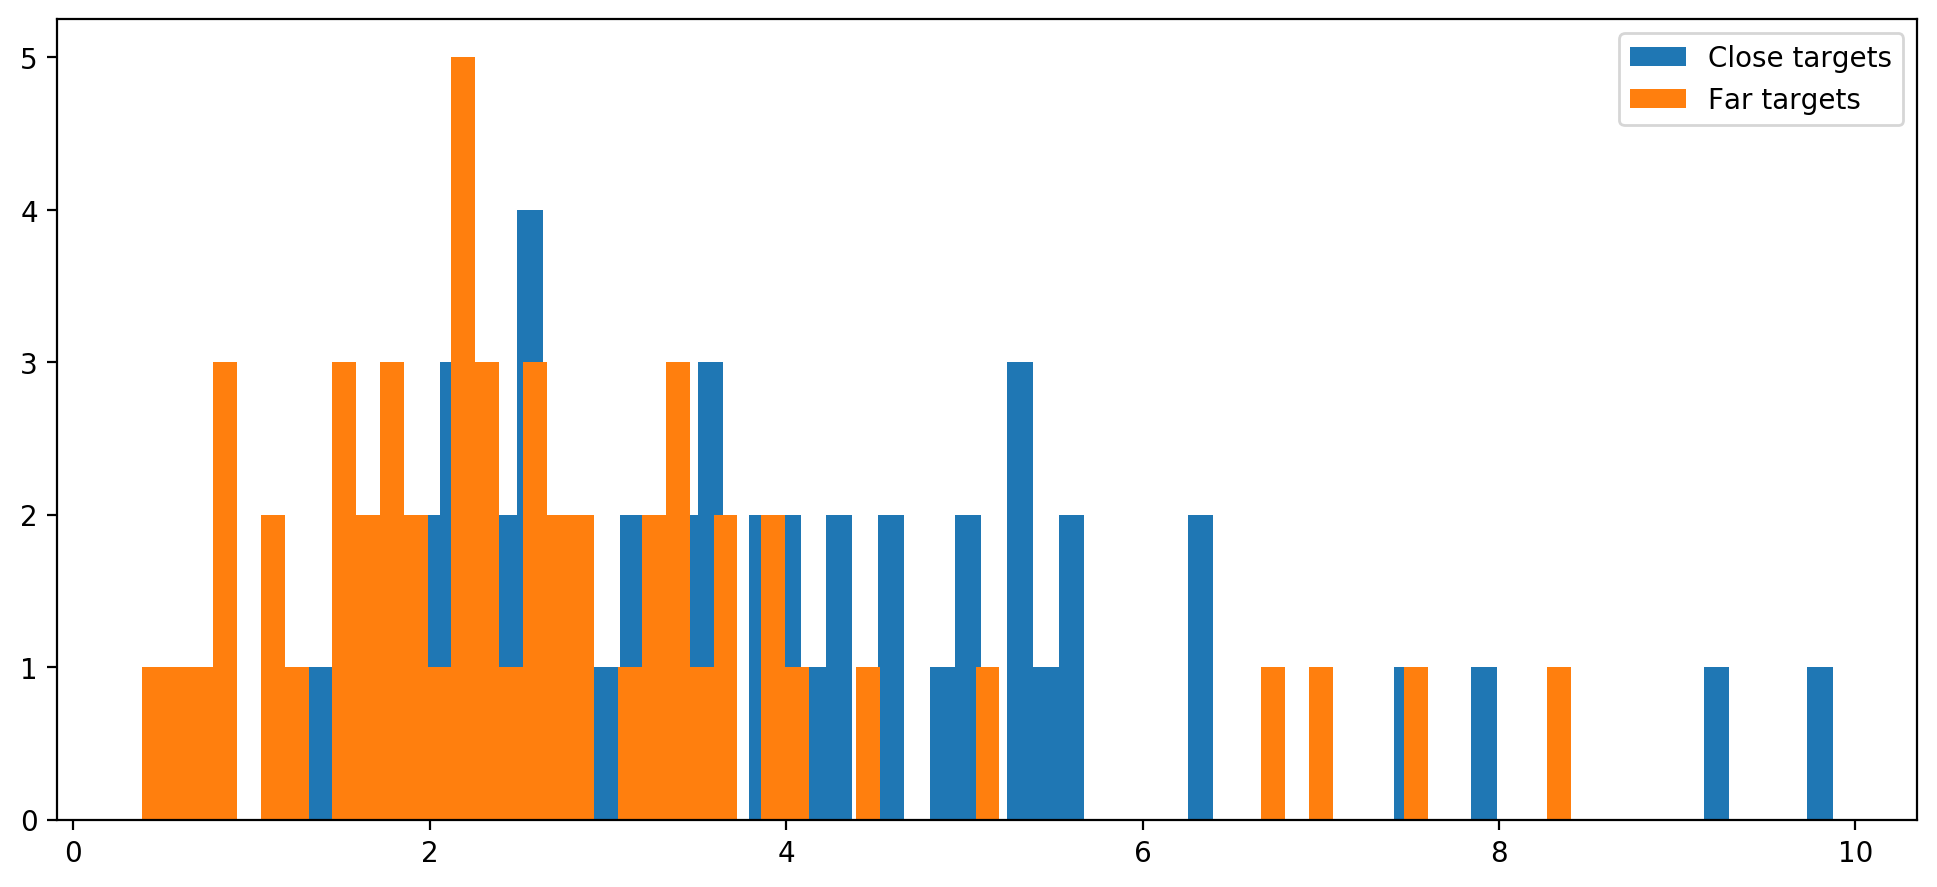

P-value of medians being same: 0.0004


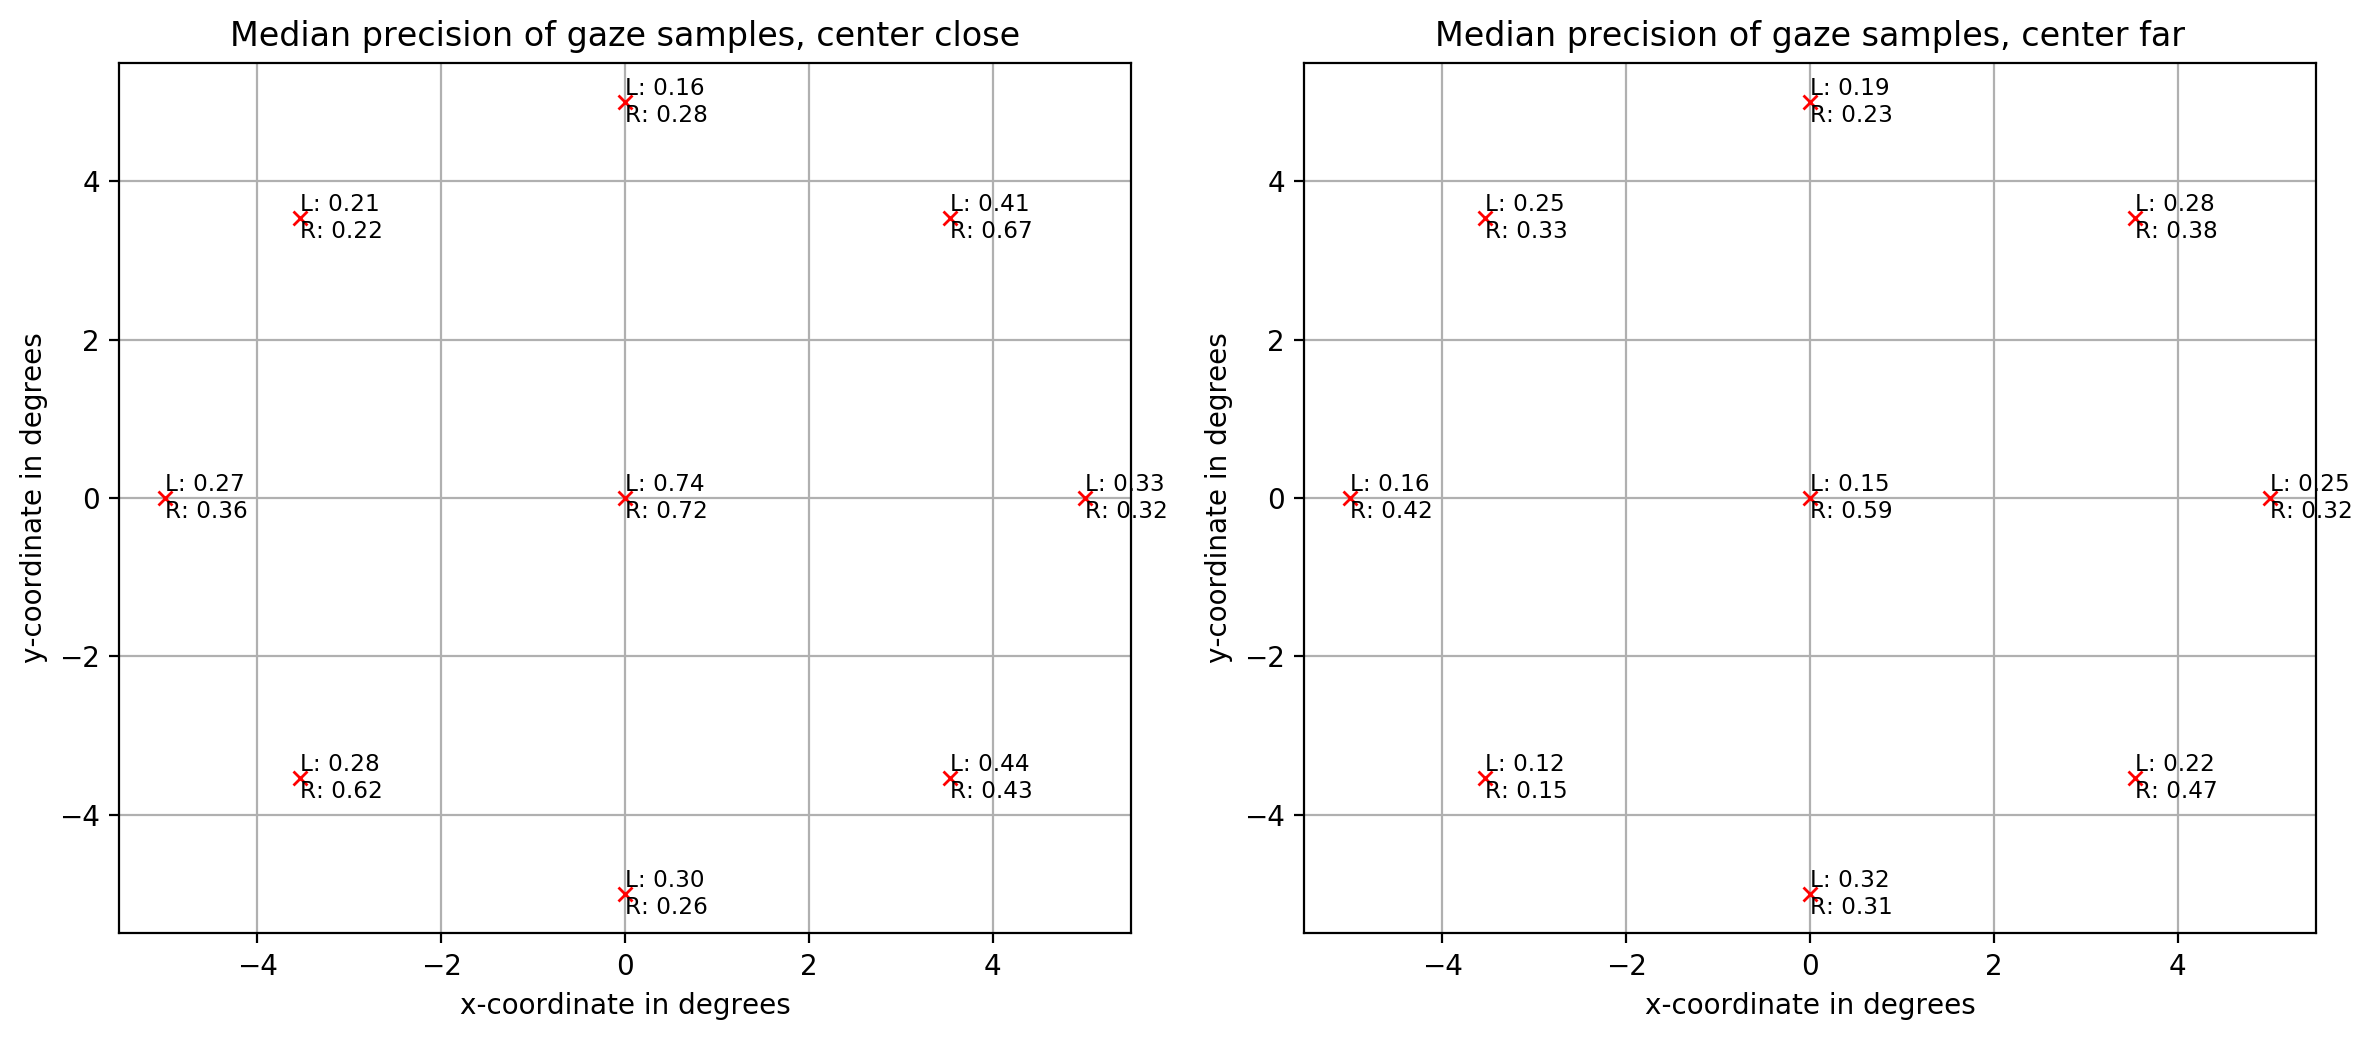

Median precision, center close, left eye:  0.28
Median precision, center close, right eye: 0.43
Median precision, center close, both eyes: 0.33
Median precision, center far, left eye:  0.22
Median precision, center far, right eye: 0.32
Median precision, center far, both eyes: 0.25


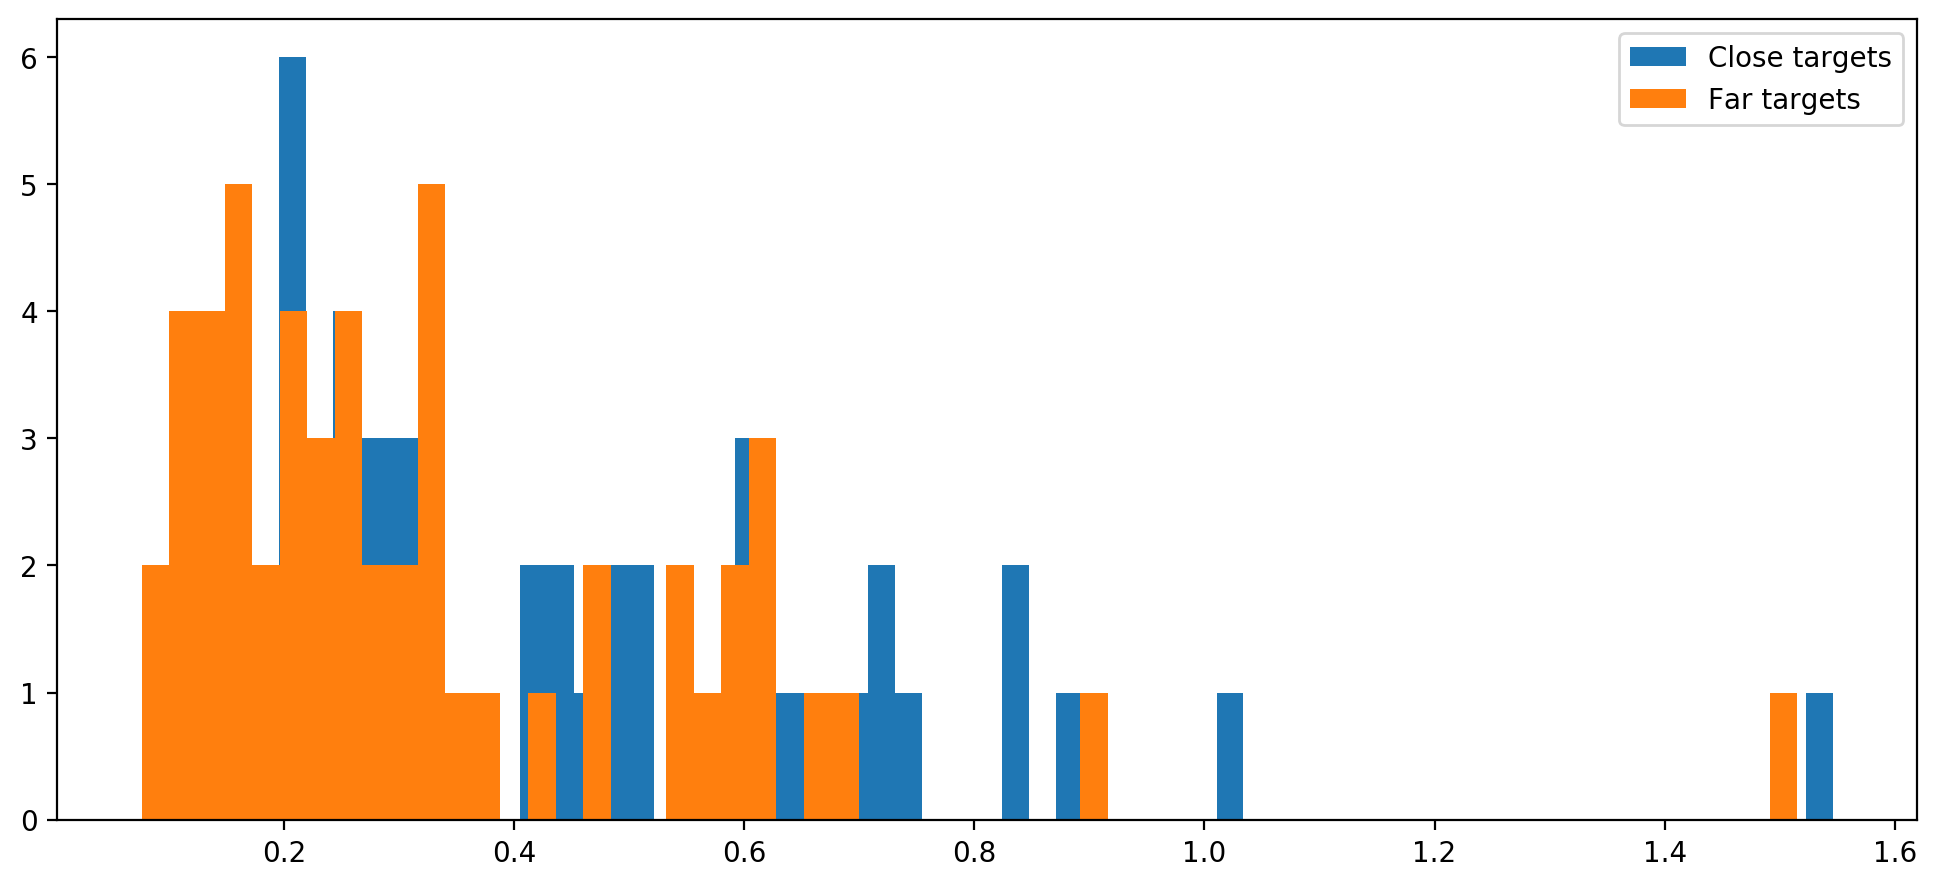

P-value of medians being same: 0.0424


In [12]:
# an evaluation of data distribution in space
from matplotlib.font_manager import FontProperties

print()
print('ARes = ', end = '')
print(ARes)

font0 = FontProperties()
font1 = font0.copy()
font1.set_size('small')

fitts = [[0,22],[1,20],[2],[3,37],[4],[5],[6,27],[7],[8],[9,16],
         [10],[11],[12,26],[13,30],[14],[15],[],[17,33],[18],[19],
         [],[21],[],[23],[24,35],[25],[],[],[28],[29],
         [],[31],[32],[],[34],[],[36],[]]
         

# just an index image
fig = plt.figure(figsize=(10,10),dpi=200)
plt.axes().set_aspect('equal')
for aa in ARes:
    po = [ARes[aa]['Location'][0], ARes[aa]['Location'][1], ARes[aa]['Location'][2]]
    
    if len(fitts[aa]) > 0:
        valu = '{:}'.format(fitts[aa])
        plt.text(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),valu,
                 horizontalalignment='center',verticalalignment='bottom',fontproperties=font1)
        plt.plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),'xr',markersize=1)
plt.title('Index locations')
plt.xlabel('x-coordinate in degrees')
plt.ylabel('y-coordinate in degrees')
plt.grid(True)
plt.tight_layout()
plt.savefig(r'Index_locations_{:}.pdf'.format(DataLabel))
plt.show()

# accuracy image
fig = plt.figure(figsize=(10,10),dpi=200)
plt.axes().set_aspect('equal')
for aa in ARes:
    po = [ARes[aa]['Location'][0], ARes[aa]['Location'][1], ARes[aa]['Location'][2]]
    
    Lvals = []
    Rvals = []
    for i in fitts[aa]:
        if i in ARes:
            Lvals.extend(ARes[i]['LAcc'])
            Rvals.extend(ARes[i]['RAcc'])
    
#    valu = 'L: {:.2f}\nR: {:.2f}'.format(np.median(ARes[aa]['LAcc']), np.median(ARes[aa]['RAcc']))
    if len(Lvals) > 0:
        valu = 'L: {:.2f}\nR: {:.2f}'.format(np.median(Lvals), np.median(Rvals))
        plt.text(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),valu,
                 verticalalignment='center',fontproperties=font1)
        plt.plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),'xr',markersize=5)
plt.title('Median accuracy of gaze samples over all participants ({:})'.format(DataLabel))
plt.xlabel('x-coordinate in degrees')
plt.ylabel('y-coordinate in degrees')
plt.grid(True)
plt.tight_layout()
plt.savefig(r'Accur_locations_{:}.png'.format(DataLabel))
plt.show()

# alternative image
fig = plt.figure(figsize=(10,10),dpi=200)
plt.axes().set_aspect('equal')
for aa in ARes:
    po = [ARes[aa]['Location'][0], ARes[aa]['Location'][1], ARes[aa]['Location'][2]]
    
    Lvals = []
    Rvals = []
    for i in fitts[aa]:
        if i in ARes:
            Lvals.extend(ARes[i]['LAcc'])
            Rvals.extend(ARes[i]['RAcc'])
    
#    valu = 'L: {:.2f}\nR: {:.2f}'.format(np.median(ARes[aa]['LAcc']), np.median(ARes[aa]['RAcc']))
    if len(Lvals) > 0:
        valu = np.median(Lvals+Rvals)
#        plt.plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),'or',markersize=20*valu)
        plt.plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),'or',markersize=30*np.sqrt(valu))
#plt.title('Median accuracy of gaze samples over all participants ({:})'.format(DataLabel))
plt.title('Median accuracy of gaze samples over all participants'.format(DataLabel))
plt.xlabel('x-coordinate in degrees')
plt.ylabel('y-coordinate in degrees')
plt.grid(True)
plt.tight_layout()
#plt.savefig(r'Accur_locations_2_{:}.pdf'.format(DataLabel))
plt.savefig(r'Accur_locations_2_{:}.png'.format('paper'))
plt.show()

# another alternative image
def own_d_plot(x0,y0,ls,rs):
    xl = [x0+ls,x0,x0-ls,x0,x0+ls]
    yl = [y0,y0+rs,y0,y0-rs,y0]
    plt.plot(xl,yl,'r')
    return()

fig = plt.figure(figsize=(10,10),dpi=200)
plt.axes().set_aspect('equal')
for aa in ARes:
    po = [ARes[aa]['Location'][0], ARes[aa]['Location'][1], ARes[aa]['Location'][2]]
    
    Lvals = []
    Rvals = []
    for i in fitts[aa]:
        if i in ARes:
            Lvals.extend(ARes[i]['LAcc'])
            Rvals.extend(ARes[i]['RAcc'])
    
#    valu = 'L: {:.2f}\nR: {:.2f}'.format(np.median(ARes[aa]['LAcc']), np.median(ARes[aa]['RAcc']))
    if len(Lvals) > 0:
        valu = np.median(Lvals+Rvals)
        own_d_plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),np.median(Lvals), np.median(Rvals))
#        plt.plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),'or',markersize=20*valu)
plt.title('Median accuracy of gaze samples over all participants ({:})'.format(DataLabel))
plt.xlabel('x-coordinate in degrees')
plt.ylabel('y-coordinate in degrees')
plt.grid(True)
plt.tight_layout()
plt.savefig(r'Accur_locations_3_{:}.pdf'.format(DataLabel))
plt.show()


# the precision
fig = plt.figure(figsize=(10,10),dpi=200)
plt.axes().set_aspect('equal')
for aa in ARes:
    po = [ARes[aa]['Location'][0], ARes[aa]['Location'][1], ARes[aa]['Location'][2]]
    
    Lvals = []
    Rvals = []
    for i in fitts[aa]:
        if i in ARes:
            Lvals.extend(ARes[i]['LPre'])
            Rvals.extend(ARes[i]['RPre'])
    
#    valu = 'L: {:.2f}\nR: {:.2f}'.format(np.median(ARes[aa]['LPre']), np.median(ARes[aa]['RPre']))
    if len(Lvals) > 0:
        valu = 'L: {:.2f}\nR: {:.2f}'.format(np.median(Lvals), np.median(Rvals))
        plt.text(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),valu,
                 verticalalignment='center',fontproperties=font1)
        plt.plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),'xr',markersize=5)
plt.title('Median precision of gaze samples over all participants ({:})'.format(DataLabel))
plt.xlabel('x-coordinate in degrees')
plt.ylabel('y-coordinate in degrees')
plt.grid(True)
plt.tight_layout()
plt.savefig(r'Prec_locations_{:}.pdf'.format(DataLabel))
plt.show()

# alternative image
fig = plt.figure(figsize=(10,10),dpi=200)
plt.axes().set_aspect('equal')
for aa in ARes:
    po = [ARes[aa]['Location'][0], ARes[aa]['Location'][1], ARes[aa]['Location'][2]]
    
    Lvals = []
    Rvals = []
    for i in fitts[aa]:
        if i in ARes:
            Lvals.extend(ARes[i]['LPre'])
            Rvals.extend(ARes[i]['RPre'])
    
#    valu = 'L: {:.2f}\nR: {:.2f}'.format(np.median(ARes[aa]['LPre']), np.median(ARes[aa]['RPre']))
    if len(Lvals) > 0:
        valu = np.median(Lvals+Rvals)
#        plt.plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),'or',markersize=20*valu)
        plt.plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),'or',markersize=30*np.sqrt(valu))
plt.title('Median precision of gaze samples over all participants ({:})'.format(DataLabel))
plt.xlabel('x-coordinate in degrees')
plt.ylabel('y-coordinate in degrees')
plt.grid(True)
plt.tight_layout()
plt.savefig(r'Prec_locations_2_{:}.pdf'.format(DataLabel))
plt.show()

# another alternative image
fig = plt.figure(figsize=(10,10),dpi=200)
plt.axes().set_aspect('equal')
for aa in ARes:
    po = [ARes[aa]['Location'][0], ARes[aa]['Location'][1], ARes[aa]['Location'][2]]
    
    Lvals = []
    Rvals = []
    for i in fitts[aa]:
        if i in ARes:
            Lvals.extend(ARes[i]['LPre'])
            Rvals.extend(ARes[i]['RPre'])
    
#    valu = 'L: {:.2f}\nR: {:.2f}'.format(np.median(ARes[aa]['LPre']), np.median(ARes[aa]['RPre']))
    if len(Lvals) > 0:
        valu = np.median(Lvals+Rvals)
        own_d_plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),np.median(Lvals), np.median(Rvals))
#        plt.plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),'or',markersize=20*valu)
plt.title('Median precision of gaze samples over all participants ({:})'.format(DataLabel))
plt.xlabel('x-coordinate in degrees')
plt.ylabel('y-coordinate in degrees')
plt.grid(True)
plt.tight_layout()
plt.savefig(r'Prec_locations_3_{:}.pdf'.format(DataLabel))
plt.show()



ditts2 = [0,1,6,9,17,24,26,30,37]
ditts5 = [3,12,13,16,20,22,27,33,35]

CloseAccuracyL = []
CloseAccuracyR = []
FarAccuracyL = []
FarAccuracyR = []

fig = plt.figure(figsize=(12,5.3),dpi=200)
plt.subplot(121)
for aa in ARes:
    po = [ARes[aa]['Location'][0], ARes[aa]['Location'][1], ARes[aa]['Location'][2]]
    
    if aa in ditts2:
        CloseAccuracyL.extend(ARes[aa]['LAcc'])
        CloseAccuracyR.extend(ARes[aa]['RAcc'])
        valu = 'L: {:.2f}\nR: {:.2f}'.format(np.median(ARes[aa]['LAcc']), np.median(ARes[aa]['RAcc']))
        plt.text(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),valu,
                 verticalalignment='center',fontproperties=font1)
        plt.plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),'xr',markersize=5)
plt.title('Median accuracy of gaze samples, center close')
plt.xlabel('x-coordinate in degrees')
plt.ylabel('y-coordinate in degrees')
plt.grid(True)
plt.subplot(122)
for aa in ARes:
    po = [ARes[aa]['Location'][0], ARes[aa]['Location'][1], ARes[aa]['Location'][2]]
    
    if aa in ditts5:
        FarAccuracyL.extend(ARes[aa]['LAcc'])
        FarAccuracyR.extend(ARes[aa]['RAcc'])
        valu = 'L: {:.2f}\nR: {:.2f}'.format(np.median(ARes[aa]['LAcc']), np.median(ARes[aa]['RAcc']))
        plt.text(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),valu,
                 verticalalignment='center',fontproperties=font1)
        plt.plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),'xr',markersize=5)
plt.title('Median accuracy of gaze samples, center far')
plt.xlabel('x-coordinate in degrees')
plt.ylabel('y-coordinate in degrees')
plt.grid(True)
plt.tight_layout()
plt.savefig(r'Accur_distances_{:}.pdf'.format(DataLabel))
plt.show()

print('Median accuracy, center close, left eye:  {:.2f}'.format(np.median(CloseAccuracyL)))
print('Median accuracy, center close, right eye: {:.2f}'.format(np.median(CloseAccuracyR)))
print('Median accuracy, center close, both eyes: {:.2f}'.format(np.median(CloseAccuracyL+CloseAccuracyR)))
print('Median accuracy, center far, left eye:  {:.2f}'.format(np.median(FarAccuracyL)))
print('Median accuracy, center far, right eye: {:.2f}'.format(np.median(FarAccuracyR)))
print('Median accuracy, center far, both eyes: {:.2f}'.format(np.median(FarAccuracyL+FarAccuracyR)))
fig = plt.figure(figsize=(12,5.3),dpi=200)
plt.hist(CloseAccuracyL+CloseAccuracyR,bins=60, label='Close targets')
plt.hist(FarAccuracyL+FarAccuracyR,bins=60, label='Far targets')
plt.legend()
plt.show()
print('P-value of medians being same: {:.4f}'.format((diff_check(CloseAccuracyL+CloseAccuracyR,FarAccuracyL+FarAccuracyR))))

ClosePrecisionL = []
ClosePrecisionR = []
FarPrecisionL = []
FarPrecisionR = []

fig = plt.figure(figsize=(12,5.3),dpi=200)
plt.subplot(121)
for aa in ARes:
    po = [ARes[aa]['Location'][0], ARes[aa]['Location'][1], ARes[aa]['Location'][2]]
    
    if aa in ditts2:
        ClosePrecisionL.extend(ARes[aa]['LPre'])
        ClosePrecisionR.extend(ARes[aa]['RPre'])
        valu = 'L: {:.2f}\nR: {:.2f}'.format(np.median(ARes[aa]['LPre']), np.median(ARes[aa]['RPre']))
        plt.text(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),valu,
                 verticalalignment='center',fontproperties=font1)
        plt.plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),'xr',markersize=5)
plt.title('Median precision of gaze samples, center close')
plt.xlabel('x-coordinate in degrees')
plt.ylabel('y-coordinate in degrees')
plt.grid(True)
plt.subplot(122)
for aa in ARes:
    po = [ARes[aa]['Location'][0], ARes[aa]['Location'][1], ARes[aa]['Location'][2]]
    
    if aa in ditts5:
        FarPrecisionL.extend(ARes[aa]['LPre'])
        FarPrecisionR.extend(ARes[aa]['RPre'])
        valu = 'L: {:.2f}\nR: {:.2f}'.format(np.median(ARes[aa]['LPre']), np.median(ARes[aa]['RPre']))
        plt.text(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),valu,
                 verticalalignment='center',fontproperties=font1)
        plt.plot(np.degrees(np.arctan(po[0]/po[2])),np.degrees(np.arctan(po[1]/po[2])),'xr',markersize=5)
plt.title('Median precision of gaze samples, center far')
plt.xlabel('x-coordinate in degrees')
plt.ylabel('y-coordinate in degrees')
plt.grid(True)
plt.tight_layout()
plt.savefig(r'Prec_distances_{:}.pdf'.format(DataLabel))
plt.show()

print('Median precision, center close, left eye:  {:.2f}'.format(np.median(ClosePrecisionL)))
print('Median precision, center close, right eye: {:.2f}'.format(np.median(ClosePrecisionR)))
print('Median precision, center close, both eyes: {:.2f}'.format(np.median(ClosePrecisionL+ClosePrecisionR)))
print('Median precision, center far, left eye:  {:.2f}'.format(np.median(FarPrecisionL)))
print('Median precision, center far, right eye: {:.2f}'.format(np.median(FarPrecisionR)))
print('Median precision, center far, both eyes: {:.2f}'.format(np.median(FarPrecisionL+FarPrecisionR)))
fig = plt.figure(figsize=(12,5.3),dpi=200)
plt.hist(ClosePrecisionL+ClosePrecisionR,bins=60, label='Close targets')
plt.hist(FarPrecisionL+FarPrecisionR,bins=60, label='Far targets')
plt.legend()
plt.show()
print('P-value of medians being same: {:.4f}'.format((diff_check(ClosePrecisionL+ClosePrecisionR,FarPrecisionL+FarPrecisionR))))





In [10]:
# final results

for aa in MResults:
    print(aa)
    

Tracker: ICMI
Median accuracy: 3.18
Spread50 of accuracy: 1.29
MAD of accuracy: 0.85
CI95 of accuracy: [1.772521576835925, 4.029258805352939]
Median precision: 0.31
Spread50 of precision: 0.14
MAD of precision: 0.13
Median accuracy2: 2.80
Spread50 of accuracy2: 1.59
MAD of accuracy2: 0.89
CI95 of accuracy2: [2.397500497050918, 3.126441112152133]
Median precision2: 0.37
Spread50 of precision2: 0.22
MAD of precision2: 0.16
Median accuracy, inner: 2.80
Spread50 of accuracy, inner: 1.28
MAD of accuracy, inner: 0.83
Median accuracy, outer: 2.79
Spread50 of accuracy, outer: 1.93
MAD of accuracy, outer: 1.03
Median precision, inner: 0.31
Spread50 of precision, inner: 0.17
MAD of precision, inner: 0.13
Median precision, outer: 0.47
Spread50 of precision, outer: 0.17
MAD of precision, outer: 0.16
Median accuracy, upper: 3.17
Spread50 of accuracy, upper: 1.50
MAD of accuracy, upper: 0.83
Median accuracy, lower: 2.34
Spread50 of accuracy, lower: 0.97
MAD of accuracy, lower: 0.79
Median precision,